# i Business Understanding

---

## i.i Insurance Company for Fraud Detection

Perusahaan Asuransi bertugas dalam mendeteksi dan mencegah <b>fraud</b> pada klaim asuransi. Dengan meningkatnya fraud dalam klaim penipuan dapat menyebabkan kerugian finansial signifikan baik untuk perusahaan maupun nasabah. Perusahaan melakukan sebuah analisis untuk mengidentifikasi klaim yang mencurigakan atau <b>fraud</b>.


### i.i.i Expansion Problems

Ada beberapa strategi perusahaan dalam mengatasi kerugian finansial diantaranya sebagai berikut:
1. <b>Jika klaim fraud terdeteksi dengan benar</b> (dikenal sebagai <b>True Positive</b>), perusahaan akan mendapatkan 15% hingga 30% dari nilai klaim tersebut.
2. <b>Jika klaim penipuan terdeteksi tetapi ternyata bukan penipuan</b> (ini disebut <b>False Positive</b>), perusahaan hanya mendapatkan 2% hingga 5% dari nilai klaim tersebut.
3. <b>Jika klaim yang sah malah dianggap penipuan</b> (ini disebut <b>False Negative</b>), perusahaan harus mengembalikan 100% dari nilai klaim kepada pelanggan, karena klaim tersebut sebenarnya sah fraud.

### i.i.ii Business Question

1. Kinerja Model
- Berapa nilai Precision dan Accuracy dari model yang digunakan? (Precision: Seberapa baik model mengurangi kesalahan deteksi penipuan pada klaim yang sah? Accuracy: Seberapa sering model membuat keputusan yang benar?)

2. Keandalan Model
- Seberapa konsisten model dalam mengklasifikasikan klaim sebagai fraudulent atau legitimate?

3. Proyeksi Keuangan
- Berapa pendapatan yang diharapkan perusahaan?
- Berapa kerugian yang mungkin dialami perusahaan?
- Berapa keuntungan bersih perusahaan?

4. Keputusan Strategis
- Bagaimana optimalisasi model dapat meningkatkan keuntungan perusahaan dan mengurangi risiko kerugian?
- Apakah diperlukan kebijakan tambahan untuk meningkatkan tingkat deteksi yang lebih baik?

# 0.0 Imports and Helper Functions

---

## 0.1 Imports

In [1]:
import warnings
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import snakecase
from scipy import stats
from scipy.stats import chi2_contingency
import category_encoders as ce
from boruta import BorutaPy

from IPython.display import display, HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling  import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics  import make_scorer
from sklearn.metrics  import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.metrics  import balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics  import classification_report
from sklearn.metrics  import roc_curve, auc, precision_recall_curve
from sklearn.metrics  import ConfusionMatrixDisplay

## 0.2 Helper Function

#### Plot Settings

In [2]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [3]:
def jupyter_settings():
    # Menampilkan grafik dalam notebook
    %matplotlib inline

    # Mengatur seaborn dan matplotlib
    sns.set(font_scale=1.6)
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16

    # Menyesuaikan tampilan dataframe
    display(HTML('<style>.container { width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

# Memanggil fungsi
jupyter_settings()

#### EDA Plot

In [4]:
def univariate_plot(data, type_attributes):
    
    # Pilih jenis kolom numerik dan kategorikal
    num_attributes = data.select_dtypes(exclude='object')
    cat_attributes = data.select_dtypes(include=['object', 'category'])

    if type_attributes == 'numeric':
        # Mengatur jumlah baris dan kolom dari attributes
        n = len(num_attributes.columns)
        ncols = 5
        nrows = (n // ncols) + (1 if n % ncols !=0 else 0)

        for j, column in enumerate(num_attributes.columns, 1):
            plt.subplot(nrows, ncols, j)
            sns.histplot(num_attributes[column], kde=True)

    elif type_attributes == 'categorical':
        # Mengatur jumlah baris dan kolom dari attribute
        n = len(cat_attributes.columns)
        ncols = 4
        nrows = (n // ncols) + (1 if n % ncols != 0 else 0)

        for j, column in enumerate(cat_attributes.columns, 1):
            plt.subplot(nrows, ncols, j)
            ax = sns.countplot(y=column, data=cat_attributes, palette='Set1')
            total = cat_attributes[column].size
            for p in ax.patches:
                percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
                x = p.get_x() + p.get_width() + 0.02
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y))

    else:
        raise ValueError("Invalid 'name_attributes' value. It should be either 'numeric' or 'categorical'.")

    plt.tight_layout()
    plt.show()

In [5]:
def cramers_v(x, y):
    # Buat table contingency
    contingency_table = pd.crosstab(x, y)

    # Menghitung nilai chi-square stats dan p value
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Menghitung Cramer'v
    n = contingency_table.sum().sum()

    return np.sqrt(chi2 / (n * min(contingency_table.shape)-1))

def cramers_v_matrix(data):
    # Memilih data berkategorikal
    df_cat = data.select_dtypes(include=['object', 'category'])

    # Menginisialisasi matriks untuk menyimpan nilai cramer
    corr_cat = np.empty((df_cat.shape[1], df_cat.shape[1]))
    corr_cat.fill(np.nan)

    # Menghitung Cramer V untuk masing-masing pasangan variabel berkategori
    for i in range(df_cat.shape[1]):
        for j in range(df_cat.shape[1]):
            corr_cat[i, j] = cramers_v(df_cat.iloc[:, i], df_cat.iloc[:, j])

    # Memberikan label pada baris dan kolom
    corr_cat_df = pd.DataFrame(corr_cat, index=df_cat.columns, columns=df_cat.columns)
    
    return corr_cat_df

#### ML Scores

In [6]:
def calculate_metrics(x, y, z, ml):
    """
    x : Nilai aktual (y_true)
    y : Nilai prediksi (y_pred)
    z : Nilai probabilitas prediksi (y_pred_prob)
    ml : Tipe Ml (Classification atau Imbalanced_Classification)

    """

    if ml == 'Classification':
        # Perhitungan metriks menggunakan sklearn
        accuracy  = accuracy_score(x, y)
        precision = precision_score(x, y, average='binary', pos_label=1)
        recall    = recall_score(x, y, average='binary', pos_label=1)
        f1        = f1_score(x, y, average='binary', pos_label=1)
        auc_score = roc_auc_score(x, y)
        log_loss  = log_loss(x, y)

        return {
            'accuracy' : accuracy,
            'precision': precision,
            'recall'   : recall,
            'f1'       : f1,
            'auc'      : auc_score,
            'logLoss'  : log_loss
        }

    elif ml == 'Imbalanced_Classification':
        # Perhitungan metriks menggunakan sklearn
        balance   = balanced_accuracy_score(x, y)
        precision = precision_score(x, y, pos_label=1)
        recall    = recall_score(x, y, pos_label=1)
        f1_mino   = f1_score(x, y, pos_label=1)
        mcc       = matthews_corrcoef(x, y)
        kappa     = cohen_kappa_score(x, y)

        # AUC-PR Curve
        precision_pr, recall_pr, _ = precision_recall_curve(x, z)
        auc_pr = auc(recall_pr, precision_pr)

        return{
            'balance'   : balance,
            'precision' : precision,
            'recall'    : recall,
            'f1_mino'   : f1_mino,
            'auc_pr'    : auc_pr,
            'kappa'     : kappa,
            'mcc'       : mcc
        }
    else:
        raise ValueError("Invalid ml method")

In [7]:
def create_metrics_dataframe(metrics, model_name, ml):
    """
    Membuat Dataframe dengan hasil metriks yang diberikan 
    metrics    : Daftar score metriks
    model_name : Nama model
    ml         : Tipe Ml (Classification atau Imbalanced_Classification)
    """

    if ml == 'Classification':
        # Buat dataframe untuk metriks klasifikasi
        results = pd.DataFrame({
            'Accuracy' : [round(metrics['accuracy'], 3)],
            'Precision': [round(metrics['precision'], 3)],
            'Recall'   : [round(metrics['recall'], 3)],
            'F1'       : [round(metrics['f1'], 3)],
            'AUC'      : [round(metrics['auc'], 3)],
            'logLoss'  : [round(metrics['logLoss'], 3)]
        })

    elif ml == 'Imbalanced_Classification':
        # Buat dataframe untuk metriks klasifikasi yang tidak seimbang
        results = pd.DataFrame({
            'Balanced Accuracy': [round(metrics['balance'], 3)],
            'Precision'        : [round(metrics['precision'], 3)],
            'Recall'           : [round(metrics['recall'], 3)],
            'F1 Minorities'    : [round(metrics['f1_mino'], 3)],
            'AUC-PR'           : [round(metrics['auc_pr'], 3)],
            'Kappa'            : [round(metrics['kappa'], 3)],
            'MCC'              : [round(metrics['mcc'], 3)]
        })

    else:
        raise ValueError("Invalid ml method")

    # Mengatur nama model pada baris
    results.index = [model_name]
    return results

In [8]:
def ml_scores(model_name, ml, x, y, z):
    # Menghitung metriks
    metrics = calculate_metrics(x, y, z, ml)

    # Membuat DataFrame
    results = create_metrics_dataframe(metrics, model_name, ml)

    # Mengembalikan results
    return results

#### Function ML CV

In [9]:
def initialize_metric_vectors(ml):
    """
    Menginisialisasi vektor metrik kosong 

    ml: Tipe Ml ('Classification' atau 'Imbalanced_Classification')
    """
    if ml == "Classification":
        # Membuat daftar kosong metriks
        return{
            'accuracy_vals'  : [],
            'precision_vals' : [],
            'recall_vals'    : [],
            'f1_vals'        : [],
            'auc_vals'       : [],
            'logLoss_vals'   : []
        }

    elif ml == "Imbalanced_Classification":
        # Membuat daftar kosong metriks
        return{
            'balance_vals'   : [],
            'precision_vals' : [],
            'recall_vals'    : [],
            'f1_mino_vals'   : [],
            'auc_pr_vals'    : [],
            'kappa_vals'     : [],
            'mcc_vals'       : []
        }

    else:
        raise ValueError("Invalid ml method")

    return metric_vectors

In [10]:
def create_metrics_vals_dataframe(metric_vectors, model_name, ml):
    """
    Membuat DataFrame dengan rata-rata dan standard deviasi

    metric_vectors : Daftar nilai metriks
    model_name     : Nama Model
    ml             : Tipe Ml ('Classification' atau 'Imbalanced_Classification')

    """

    if ml == 'Classification':
        # Buat Dataframe untuk metriks klasifikasi
        results = pd.DataFrame({
            'Accuracy'  : [f"{round(np.mean(metric_vectors['accuracy_vals']), 3)} +/- {round(np.std(metric_vectors['accuracy_vals']), 3)}"],
            'Precision' : [f"{round(np.mean(metric_vectors['precision_vals']), 3)} +/- {round(np.std(metric_vectors['precision_vals']), 3)}"],
            'Recall'    : [f"{round(np.mean(metric_vectors['recall_vals']), 3)} +/- {round(np.std(metric_vectors['recall_vals']), 3)}"],
            'F1'        : [f"{round(np.mean(metric_vectors['f1_vals']), 3)} +/- {round(np.std(metric_vectors['f1_vals']), 3)}"],
            'AUC'       : [f"{round(np.mean(metric_vectors['auc_vals']), 3)} +/- {round(np.std(metric_vectors['auc_vals']), 3)}"],
            'logLoss'   : [f"{round(np.mean(metric_vectors['logLoss_vals']), 3)} +/- {round(np.std(metric_vectors['logLoss_vals']), 3)}"]
        })

    elif ml == 'Imbalanced_Classification':
        # Buat Dataframe untuk metriks klasifikasi tidak seimbang
        results = pd.DataFrame({
            'Balanced Accuracy' : [f"{round(np.mean(metric_vectors['balance_vals']), 3)} +/- {round(np.std(metric_vectors['balance_vals']), 3)}"],
            'Precision'         : [f"{round(np.mean(metric_vectors['precision_vals']), 3)} +/- {round(np.std(metric_vectors['precision_vals']), 3)}"],
            'Recall'            : [f"{round(np.mean(metric_vectors['recall_vals']), 3)} +/- {round(np.std(metric_vectors['recall_vals']), 3)}"],
            'F1 Minorities'     : [f"{round(np.mean(metric_vectors['f1_mino_vals']), 3)} +/- {round(np.std(metric_vectors['f1_mino_vals']), 3)}"],
            'AUC-PR'            : [f"{round(np.mean(metric_vectors['auc_pr_vals']), 3)} +/- {round(np.std(metric_vectors['auc_pr_vals']), 3)}"],
            'Kappa'             : [f"{round(np.mean(metric_vectors['kappa_vals']), 3)} +/- {round(np.std(metric_vectors['kappa_vals']), 3)}"],
            'MCC'               : [f"{round(np.mean(metric_vectors['mcc_vals']), 3)} +/- {round(np.std(metric_vectors['mcc_vals']), 3)}"]
        })

    else:
        raise ValueError("Invalid ml method")

    #Mengatur nama model pada baris
    results.index = [model_name]
    return results

In [11]:
def ml_cv_results(model_name, ml, model, x, y, verbose=1):
    """
    Melakukan cross validasi dan mengembalikan nilai metriks

    model_name : Nama model
    model      : objek model
    x          : Input Data
    y          : label target
    verbose    : Atur ke 1 untuk print fold dan 0 tidak print
    """
    # Inisialisasi daftar kosong masing-masing fold
    metric_vectors = initialize_metric_vectors(ml)

    # Normalisasikan data dengan MinMaxScaler
    scaler = MinMaxScaler()
    x_ = x.to_numpy()
    y_ = y.to_numpy()

    count = 0

    # Mengatur Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Mengulang masing-masing fold untuk cross validation
    for i, (index_train, index_test) in enumerate(skf.split(x_, y_)):
        if verbose > 0:
            count += 1
            print("Fold K=%i" % (count))

        # Split data pada training dan test untuk fold
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        
        model.fit(x_train, y_train)        
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test)[:, 1]

        # Simpan metriks untuk masing-masing fold
        metric_vectors['balance_vals'].append(balanced_accuracy_score(y_test, y_pred))
        metric_vectors['precision_vals'].append(precision_score(y_test, y_pred, pos_label=1))
        metric_vectors['recall_vals'].append(recall_score(y_test, y_pred, pos_label=1))
        metric_vectors['f1_mino_vals'].append(f1_score(y_test, y_pred, pos_label=1))
        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_prob)
        metric_vectors['auc_pr_vals'].append(auc(recall_pr, precision_pr))
        metric_vectors['kappa_vals'].append(cohen_kappa_score(y_test, y_pred))
        metric_vectors['mcc_vals'].append(matthews_corrcoef(y_test, y_pred))

    # Mengatur nama model
    results = create_metrics_vals_dataframe(metric_vectors, model_name, ml)
    return results

#### ML Plot

In [12]:
def plot_classification(data, x, y, z, type_plot, model=None):
    if type_plot == "ROC":
        # Menghitung ROC_AUC
        fpr, tpr, _ = roc_curve(x, z)
        roc_auc = auc(fpr, tpr)

        # Membuat Plot ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label="Baseline")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    elif type_plot == "ConfusionMatrix":
        # Menghitung ConfusionMatrix
        cm = confusion_matrix(x,y)

        # Membuat Plot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    elif type_plot == "Precision-Recall":
        # Menghitung PR_AUC
        precision, recall, _ = precision_recall_curve(x, z)
        pr_auc = auc(recall, precision)

        # Membuat Plot
        plt.figure(figsize=(8,6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

    elif type_plot == "DecisionBoundary":
        # Cek apakah x memiliki dua fitur
        if data.shape[1] == 2:

            # Buat grd untuk plotting
            data_min, data_max = data[:, 0].min() - 1, data[:, 0].max() + 1
            x_min, x_max = data[:, 1].min() - 1, data[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arrange(data_min, data_max, 0.1), np.arrange(x_min, x_max, 0.1))

            # Prediksi label untuk setiap titik dalam grid
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            # Membuat PLot
            plt.figure(figsize=(8, 6))
            plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
            plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdBu, edgecolor='k', s=30)
            plt.title("Decision Boundary")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.show()
        else:
            print("Decision Boundary can only be plotted for 2D data")

    elif type_plot == "DistributionPlot":
        # Membuat Plot
        plt.figure(figsize=(8, 6))
        sns.countplot(data=x, palette="Set1")
        plt.title("Distributions Plot")
        plt.xlabel("Categories")
        plt.ylabel("Frequency")
        plt.show()

    else:
        print("Invalid type")

In [13]:
def plot_imbalanced_classification(data, x, y, z, type_plot, model=None):
    if type_plot == "ROC":
        # Menghitung ROC-AUC
        fpr, tpr, _ = roc_curve(x, z)
        roc_auc = auc(fpr, tpr)

        # Membuat Plot
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label="Baseline")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    elif type_plot == "ConfusionMatrix":
        # Menghitung ConfusionMatrix
        cm = confusion_matrix(x, y)

        # Membuat Plot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    elif type_plot == "Precision-Recall":
        # Menghitung PR_AUC
        precision, recall, _ = precision_recall_curve(x, z)
        pr_auc = auc(recall, precision)

        # Membuat Plot
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

    elif type_plot == "DistributionPlot":
        # Membuat Plot
        plt.figure(figsize=(8, 6))
        sns.countplot(data=x, palette="Set1")
        plt.tittle("Distributions Plot")
        plt.xlabel("Categories")
        plt.ylabel("Frequency")
        plt.show()

    else:
        print("Invalid type")

In [14]:
def plot_ml(data, x, y, z, ml, type_plot, model=None):
    if ml == "Classification":
        plot_classification(data, x, y, z, type_plot, model)

    elif ml == "Imbalanced_Classification":
        plot_imbalanced_classification(data, x, y, z, type_plot, model)

    else:
        print("Invalid ml")

# 1.0 Data Description

---

## 1.1 Loading Data

In [15]:
# Load file
df1 = pd.read_csv('insurance_claims.csv')

# Menampilkan baris awal dari dataset
df1.head(5)

months_as_customer  age  policy_number policy_bind_date policy_state policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  insured_zip insured_sex insured_education_level insured_occupation insured_hobbies insured_relationship  capital-gains  capital-loss incident_date             incident_type   collision_type incident_severity authorities_contacted incident_state incident_city  incident_location  incident_hour_of_the_day  number_of_vehicles_involved property_damage  bodily_injuries  witnesses police_report_available  total_claim_amount  injury_claim  property_claim  vehicle_claim  auto_make auto_model  auto_year fraud_reported  _c39
0                 328   48         521585       2014-10-17           OH    250/500               1000                1406.91               0       466132        MALE                      MD       craft-repair        sleeping              husband          53300             0    2015-01-25  Single Vehicle Collision   Side Collision      Major Damage                Police             SC      Columbus     9935 4th Drive                         5                            1             YES                1          2                     YES               71610          6510           13020          52080       Saab        92x       2004              Y   NaN
1                 228   42         342868       2006-06-27           IN    250/500               2000                1197.22         5000000       468176        MALE                      MD  machine-op-inspct         reading       other-relative              0             0    2015-01-21             Vehicle Theft                ?      Minor Damage                Police             VA     Riverwood       6608 MLK Hwy                         8                            1               ?                0          0                       ?                5070           780             780           3510   Mercedes       E400       2007              Y   NaN
2                 134   29         687698       2000-09-06           OH    100/300               2000                1413.14         5000000       430632      FEMALE                     PhD              sales     board-games            own-child          35100             0    2015-02-22   Multi-vehicle Collision   Rear Collision      Minor Damage                Police             NY      Columbus  7121 Francis Lane                         7                            3              NO                2          3                      NO               34650          7700            3850          23100      Dodge        RAM       2007              N   NaN
3                 256   41         227811       1990-05-25           IL    250/500               2000                1415.74         6000000       608117      FEMALE                     PhD       armed-forces     board-games            unmarried          48900        -62400    2015-01-10  Single Vehicle Collision  Front Collision      Major Damage                Police             OH     Arlington   6956 Maple Drive                         5                            1               ?                1          2                      NO               63400          6340            6340          50720  Chevrolet      Tahoe       2014              Y   NaN
4                 228   44         367455       2014-06-06           IL   500/1000               1000                1583.91         6000000       610706        MALE               Associate              sales     board-games            unmarried          66000        -46000    2015-02-17             Vehicle Theft                ?      Minor Damage                   NaN             NY     Arlington       3041 3rd Ave                        20                            1              NO                0          1                      NO                6500          1300             650           4550     Accura        RSX       2009              N   NaN

In [16]:
# Menampilkan baris akhir dari dataset
df1.tail(5)

months_as_customer  age  policy_number policy_bind_date policy_state policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  insured_zip insured_sex insured_education_level insured_occupation insured_hobbies insured_relationship  capital-gains  capital-loss incident_date             incident_type   collision_type incident_severity authorities_contacted incident_state incident_city    incident_location  incident_hour_of_the_day  number_of_vehicles_involved property_damage  bodily_injuries  witnesses police_report_available  total_claim_amount  injury_claim  property_claim  vehicle_claim   auto_make auto_model  auto_year fraud_reported  _c39
995                   3   38         941851       1991-07-16           OH   500/1000               1000                1310.80               0       431289      FEMALE                 Masters       craft-repair       paintball            unmarried              0             0    2015-02-22  Single Vehicle Collision  Front Collision      Minor Damage                  Fire             NC    Northbrook   6045 Andromedia St                        20                            1             YES                0          1                       ?               87200         17440            8720          61040       Honda     Accord       2006              N   NaN
996                 285   41         186934       2014-01-05           IL    100/300               1000                1436.79               0       608177      FEMALE                     PhD     prof-specialty        sleeping                 wife          70900             0    2015-01-24  Single Vehicle Collision   Rear Collision      Major Damage                  Fire             SC     Northbend     3092 Texas Drive                        23                            1             YES                2          3                       ?              108480         18080           18080          72320  Volkswagen     Passat       2015              N   NaN
997                 130   34         918516       2003-02-17           OH    250/500                500                1383.49         3000000       442797      FEMALE                 Masters       armed-forces  bungie-jumping       other-relative          35100             0    2015-01-23   Multi-vehicle Collision   Side Collision      Minor Damage                Police             NC     Arlington          7629 5th St                         4                            3               ?                2          3                     YES               67500          7500            7500          52500      Suburu    Impreza       1996              N   NaN
998                 458   62         533940       2011-11-18           IL   500/1000               2000                1356.92         5000000       441714        MALE               Associate  handlers-cleaners    base-jumping                 wife              0             0    2015-02-26  Single Vehicle Collision   Rear Collision      Major Damage                 Other             NY     Arlington        6128 Elm Lane                         2                            1               ?                0          1                     YES               46980          5220            5220          36540        Audi         A5       1998              N   NaN
999                 456   60         556080       1996-11-11           OH    250/500               1000                 766.19               0       612260      FEMALE               Associate              sales        kayaking              husband              0             0    2015-02-26                Parked Car                ?      Minor Damage                Police             WV      Columbus  1416 Cherokee Ridge                         6                            1               ?                0          3                       ?                5060           460             920           3680    Mercedes       E400       2007              N   NaN

## 1.2 Columns

### 1.2.1 Column Descriptions

- months_as_customer : Durasi (dalam bulan) sejak nasabah menjadi pelanggan asuransi.
- age : Usia dari tertanggung.
- policy_number : Nomor identifikasi polis asuransi.
- policy_bind_date : Tanggal polis asuransi diikat (dimulai).
- policy_state : Negara bagian tempat polis asuransi diterbitkan.
- policy_csl : Tipe batas tanggung jawab (Coverage Special Limit) dari polis.
- policy_deductable : Jumlah yang harus dibayar oleh tertanggung sebelum klaim dapat diproses.
- policy_annual_premium : Premi tahunan yang dibayar untuk polis asuransi.
- umbrella_limit : Batas tanggung jawab tambahan atau "payung" untuk klaim di luar polis utama.
- insured_zip : Kode pos tempat tertanggung tinggal.
- insured_sex : Jenis kelamin tertanggung.
- insured_education_level : Tingkat pendidikan tertanggung.
- insured_occupation : Pekerjaan tertanggung.
- insured_hobbies : Hobi tertanggung yang tercatat dalam polis.
- insured_relationship : Hubungan tertanggung dengan pemegang polis (misalnya, suami, istri, anak).
- capital-gains : Keuntungan modal yang diperoleh tertanggung.
- capital-loss : Kerugian modal yang dialami tertanggung.
- incident_date : Tanggal kejadian insiden atau klaim.
- incident_type : Jenis insiden atau klaim yang terjadi (misalnya, kecelakaan mobil, kebakaran).
- collision_type : Jenis tabrakan (jika relevan untuk klaim kendaraan).
- incident_severity : Tingkat keparahan insiden (misalnya, ringan, berat).
- authorities_contacted : Otoritas yang dihubungi terkait insiden (misalnya, polisi, pemadam kebakaran).
- incident_state : Negara bagian tempat insiden terjadi.
- incident_city : Kota tempat insiden terjadi.
- incident_location : Lokasi spesifik insiden (misalnya, alamat atau area).
- incident_hour_of_the_day : Jam kejadian insiden.
- number_of_vehicles_involved : Jumlah kendaraan yang terlibat dalam insiden.
- property_damage : Kerusakan properti yang diakibatkan oleh insiden.
- bodily_injuries : Cedera tubuh yang dialami dalam insiden.
- witnesses : Jumlah saksi yang terlibat atau hadir dalam insiden.
- police_report_available : Apakah laporan polisi tersedia untuk insiden tersebut (Ya/Tidak).
- total_claim_amount : Jumlah klaim yang diajukan terkait insiden.
- injury_claim : Jumlah klaim terkait cedera tubuh.
- property_claim : Jumlah klaim terkait kerusakan properti.
- vehicle_claim : Jumlah klaim terkait kendaraan yang terlibat.
- auto_make : Merek kendaraan yang terlibat dalam insiden.
- auto_model : Model kendaraan yang terlibat dalam insiden.
- auto_year : Tahun pembuatan kendaraan yang terlibat dalam insiden.
- fraud_reported : Indikator apakah klaim ini dilaporkan sebagai penipuan (Ya/Tidak).

### 1.2.2 Column Rename

In [17]:
# Konversi nama kolom ke bentuk snake_case
cols_old = df1.columns
cols_new = [snakecase.convert(col) for col in cols_old]
df1.columns = cols_new

# Menampilkan nama kolom
df1.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', '_c39'],
      dtype='object')

## 1.3 Data Dimension

In [18]:
# Print jumlah baris dan kolom
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Cols: {df1.shape[1]}")

Number of Rows: 1000
Number of Cols: 40


## 1.4 Data Types and Structure

In [19]:
# Menampilkan informasi dataframe
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

## 1.5 Check NA & Check "?"

In [20]:
# Menghitung jumlah NA pada kolom
col_na_count = df1.isna().sum()

# Menghitung jumlah ("?") pada kolom
col_quest_mark = (df1 == "?").sum()

In [21]:
# Print jumlah NA
print("NA count in each column:", col_na_count)

NA count in each column: months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted            91
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
pro

In [22]:
# Print jumlah "?"
print("Question mark count in each column", col_quest_mark)

Question mark count in each column months_as_customer               0
age                              0
policy_number                    0
policy_bind_date                 0
policy_state                     0
policy_csl                       0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_zip                      0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_hobbies                  0
insured_relationship             0
capital-gains                    0
capital-loss                     0
incident_date                    0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted            0
incident_state                   0
incident_city                    0
incident_location                0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage     

## 1.6 Fill Out NA & "?"

In [23]:
# Mengisi NA dengan 0 dan "?" dengan "Unknown"
df1.fillna(0, inplace=True)
df1.replace("?", "Unknown", inplace=True)

# Menghitung NA dan "?" setelah mengisi
col_na_count_after = df1.isna().sum()
col_quest_mark_after = (df1 == "?").sum()

In [24]:
# Print jumlah setelah mengisi
print("NA count in each column after filling:", col_na_count_after)

NA count in each column after filling: months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witn

In [25]:
# Print jumlah setelah mengisi
print("Question mark count in each column after filling:", col_quest_mark_after)

Question mark count in each column after filling: months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries           

## 1.7 Change Data Type

In [26]:
# Merubah bentuk dari fraud_reported
df1['fraud_reported'] = df1['fraud_reported'].replace({'Y':'yes', 'N':'no'})

## 1.8 Description Statistics

In [27]:
# Pemisahan kolom numerik dan kategorikal
num_attributes = df1.select_dtypes(include=['number'])
cat_attributes = df1.select_dtypes(include=['object', 'category'])

### 1.8.1 Numerical Attributes

In [28]:
# Meringkas statistik untuk numerik kolom
describe1 = num_attributes.describe().transpose()

# Menambah statistik tambahan
describe1['skew'] = num_attributes.apply(lambda x: stats.skew(x, nan_policy='omit'))
describe1['kurtosis'] = num_attributes.apply(lambda x: stats.kurtosis(x, nan_policy='omit'))
describe1['variation_coefficient'] = describe1['std'] / describe1['mean']
describe1['range'] = describe1['max'] - describe1['min']

# Tranpose ringkasan statistik
describe1 = describe1[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'variation_coefficient', 'skew', 'kurtosis']]

# Lihat Tranpose ringkasan numerik
describe1

count          mean           std         min          25%       50%         75%          max        range  variation_coefficient      skew  kurtosis
months_as_customer           1000.0  2.039540e+02  1.151132e+02        0.00     115.7500     199.5     276.250       479.00       479.00               0.564408  0.361633 -0.488998
age                          1000.0  3.894800e+01  9.140287e+00       19.00      32.0000      38.0      44.000        64.00        45.00               0.234679  0.478269 -0.264950
policy_number                1000.0  5.462386e+05  2.570630e+05   100804.00  335980.2500  533135.0  759099.750    999435.00    898631.00               0.470606  0.038932 -1.132976
policy_deductable            1000.0  1.136000e+03  6.118647e+02      500.00     500.0000    1000.0    2000.000      2000.00      1500.00               0.538613  0.477170 -1.376062
policy_annual_premium        1000.0  1.256406e+03  2.441674e+02      433.33    1089.6075    1257.2    1415.695      2047.59      1614.26               0.194338  0.004395  0.067527
umbrella_limit               1000.0  1.101000e+06  2.297407e+06 -1000000.00       0.0000       0.0       0.000  10000000.00  11000000.00               2.086654  1.804001  1.777135
insured_zip                  1000.0  5.012145e+05  7.170161e+04   430104.00  448404.5000  466445.5  603251.000    620962.00    190858.00               0.143056  0.815329 -1.190760
capital-gains                1000.0  2.512610e+04  2.787219e+04        0.00       0.0000       0.0   51025.000    100500.00    100500.00               1.109292  0.478132 -1.276323
capital-loss                 1000.0 -2.679370e+04  2.810410e+04  -111100.00  -51500.0000  -23250.0       0.000         0.00    111100.00              -1.048907 -0.390884 -1.313308
incident_hour_of_the_day     1000.0  1.164400e+01  6.951373e+00        0.00       6.0000      12.0      17.000        23.00        23.00               0.596992 -0.035531 -1.192978
number_of_vehicles_involved  1000.0  1.839000e+00  1.018880e+00        1.00       1.0000       1.0       3.000         4.00         3.00               0.554040  0.501910 -1.498969
bodily_injuries              1000.0  9.920000e-01  8.201272e-01        0.00       0.0000       1.0       2.000         2.00         2.00               0.826741  0.014755 -1.511617
witnesses                    1000.0  1.487000e+00  1.111335e+00        0.00       1.0000       1.0       2.000         3.00         3.00               0.747367  0.019607 -1.342914
total_claim_amount           1000.0  5.276194e+04  2.640153e+04      100.00   41812.5000   58055.0   70592.500    114920.00    114820.00               0.500390 -0.593690 -0.457808
injury_claim                 1000.0  7.433420e+03  4.880952e+03        0.00    4295.0000    6775.0   11305.000     21450.00     21450.00               0.656623  0.264413 -0.765271
property_claim               1000.0  7.399570e+03  4.824726e+03        0.00    4445.0000    6750.0   10885.000     23670.00     23670.00               0.652028  0.377601 -0.380501
vehicle_claim                1000.0  3.792895e+04  1.888625e+04       70.00   30292.5000   42100.0   50822.500     79560.00     79490.00               0.497938 -0.620166 -0.450337
auto_year                    1000.0  2.005103e+03  6.015861e+00     1995.00    2000.0000    2005.0    2010.000      2015.00        20.00               0.003000 -0.048216 -1.172011
_c39                         1000.0  0.000000e+00  0.000000e+00        0.00       0.0000       0.0       0.000         0.00         0.00                    NaN       NaN       NaN

### 1.8.2 Categorical Attributes

In [29]:
# Definisikan fungsi custom untuk modus
def mode(x):
    return x.mode()[0]

# Ringkasan statistik untuk kolom berkategori
describe2 = cat_attributes.apply(lambda x: pd.Series({
    'count' : x.notna().sum(),
    'unique': x.nunique(),
    'top'   : mode(x),
    'freq'  : (x == mode(x)).sum()
}))

# Lihat ringkasan 
describe2 = describe2.transpose()
describe2

count unique                      top freq
policy_bind_date         1000    951               1992-04-28    3
policy_state             1000      3                       OH  352
policy_csl               1000      3                  250/500  351
insured_sex              1000      2                   FEMALE  537
insured_education_level  1000      7                       JD  161
insured_occupation       1000     14        machine-op-inspct   93
insured_hobbies          1000     20                  reading   64
insured_relationship     1000      6                own-child  183
incident_date            1000     60               2015-02-02   28
incident_type            1000      4  Multi-vehicle Collision  419
collision_type           1000      4           Rear Collision  292
incident_severity        1000      4             Minor Damage  354
authorities_contacted    1000      5                   Police  292
incident_state           1000      7                       NY  262
incident_city            1000      7              Springfield  157
incident_location        1000   1000            1012 5th Lane    1
property_damage          1000      3                  Unknown  360
police_report_available  1000      3                       NO  343
auto_make                1000     14                    Dodge   80
auto_model               1000     39                      RAM   43
fraud_reported           1000      2                       no  753

# 2.0 Feature Engineering

---

In [30]:
# Menyalin dataframe
df2 = df1.copy()

## 2.1 Mind Map

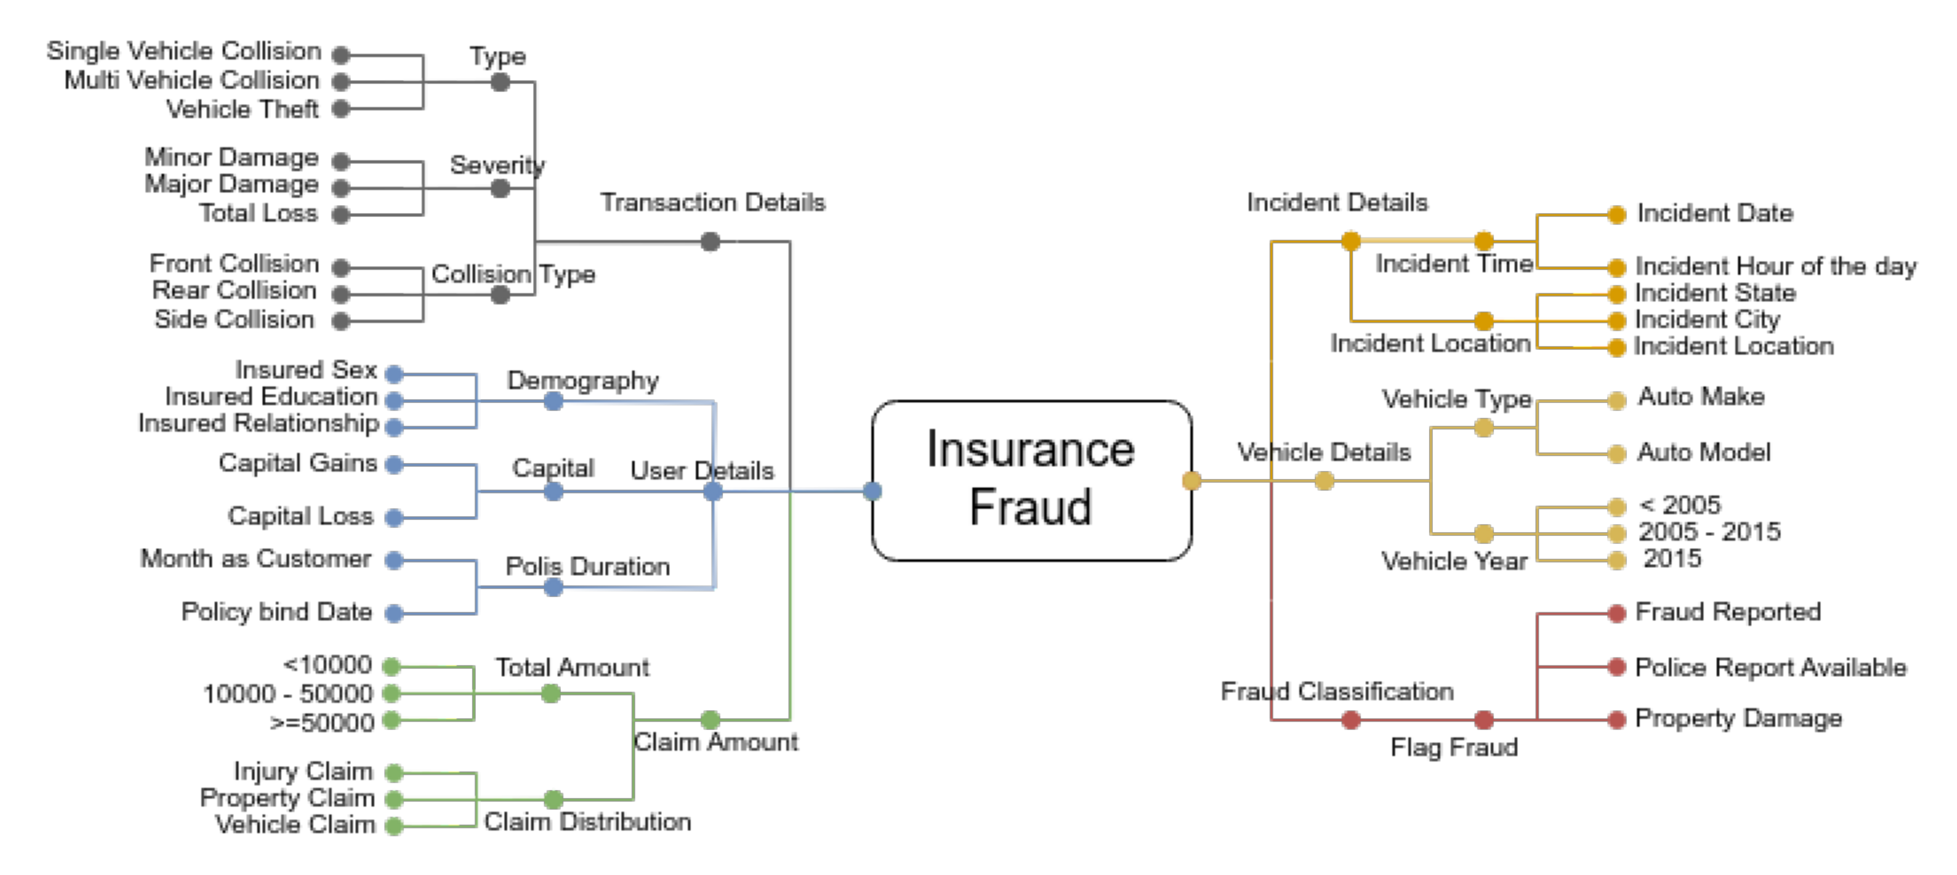

In [31]:
# Display the Image
img = mpimg.imread('Fraud_insurance-mindmap.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## 2.2 Hypothesis Creation

### 2.2.1 Transaction Detail

#### 2.2.1.1 Type

- Sekitar 2.000 klaim fraud terjadi setiap tahun akibat Single Vehicle Collision.
- 40% dari klaim terkait Multi-vehicle collision menunjukkan indikasi fraud.
- Setiap tahun, 1.500 klaim fraud teridentifikasi pada insiden yang melibatkan vehicle theft.

#### 2.2.1.2 Severity

- Klaim kerusakan minor cenderung lebih sering valid, dengan 80% klaim kerusakan minor.
- 500 klaim fraud terkait dengan kerusakan total setiap tahun.
- Total Loss memiliki kemungkinan fraud yang sangat tinggi, sekitar 60% klaim.

#### 2.2.1.2 Collision Type

- 40% klaim fraud terjadi pada kecelakaan front collision.
- Kecelakaan side collision terlibat dalam fraud dengan tingkat sekitar 25%.
- Klaim fraud yang melibatkan rear collision memiliki kemungkinan sekitar 35%.

### 2.2.2 User Details

#### 2.2.2.1 Demography

- Pria berusia antara 25 hingga 40 tahun lebih cenderung mengajukan klaim fraud.
- Individu berpendidikan PhD hanya memiliki 10% kemungkinan terlibat dalam klaim penipuan.
- Wanita lebih jarang terlibat dalam klaim penipuan, dengan hanya 30% dari klaim yang diajukan oleh wanita yang dapat dikategorikan sebagai penipuan.
- 30% klaim penipuan yang melibatkan pasangan suami-istri mengarah pada kerugian yang sangat tinggi,

#### 2.2.2.2 Capital

 - Individu dengan penghasilan tinggi cenderung mengajukan klaim yang sah, dengan 80% klaim mereka terbukti valid.
 - Individu dengan kerugian modal (capital loss) lebih cenderung melakukan klaim penipuan sekitar 35%.
 - Sekitar 3.000 klaim fraud yang dilakukan oleh individu dengan capital loss tercatat setiap tahun.

#### 2.2.2.3 Polis Duration

- 80% Klaim fraud lebih sering diajukan oleh nasabah yang baru mendaftar

### 2.2.3 Claim Amount

#### 2.2.3.1 Total Amount

- Klaim dengan nilai lebih tinggi (misalnya >50,000) lebih sering terkait dengan fraud.
- 65% klaim besar melibatkan fraud karena besarnya kerugian yang diklaim.
- Klaim dengan jumlah kecil (<10,000) lebih sering valid, dengan sekitar 80% klaim untuk jumlah kecil terbukti sah.

#### 2.2.3.2 Claim Distribution

- Klaim cedera melibatkan fraud sekitar 50%, karena kesulitan dalam membuktikan cedera yang sebenarnya.
- Klaim terkait kerusakan properti di wilayah dengan tingkat kriminalitas tinggi lebih sering terlibat dalam fraud, dengan tingkat fraud mencapai 60%
- Klaim kerusakan properti (property claim) yang melibatkan kerusakan besar lebih sering terlibat fraud, dengan 50% klaim ini berpotensi palsu.

### 2.2.4  Incident Details

####  2.2.4.1 Incident Time

- Klaim fraud lebih sering terjadi pada jam malam atau dini hari, dengan 40% klaim yang diajukan pada waktu tersebut terbukti dipalsukan.
- Insiden yang terjadi pada waktu kerja normal lebih cenderung valid, dengan 70% klaim yang diajukan pada waktu ini sah.
- Waktu insiden pada hari libur menunjukkan tingkat fraud lebih tinggi, sekitar 70%, karena kurangnya pengawasan.

####  2.2.4.2 Incident Location

- Lokasi dengan tingkat kriminalitas tinggi memiliki kemungkinan fraud lebih tinggi (sekitar 40% klaim fraud).
- Insiden di lokasi dengan pengawasan rendah memiliki tingkat fraud sekitar 45%

### 2.2.5 Vehicle

#### 2.2.5.1 Vehicle Type

- Kendaraan merek premium seperti BMW lebih sering terlibat fraud
- Kendaraan mewah seperti Mercedes lebih sering terlibat klaim fraud sekitar 30%
- Kendaraan seperti Chevrolet memiliki klaim fraud lebih banyak dibandingkan kendaraan honda

#### 2.2.5.2 Vehicle Year

- Klaim untuk kendaraan tahun 2005-2015 lebih sering terkait dengan penipuan
- Klaim dengan jumlah kecil (<2005) lebih sering valid, dengan sekitar 80% klaim untuk jumlah kecil terbukti sah.

### 2.2.6 Fraud Classification

- Klaim tanpa laporan polisi lebih sering fraud sekitar 40% 
- 30% klaim sering fraud terjadi karena kerusakan besar

## 2.3 Hypothesis List

- 40% dari klaim terkait Multi-vehicle collision menunjukkan indikasi fraud.
- 80% Klaim fraud lebih sering diajukan oleh nasabah yang baru mendaftar
- Pria berusia antara 25 hingga 40 tahun lebih cenderung mengajukan klaim fraud.
- Klaim dengan jumlah kecil (<10,000) lebih sering valid, dengan sekitar 80% klaim untuk jumlah kecil terbukti sah.
- Klaim fraud lebih sering terjadi pada jam malam atau dini hari, dengan 40% klaim yang diajukan pada waktu tersebut terbukti dipalsukan.
- Kendaraan sport seperti Porsche memiliki klaim fraud lebih banyak dibandingkan kendaraan sedan.
- Klaim tanpa laporan polisi lebih sering fraud sekitar 40%

## 2.4 Feature Engineering

In [32]:
# Hapus kolom 'x_c_39' dari dataframe
df2 = df2.drop(columns=['_c39'], errors='ignore')

# Menampilkan 5 baris pertama seteh modifikasi
df2.head(5)

months_as_customer  age  policy_number policy_bind_date policy_state policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  insured_zip insured_sex insured_education_level insured_occupation insured_hobbies insured_relationship  capital-gains  capital-loss incident_date             incident_type   collision_type incident_severity authorities_contacted incident_state incident_city  incident_location  incident_hour_of_the_day  number_of_vehicles_involved property_damage  bodily_injuries  witnesses police_report_available  total_claim_amount  injury_claim  property_claim  vehicle_claim  auto_make auto_model  auto_year fraud_reported
0                 328   48         521585       2014-10-17           OH    250/500               1000                1406.91               0       466132        MALE                      MD       craft-repair        sleeping              husband          53300             0    2015-01-25  Single Vehicle Collision   Side Collision      Major Damage                Police             SC      Columbus     9935 4th Drive                         5                            1             YES                1          2                     YES               71610          6510           13020          52080       Saab        92x       2004            yes
1                 228   42         342868       2006-06-27           IN    250/500               2000                1197.22         5000000       468176        MALE                      MD  machine-op-inspct         reading       other-relative              0             0    2015-01-21             Vehicle Theft          Unknown      Minor Damage                Police             VA     Riverwood       6608 MLK Hwy                         8                            1         Unknown                0          0                 Unknown                5070           780             780           3510   Mercedes       E400       2007            yes
2                 134   29         687698       2000-09-06           OH    100/300               2000                1413.14         5000000       430632      FEMALE                     PhD              sales     board-games            own-child          35100             0    2015-02-22   Multi-vehicle Collision   Rear Collision      Minor Damage                Police             NY      Columbus  7121 Francis Lane                         7                            3              NO                2          3                      NO               34650          7700            3850          23100      Dodge        RAM       2007             no
3                 256   41         227811       1990-05-25           IL    250/500               2000                1415.74         6000000       608117      FEMALE                     PhD       armed-forces     board-games            unmarried          48900        -62400    2015-01-10  Single Vehicle Collision  Front Collision      Major Damage                Police             OH     Arlington   6956 Maple Drive                         5                            1         Unknown                1          2                      NO               63400          6340            6340          50720  Chevrolet      Tahoe       2014            yes
4                 228   44         367455       2014-06-06           IL   500/1000               1000                1583.91         6000000       610706        MALE               Associate              sales     board-games            unmarried          66000        -46000    2015-02-17             Vehicle Theft          Unknown      Minor Damage                     0             NY     Arlington       3041 3rd Ave                        20                            1              NO                0          1                      NO                6500          1300             650           4550     Accura        RSX       2009             no

# 3.0 Selecting Columns

---

In [33]:
# Menyalin dataframe
df3 = df2.copy()

## 3.1 Selecting Columns

Saya gunakan semua kolom untuk analisis

## 3.2 Selecting Rows

Saya gunakan semua baris untuk data analisis

# 4.0 Exploratory Data Analysis

---

In [34]:
# Menyalin dataframe
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

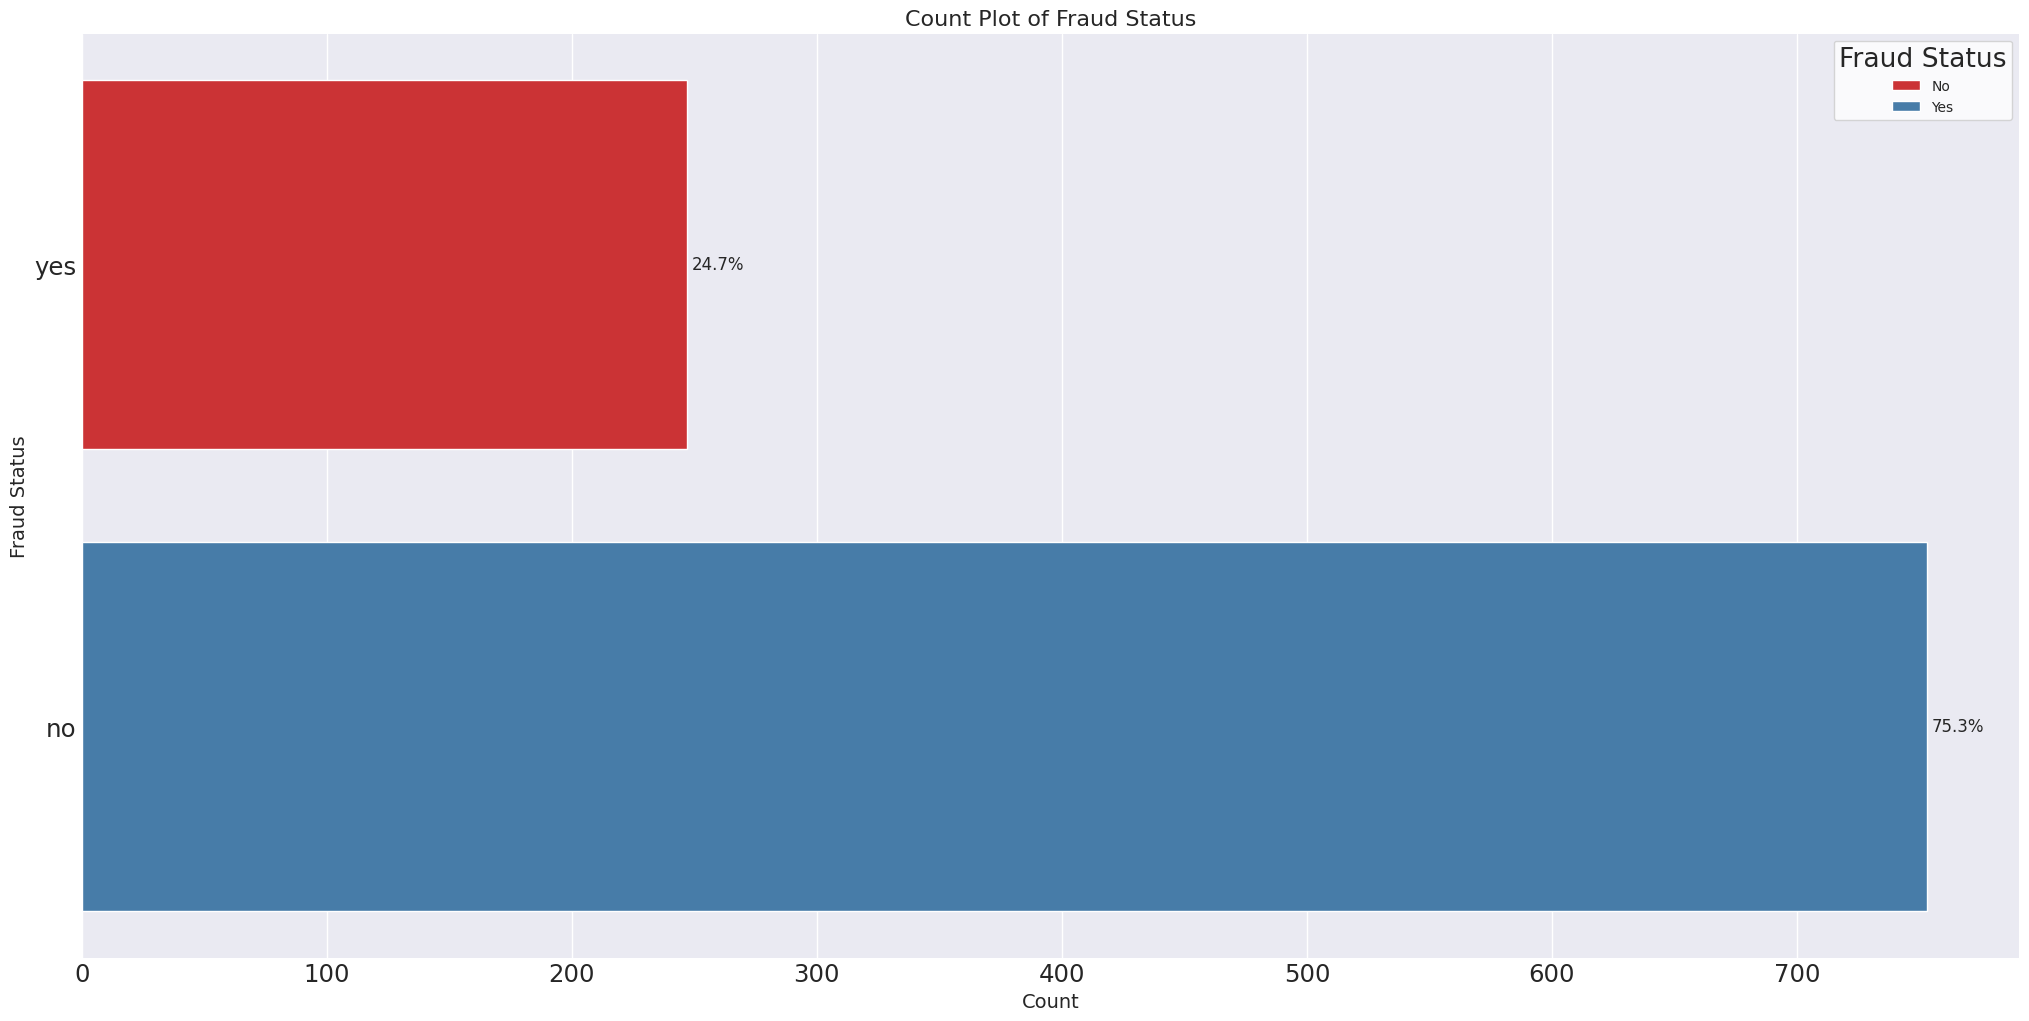

In [35]:
# Membuat countplot 'fraud_reported pada sumbu y
ax = sns.countplot(y='fraud_reported', data=df4, palette='Set1')

# Menghitung persentase untuk label
total = df4['fraud_reported'].size
for p in ax.patches:
    width = p.get_width()
    percentage = (width / total) * 100
    ax.text(width + 2, p.get_y() + p.get_height() / 2, f'{percentage:.1f}%',
           ha='left', va='center', fontsize=12)

# Menambahkan judul dan label
ax.set_title('Count Plot of Fraud Status', fontsize=16)
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Fraud Status', fontsize=14)
ax.legend(['No', 'Yes'], title='Fraud Status', fontsize=10, frameon='True', facecolor='white')

# Menampilkan plot
plt.show()

### 4.1.2 Numerical Variables

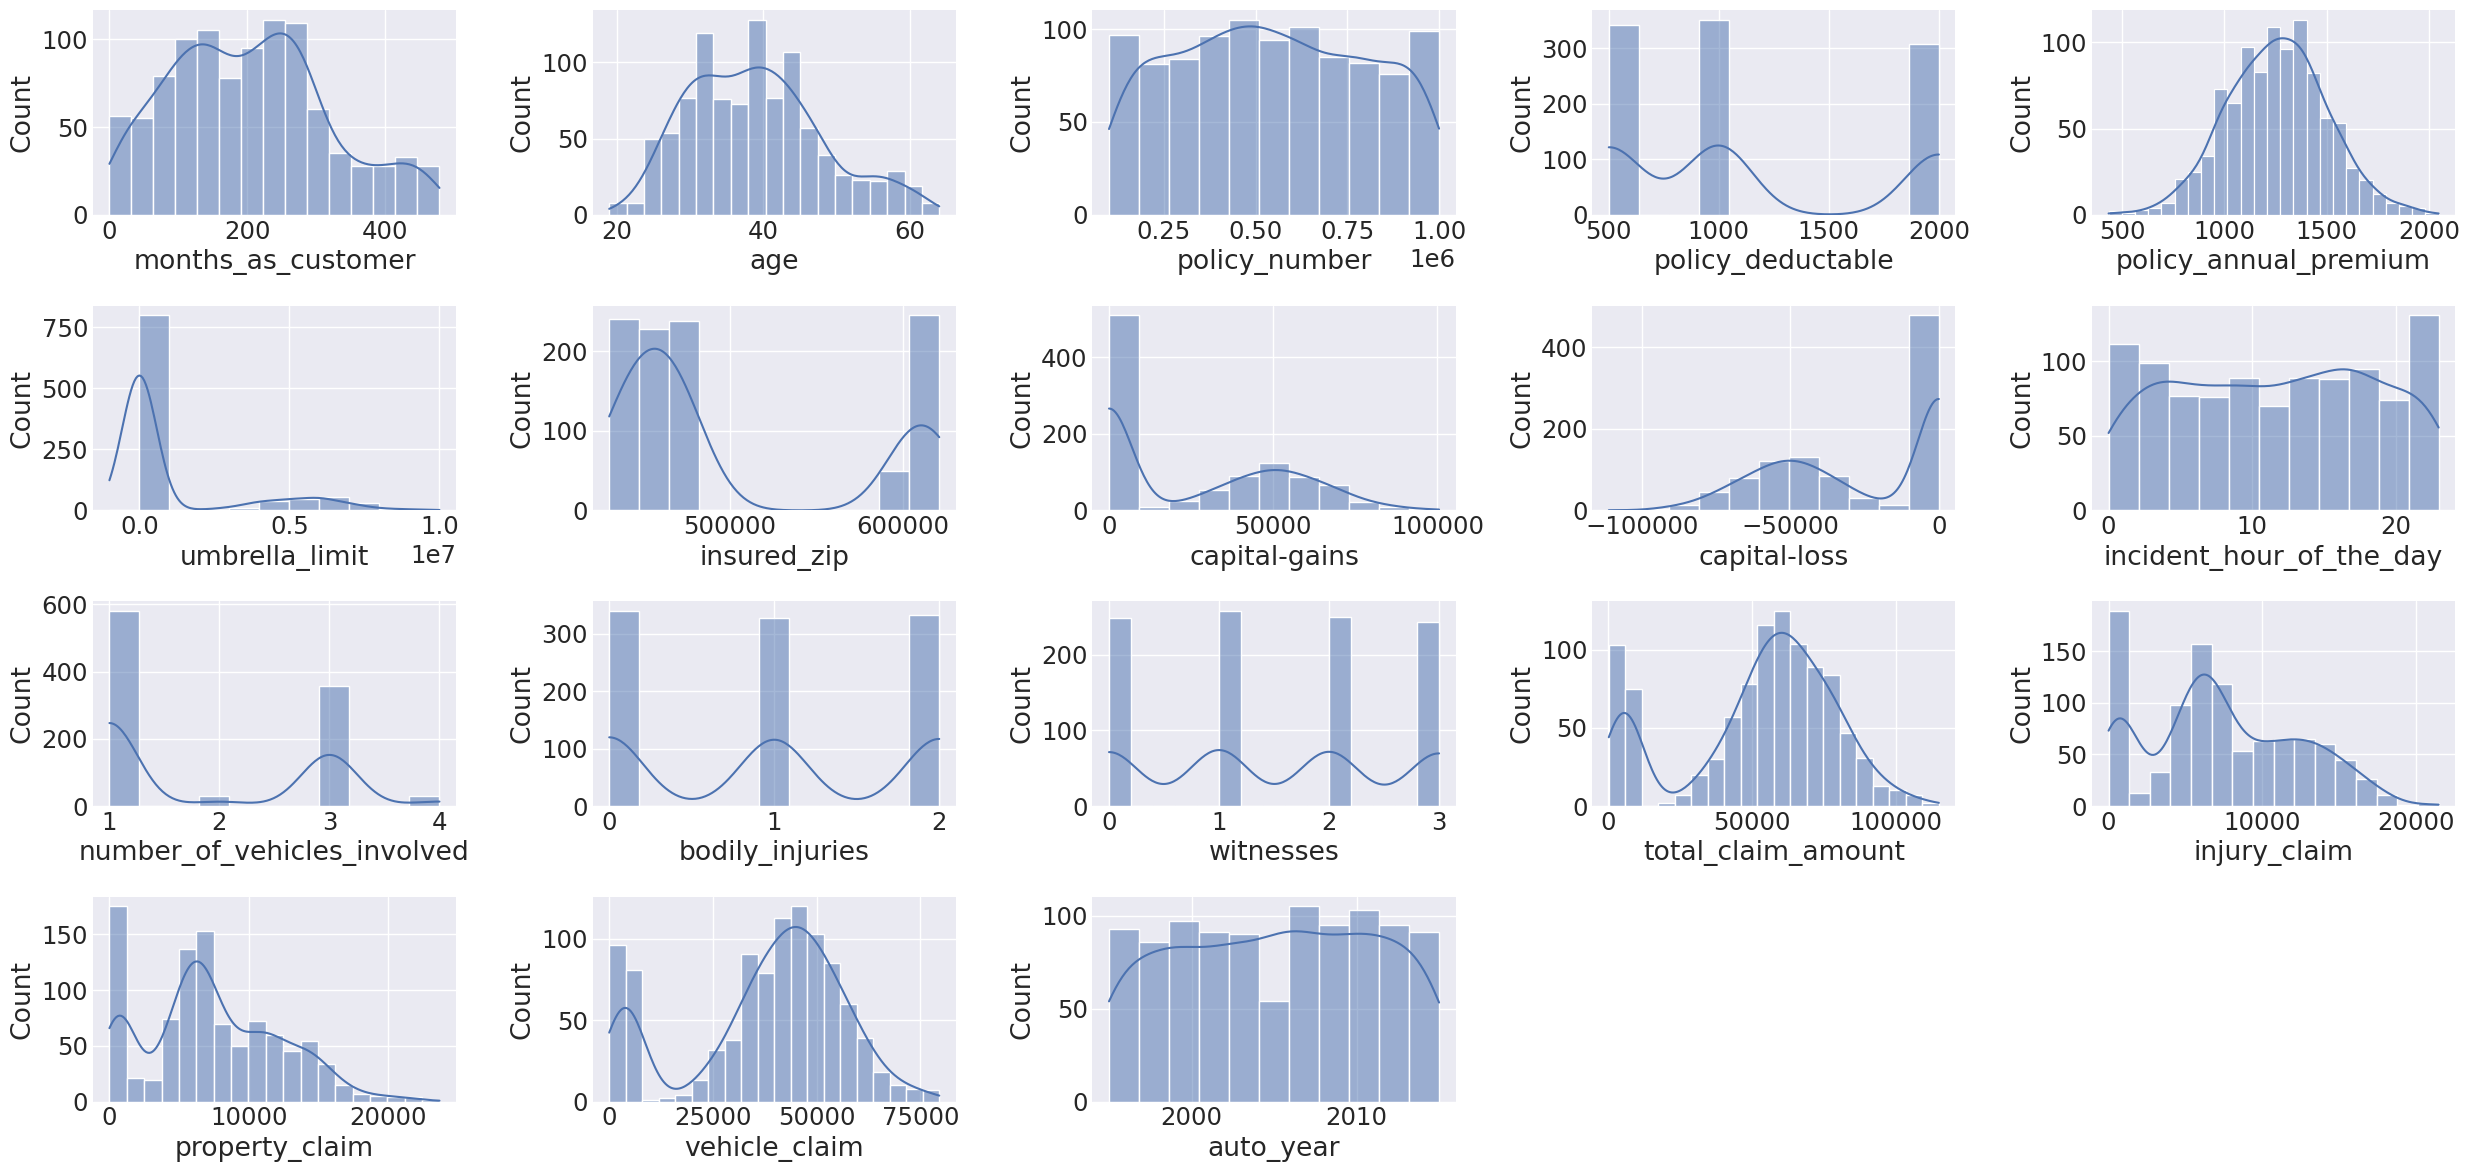

In [36]:
# Membuat plot numeric
Num_plot = univariate_plot(df4, type_attributes='numeric')
Num_plot

### 4.1.3 Categorical Variables

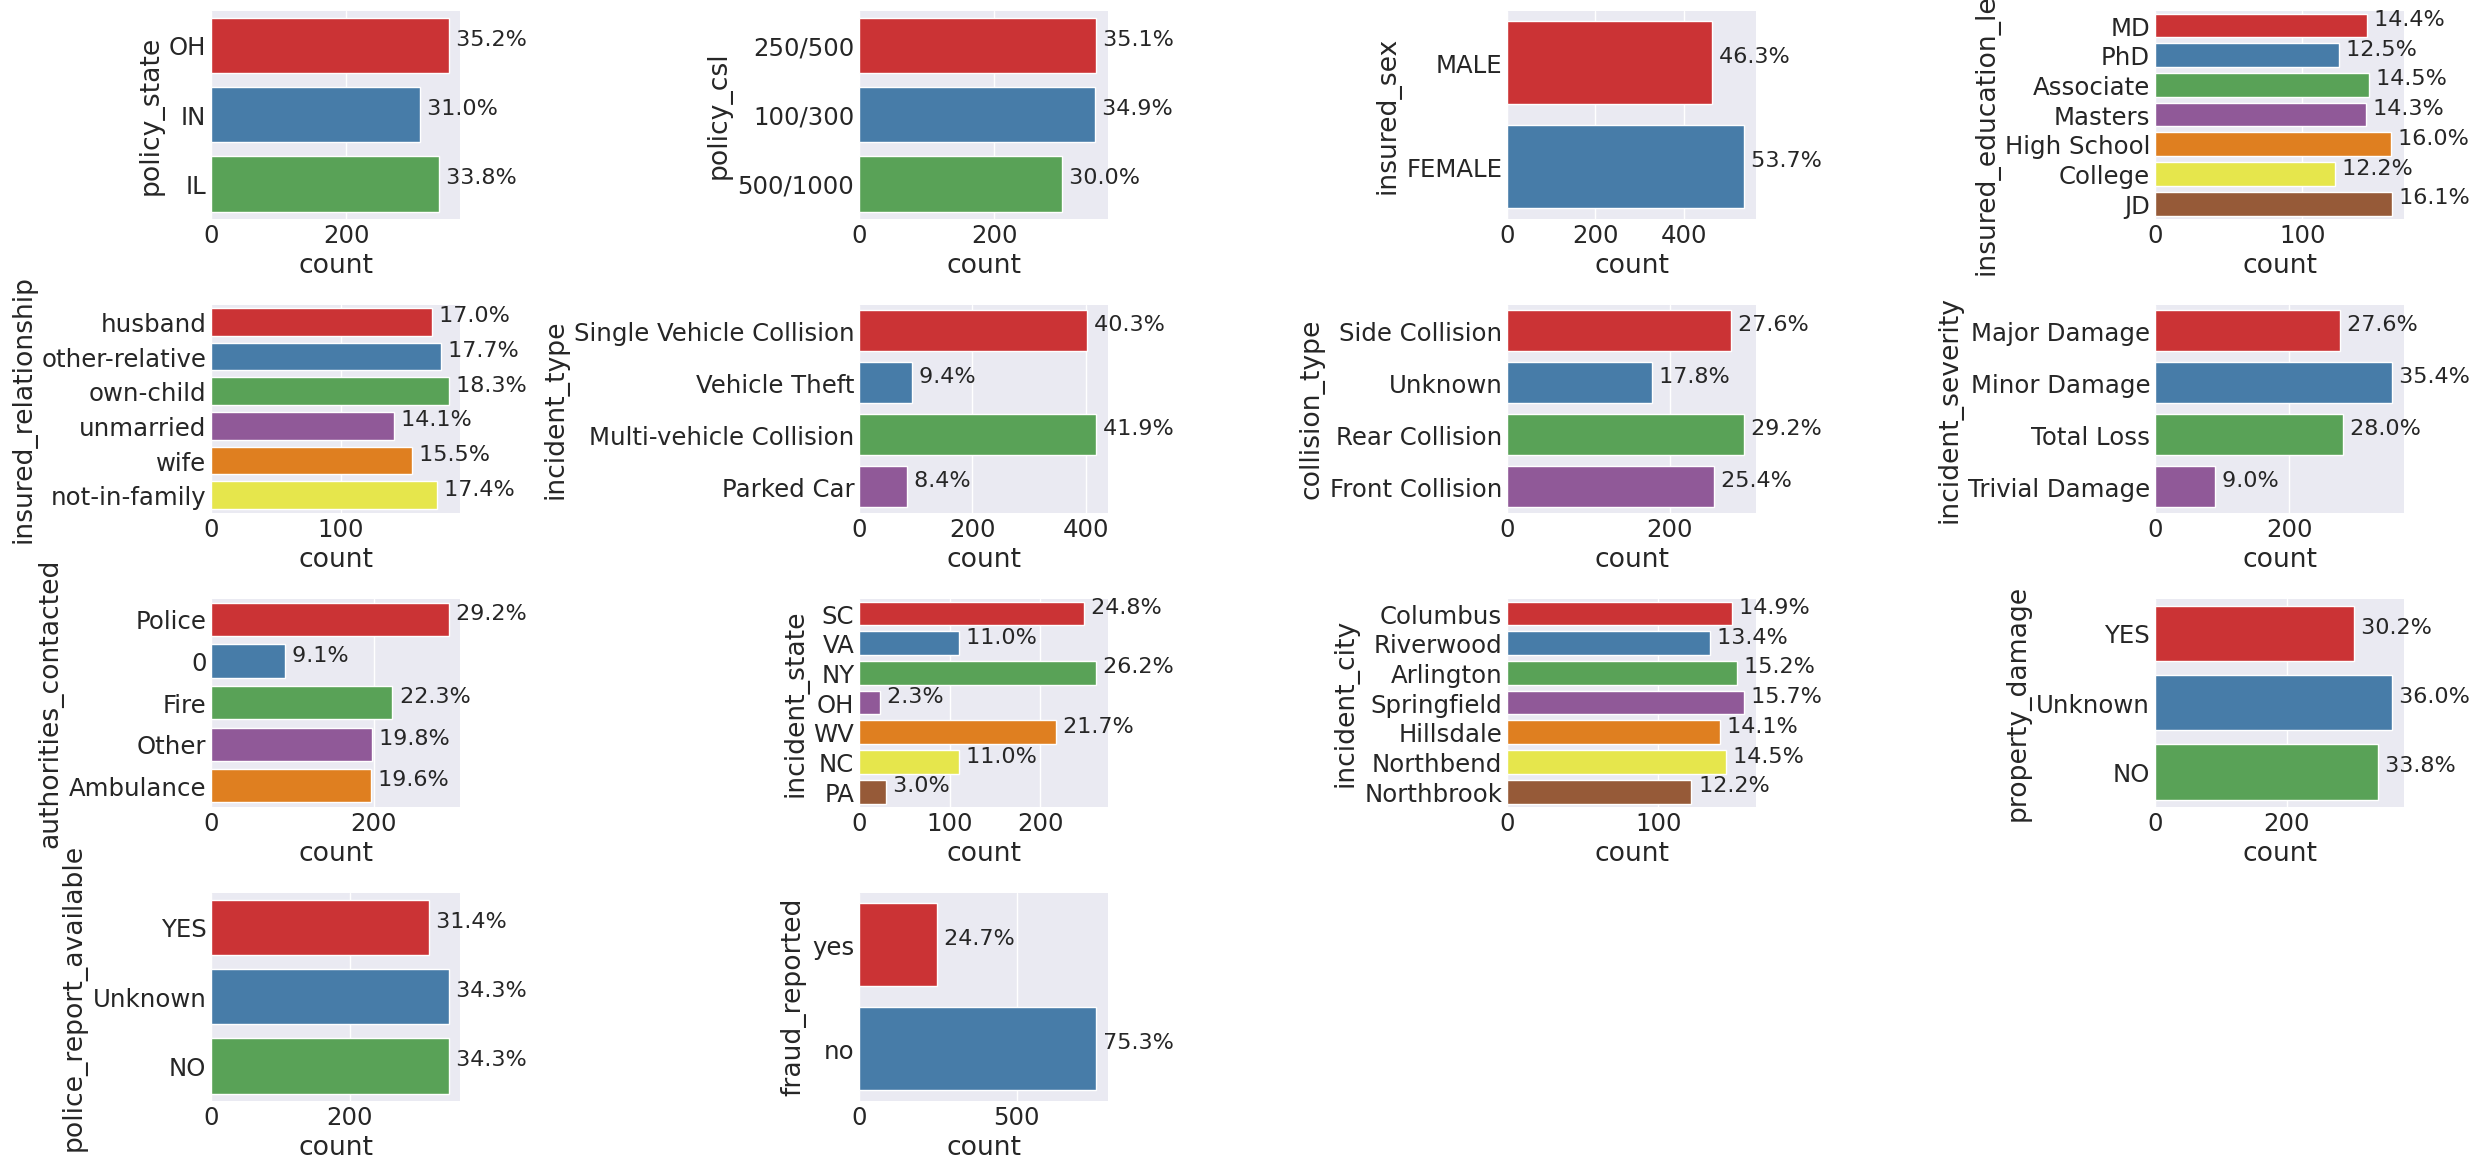

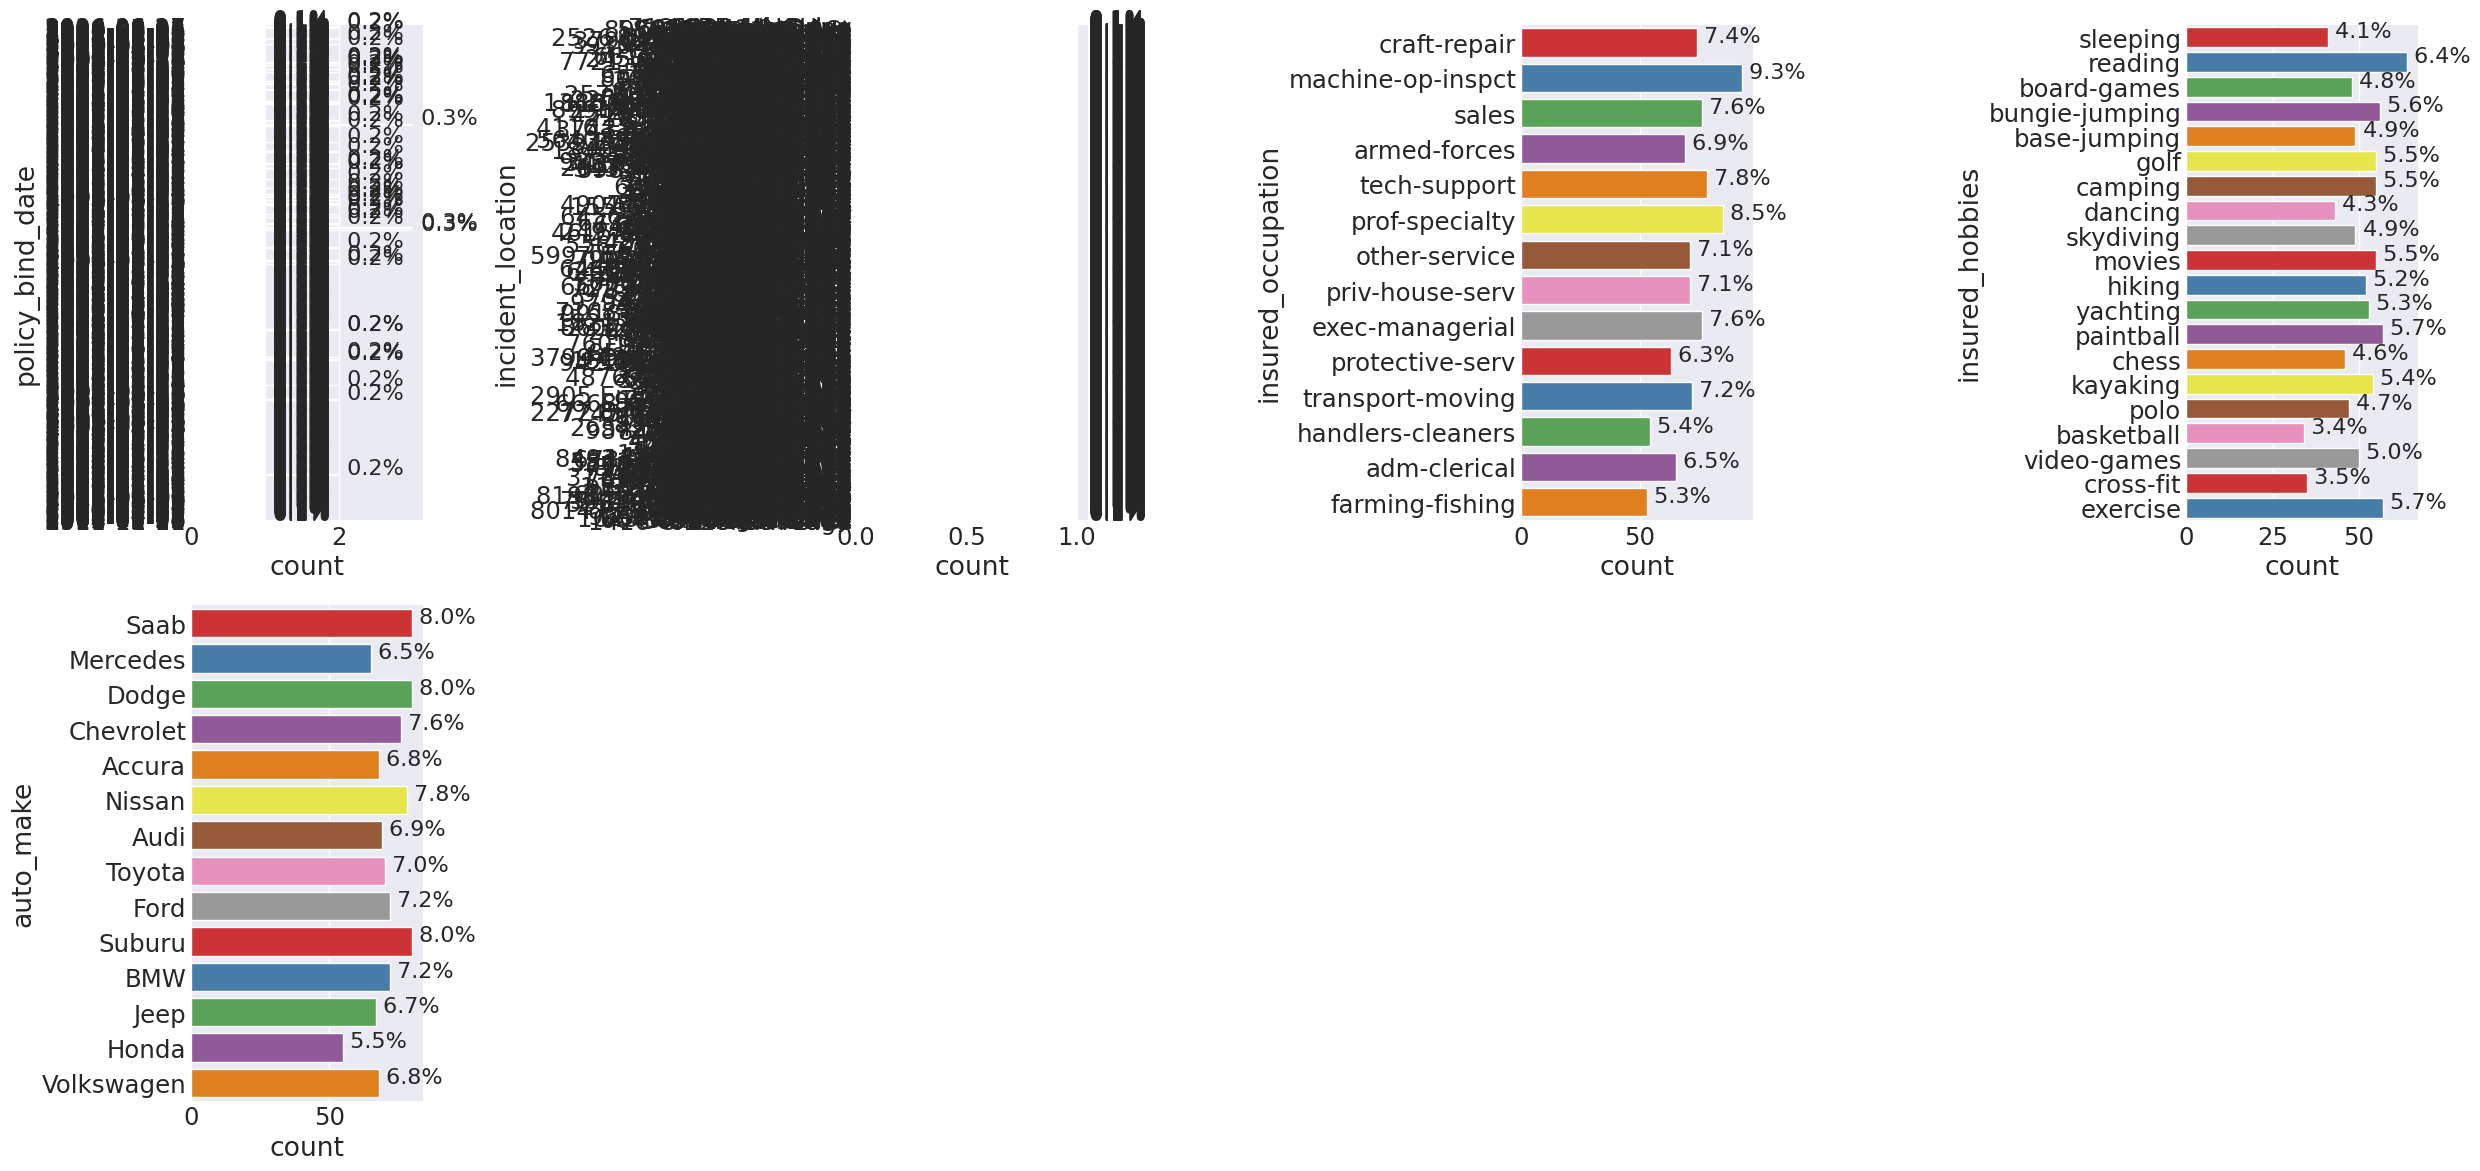

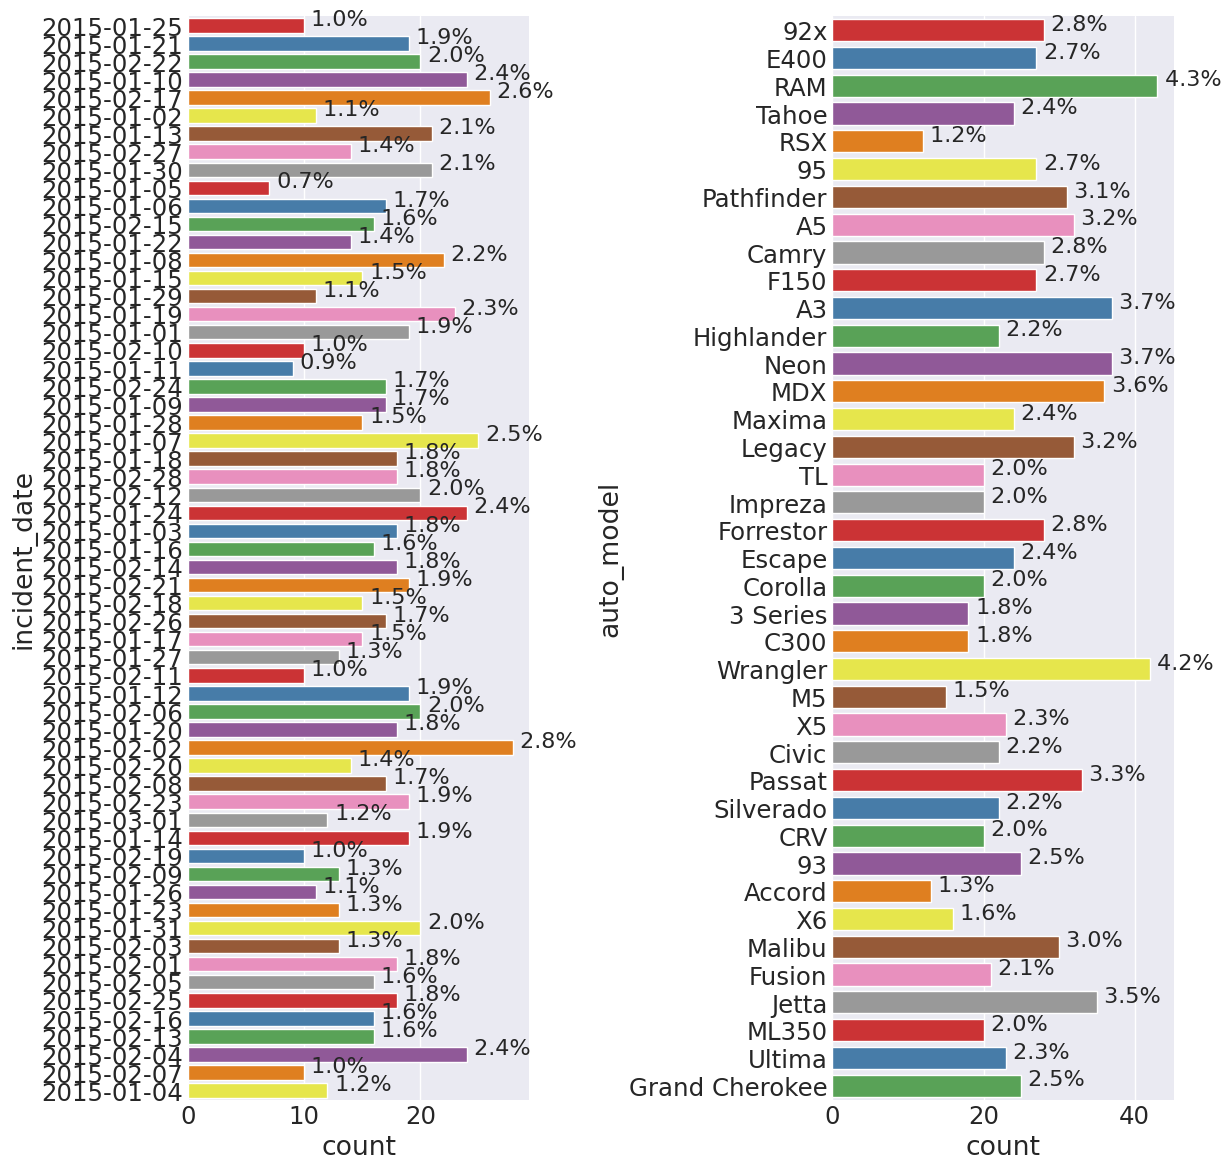

In [37]:
df_cat_pt1 = df4.drop(columns=['policy_bind_date','incident_location', 'incident_date', 'insured_occupation', 'insured_hobbies', 'auto_model', 'auto_make'])
df_cat_pt2 = df4[['policy_bind_date','incident_location', 'insured_occupation', 'insured_hobbies', 'auto_make']]
df_cat_pt3 = df4[['incident_date', 'auto_model']]

# Memanggil fungsi dan menyimpan plot
Cat_plot_pt1 = univariate_plot(df_cat_pt1, type_attributes='categorical')
Cat_plot_pt1

Cat_plot_pt2 = univariate_plot(df_cat_pt2, type_attributes='categorical')
Cat_plot_pt2

Cat_plot_pt3 = univariate_plot(df_cat_pt3, type_attributes='categorical')
Cat_plot_pt3

## 4.2 Bivariate Analysis

#### H1. 40% dari klaim terkait Multi-vehicle collision menunjukan indikasi fraud

##### <span style="color: red; font-weight: bold;">FALSE</span>

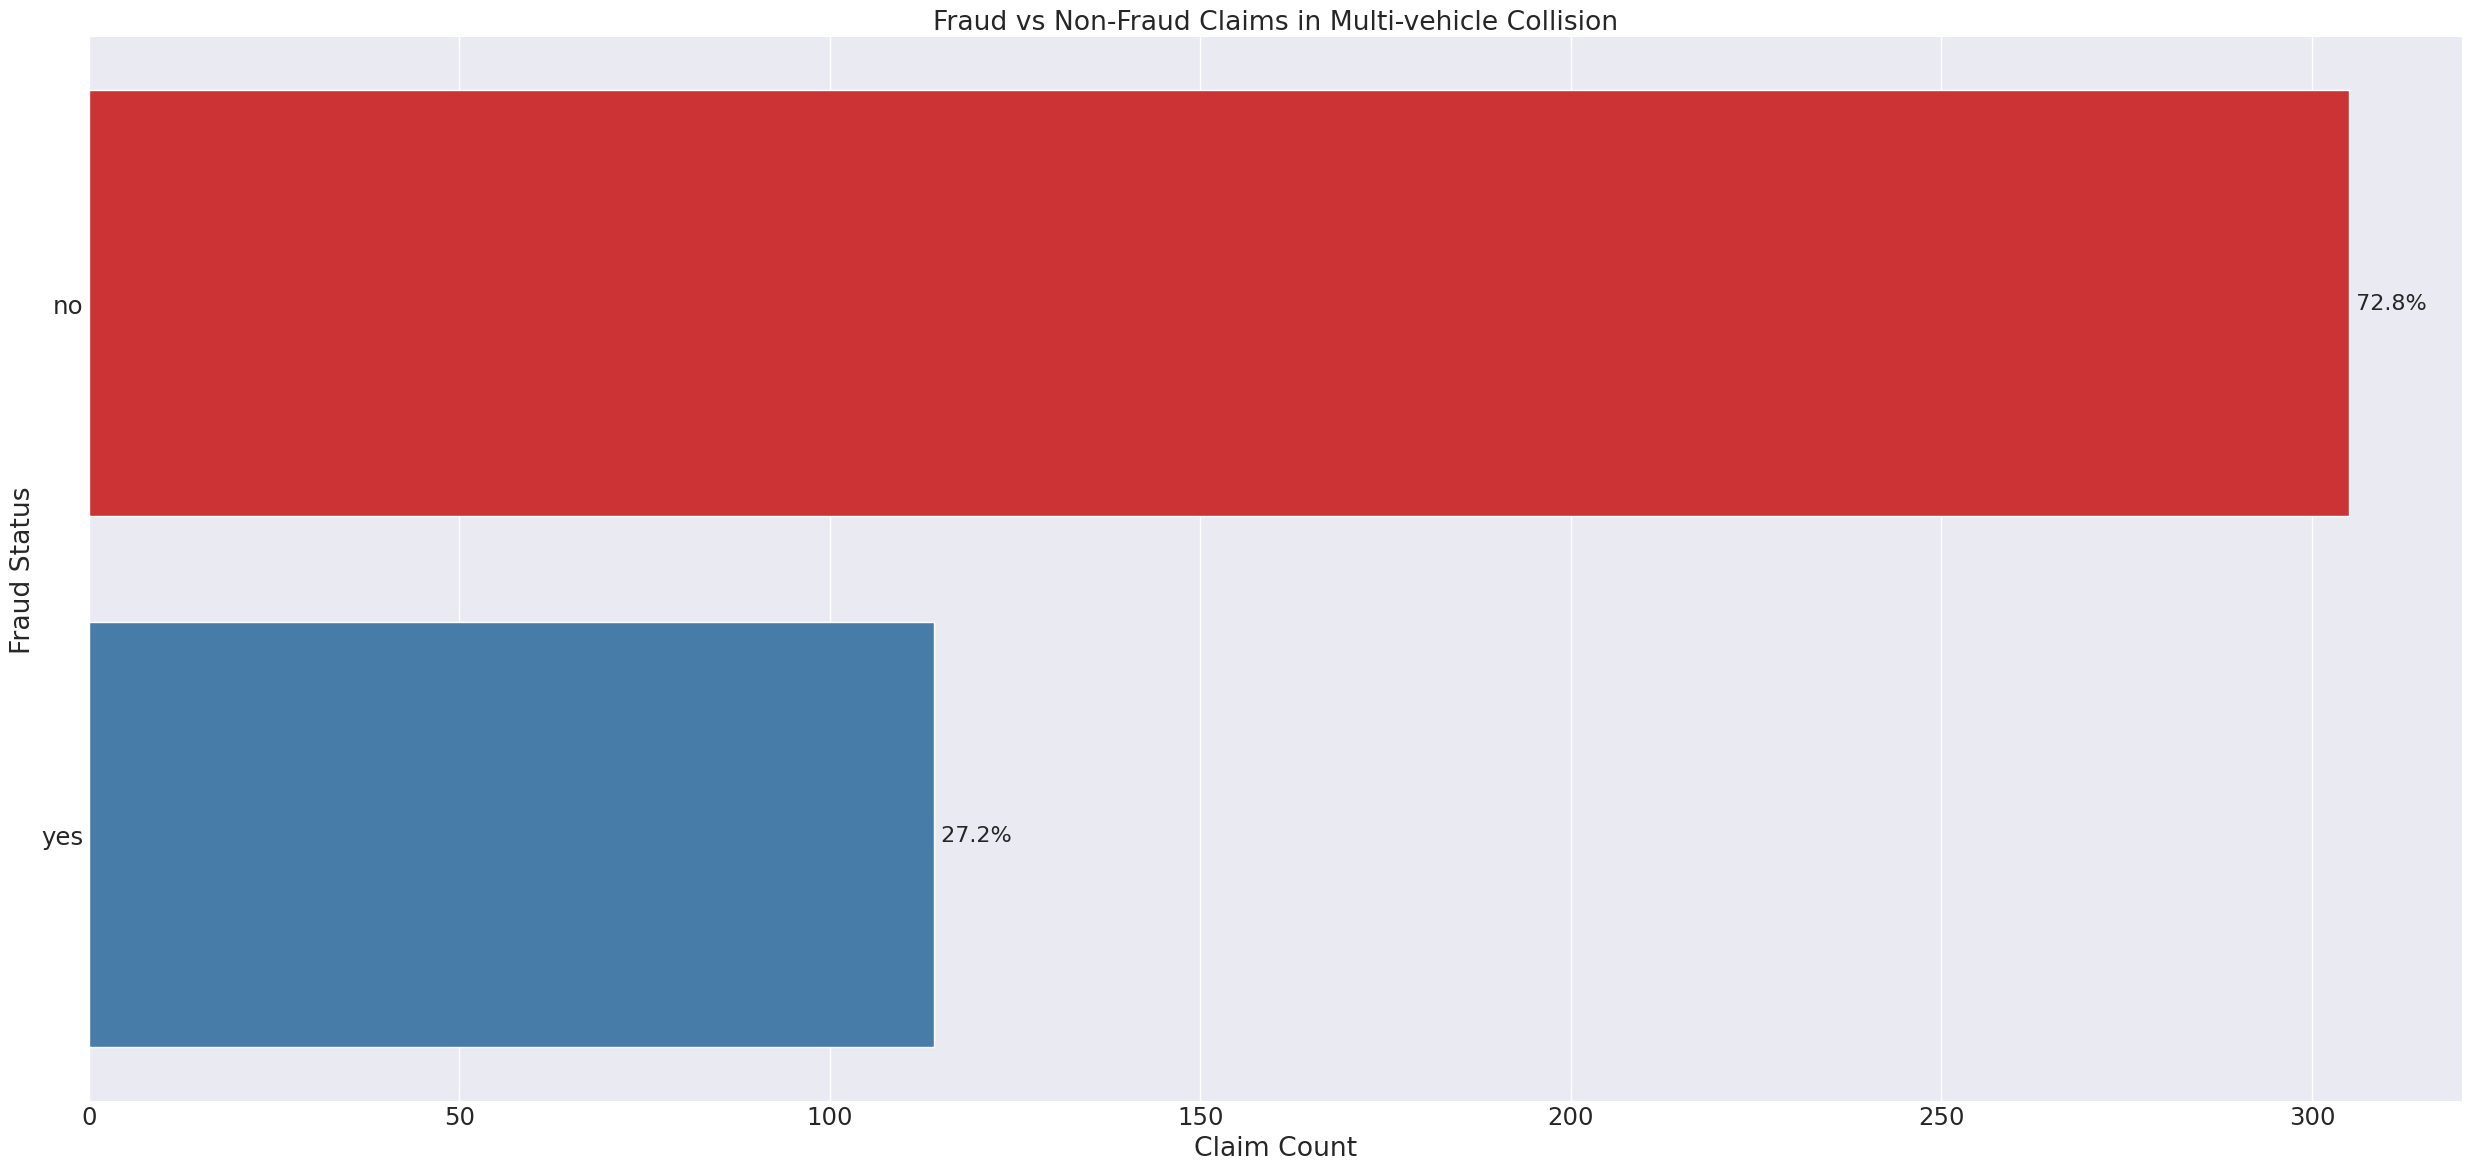

In [38]:
# Filter data
multi_vehicle_collision_data = df4[df4['incident_type'] == 'Multi-vehicle Collision']

# Membuat countplot
ax = sns.countplot(y='fraud_reported', data=multi_vehicle_collision_data, palette="Set1")

# Dapatkan jumlah total klaim
total = multi_vehicle_collision_data['fraud_reported'].size

# Anotasi plot dengan persentase
for p in ax.patches:
    percentage = ' {:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), va='center')

# Berikan label dan judul plot
ax.set_title("Fraud vs Non-Fraud Claims in Multi-vehicle Collision")
ax.set_xlabel("Claim Count")
ax.set_ylabel("Fraud Status")

# Menampilkan Plot
plt.tight_layout()
plt.show()

#### H2. 80% klaim fraud lebih sering diajukan oleh nasabah yang baru mendaftar (kurang dari 12 bulan)

##### <span style="color: red; font-weight: bold;">FALSE</span>

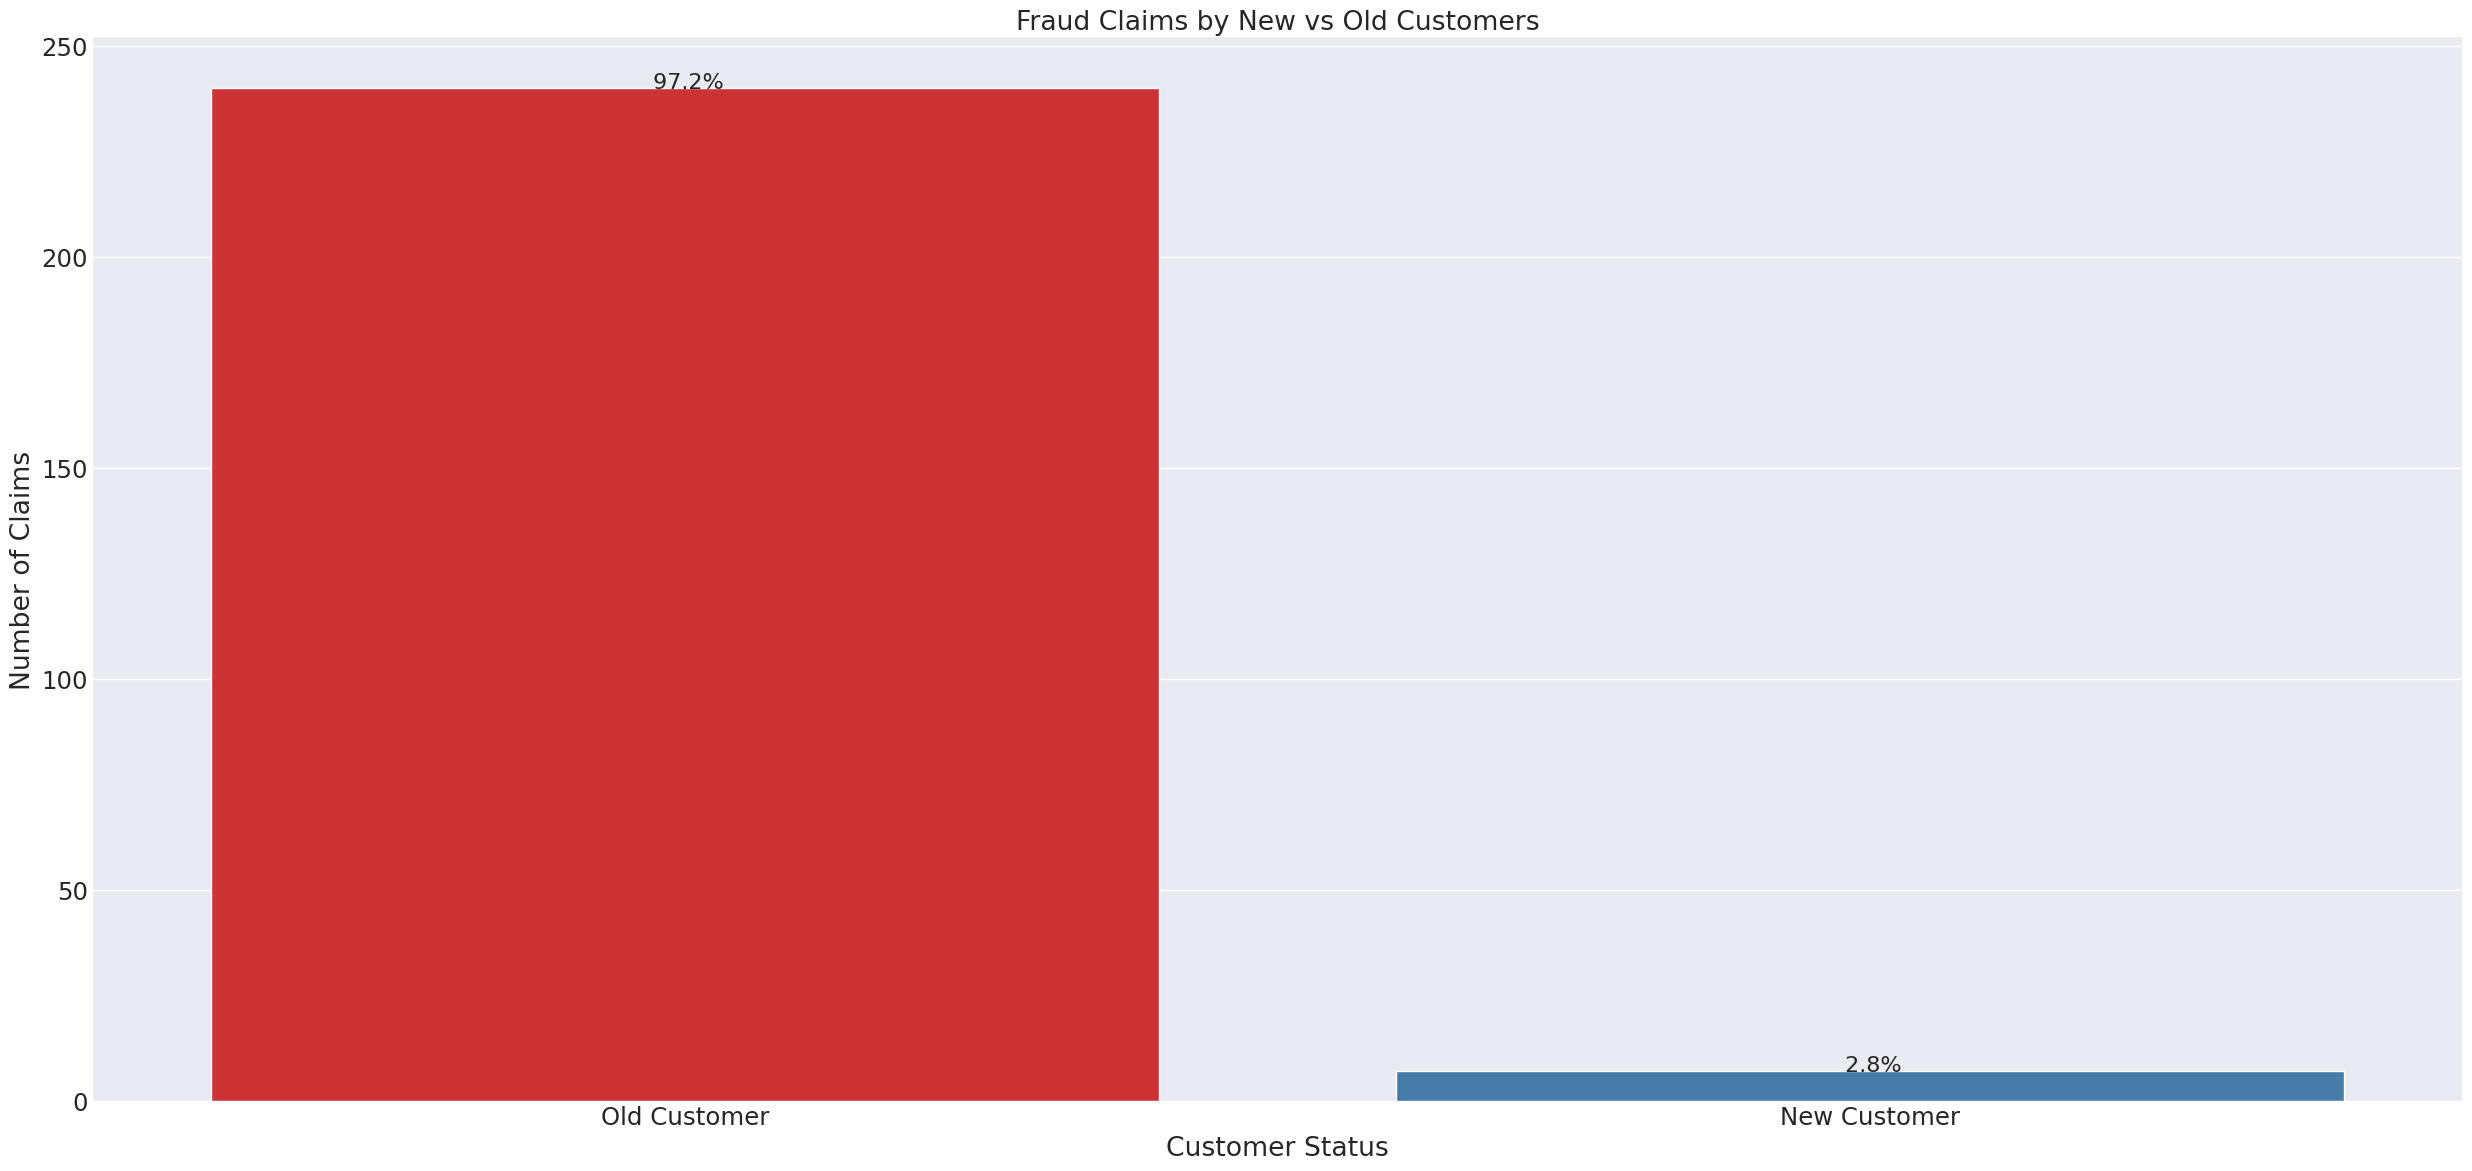

In [39]:
# Filter data
fraud_by_customer = df4[df4['fraud_reported'] == 'yes']
fraud_by_customer['customer_status'] = fraud_by_customer['months_as_customer'].apply(
    lambda x: 'New Customer' if x < 12 else 'Old Customer'
)

# Menghitung klaim fraud berdasar status customer
fraud_counts = fraud_by_customer['customer_status'].value_counts().reset_index()
fraud_counts.columns = ['customer_status', 'fraud_count']

# Membuat bar plot
ax = sns.barplot(x='customer_status', y='fraud_count', data=fraud_counts, palette='Set1')

# Menghitung jumlah total claim
total = fraud_counts['fraud_count'].sum()

# Menambahkan label persentase
for p in ax.patches:
    height = p.get_height()
    percentage = ' {:.1f}%'.format(100 * height / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + height + 0.02
    ax.annotate(percentage, (x, y), ha='center')

# Mengatur label dan judul plot
ax.set_title("Fraud Claims by New vs Old Customers")
ax.set_xlabel("Customer Status")
ax.set_ylabel("Number of Claims")

# Menampilkan plot
plt.tight_layout()
plt.show()

#### H3. Pria berusia antara 25 hingga 40 tahun lebih cenderung mengajukan klaim fraud

##### <span style="color: blue; font-weight: bold;">TRUE</span>

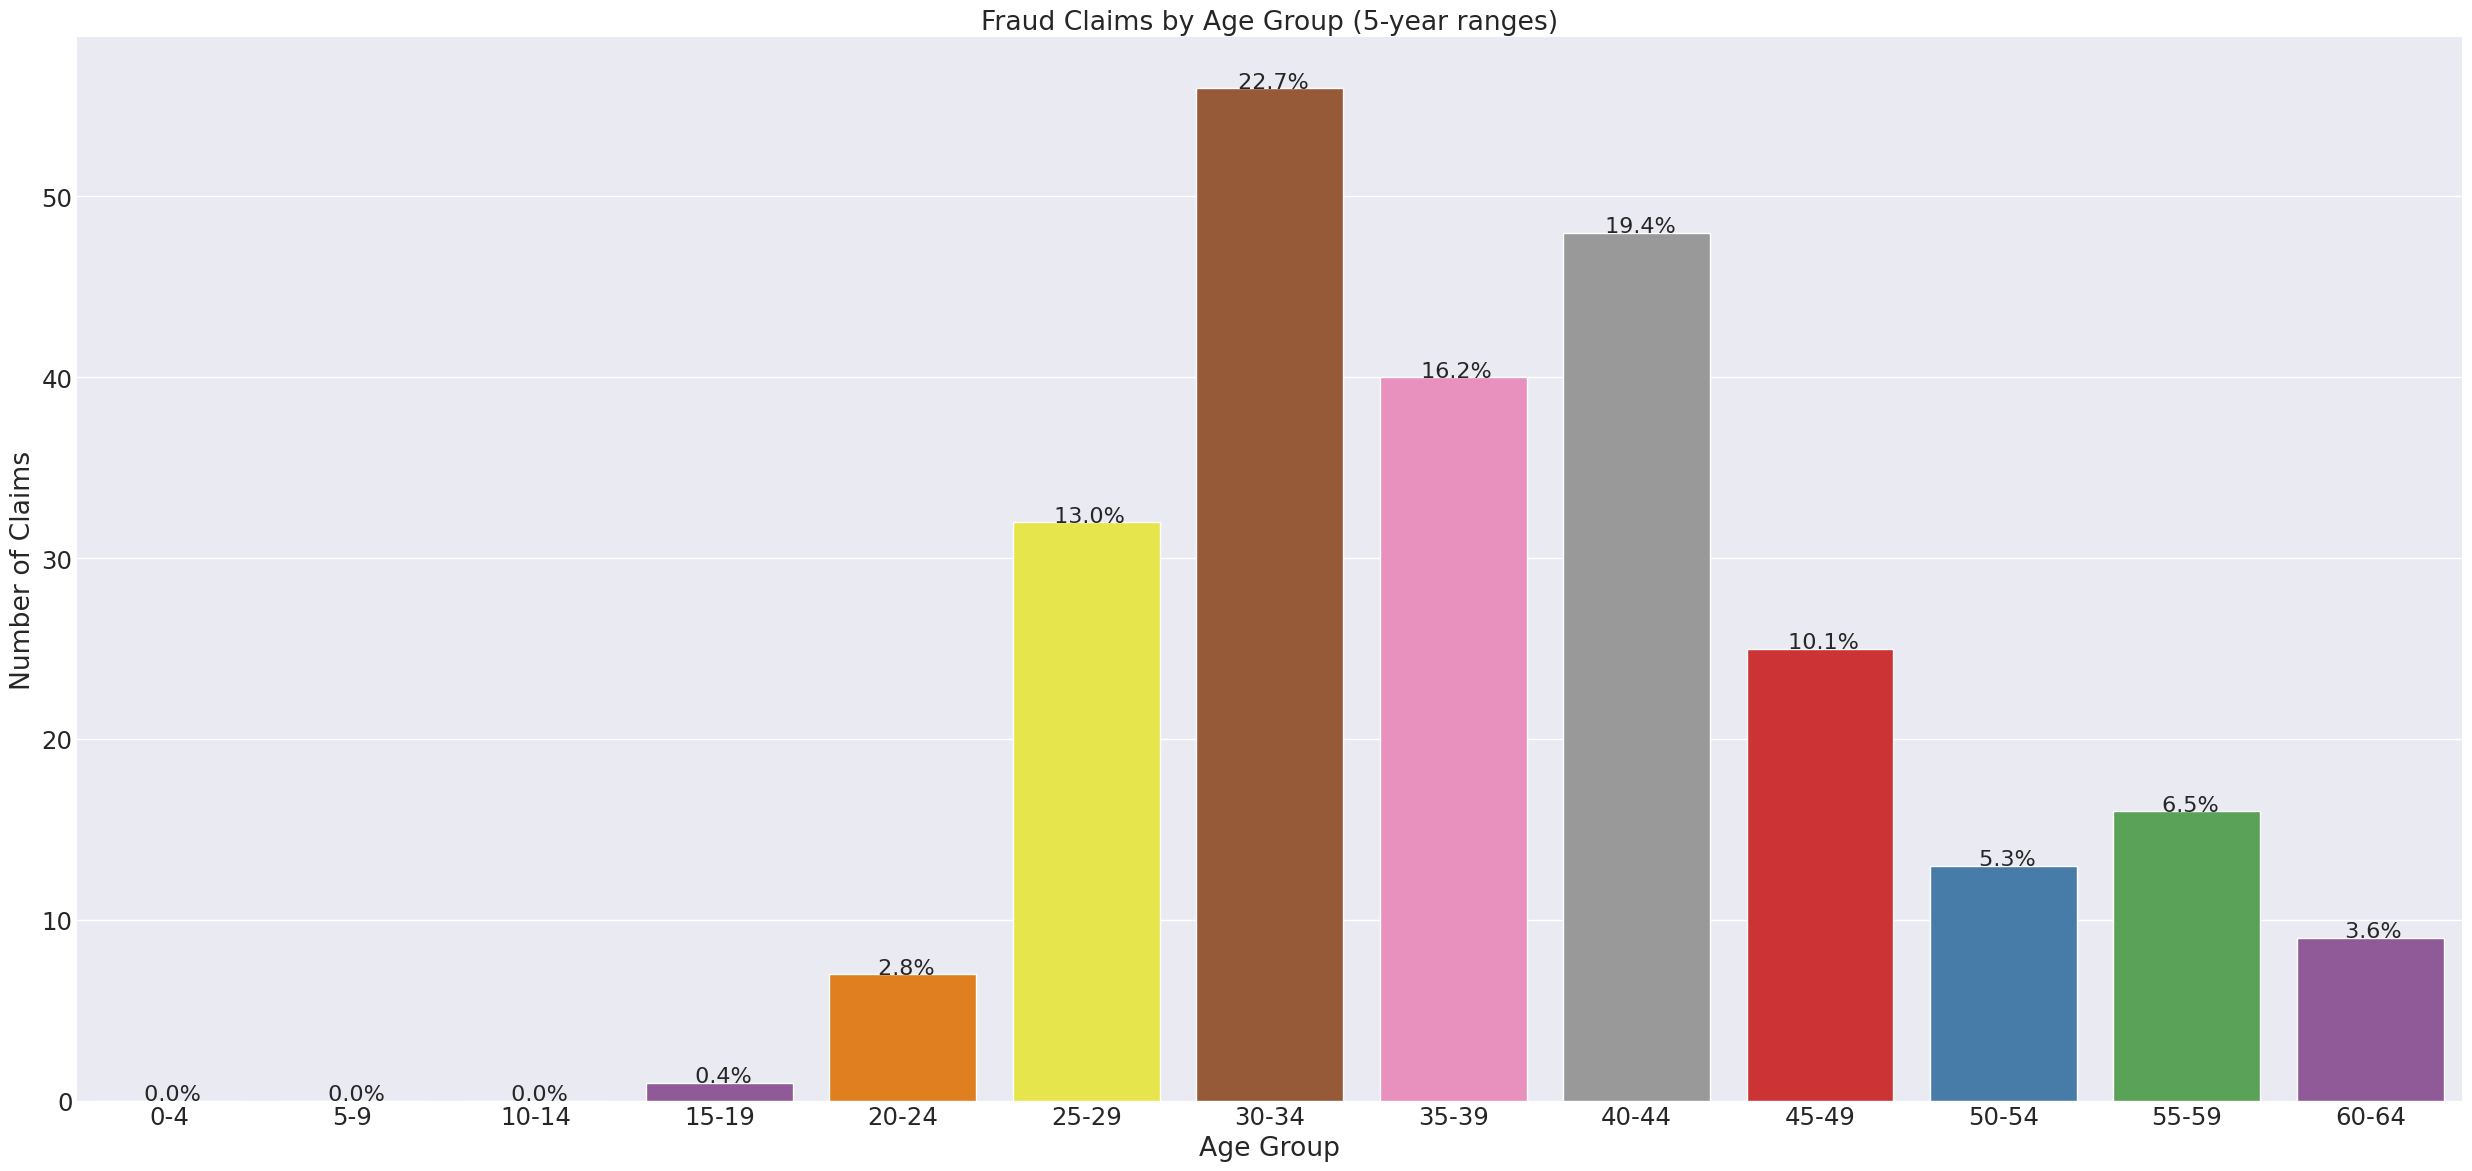

In [40]:
# Filter Data
fraud_per_age_group = df4[df4['fraud_reported'] == 'yes']

# Membuat grup umur dengan jarak 5 tahun
fraud_per_age_group['age_group'] = pd.cut(
    fraud_per_age_group['age'],
    bins=range(0, fraud_per_age_group['age'].max() + 5, 5),
    right=False,
    labels=[f'{i}-{i+4}' for i in range(0, fraud_per_age_group['age'].max(), 5)]
)

# Menghitung klaim fraud per grup
fraud_per_age_group_count = fraud_per_age_group['age_group'].value_counts().reset_index()
fraud_per_age_group_count.columns = ['age_group', 'fraud_count']

# Menghitung total klaim fraud
total_fraud_claims = fraud_per_age_group_count['fraud_count'].sum()

# Membuat Bar Plot
ax = sns.barplot(data=fraud_per_age_group_count, x='age_group', y='fraud_count', palette='Set1')

# Menambahkan label persentase
for p in ax.patches:
    height = p.get_height()
    percentage = ' {:.1f}%'.format(100 * height / total_fraud_claims)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + height + 0.02
    ax.annotate(percentage, (x, y), ha='center')

# Mengatur label dan judul
ax.set_title("Fraud Claims by Age Group (5-year ranges)")
ax.set_xlabel("Age Group")
ax.set_ylabel("Number of Claims")

# Menampilkan plot
plt.tight_layout()
plt.show()

#### H4. Klaim dengan jumlah kecil (<10,000) lebih sering valid, dengan sekitar 80% klaim untuk jumlah kecil terbukti sah.

##### <span style="color: blue; font-weight: bold;">TRUE</span>

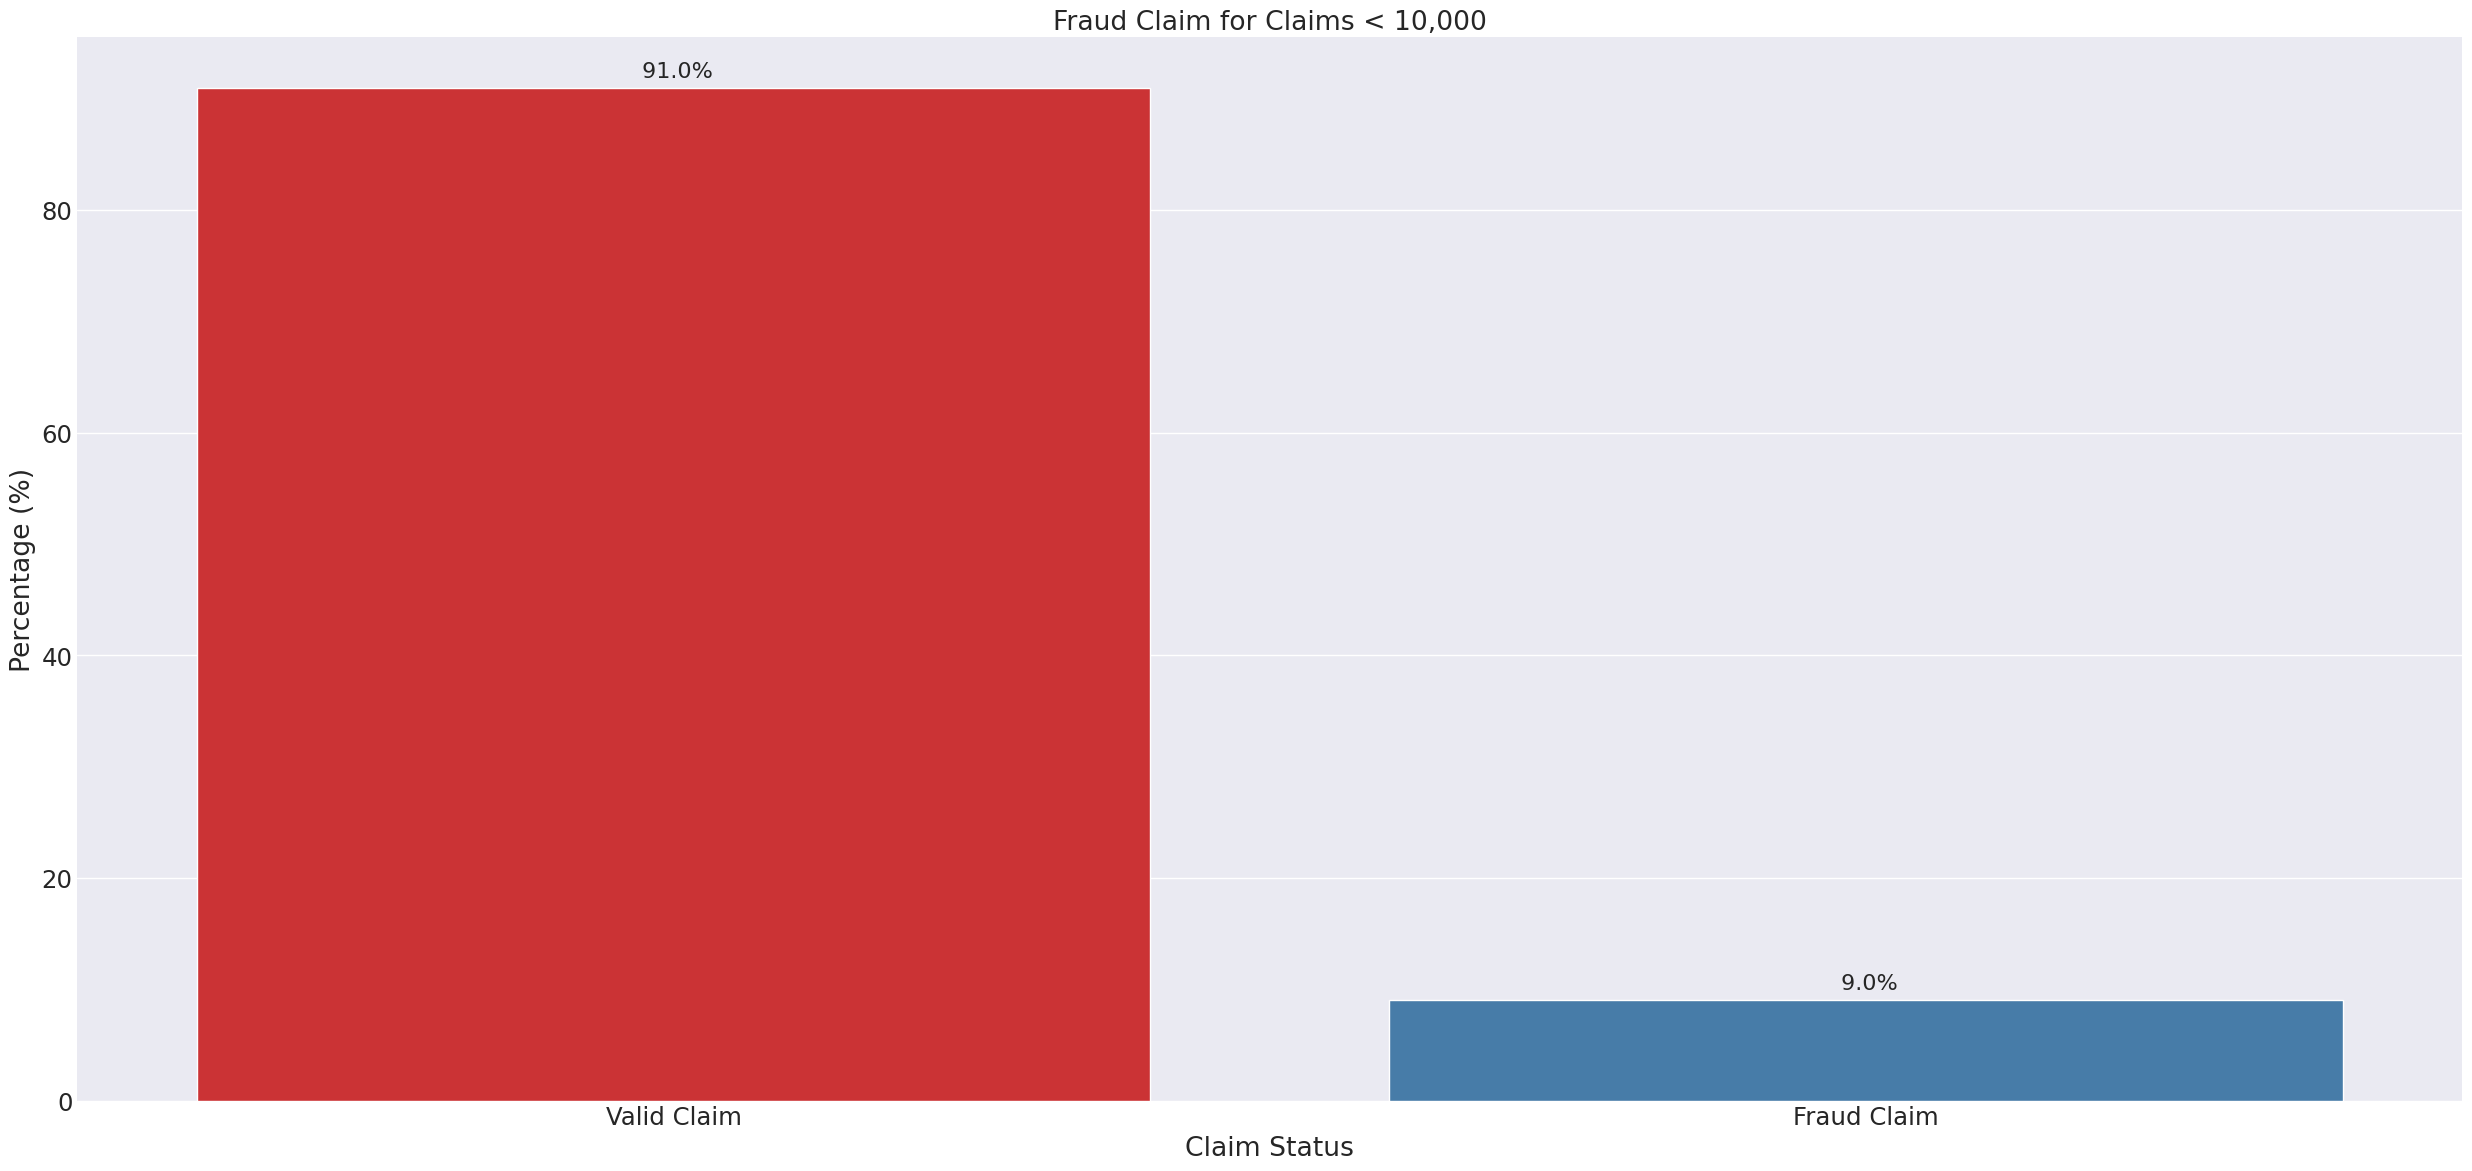

In [41]:
# Filter data
small_claims_status = df4[df4['total_claim_amount'] < 10000]

# Mengkategorikan klaim status
small_claims_status['claim_status'] = small_claims_status['fraud_reported'].apply(
    lambda x: 'Fraud Claim' if x == 'yes' else 'Valid Claim'
)

# Menghitung masing-masing status klaim
claim_status_count = small_claims_status['claim_status'].value_counts().reset_index()
claim_status_count.columns = ['claim_status', 'claim_count']

# Menghitung total klaim
total_claims = claim_status_count['claim_count'].sum()

# Menambahkan label persentase
claim_status_count['percentage'] = (claim_status_count['claim_count'] / total_claims) * 100

# Membuat plot
ax = sns.barplot(data=claim_status_count, x='claim_status', y='percentage', palette='Set1')

# Menambah label persentase
for p in ax.patches:
    height = p.get_height()
    percentage = ' {:.1f}%'.format(height)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + height + 1
    ax.annotate(percentage, (x, y), ha='center')

# Mengatur label dan judul plot
ax.set_title("Fraud Claim for Claims < 10,000")
ax.set_xlabel("Claim Status")
ax.set_ylabel("Percentage (%)")

# Menampilkan plot
plt.tight_layout()
plt.show()

#### H5. Klaim fraud lebih sering terjadi pada jam malam atau dini hari, dengan 40 % klaim yang diajukan pada waktu tersebut terbukti dipalsukan. 

##### <span style="color: red; font-weight: bold;">FALSE</span>

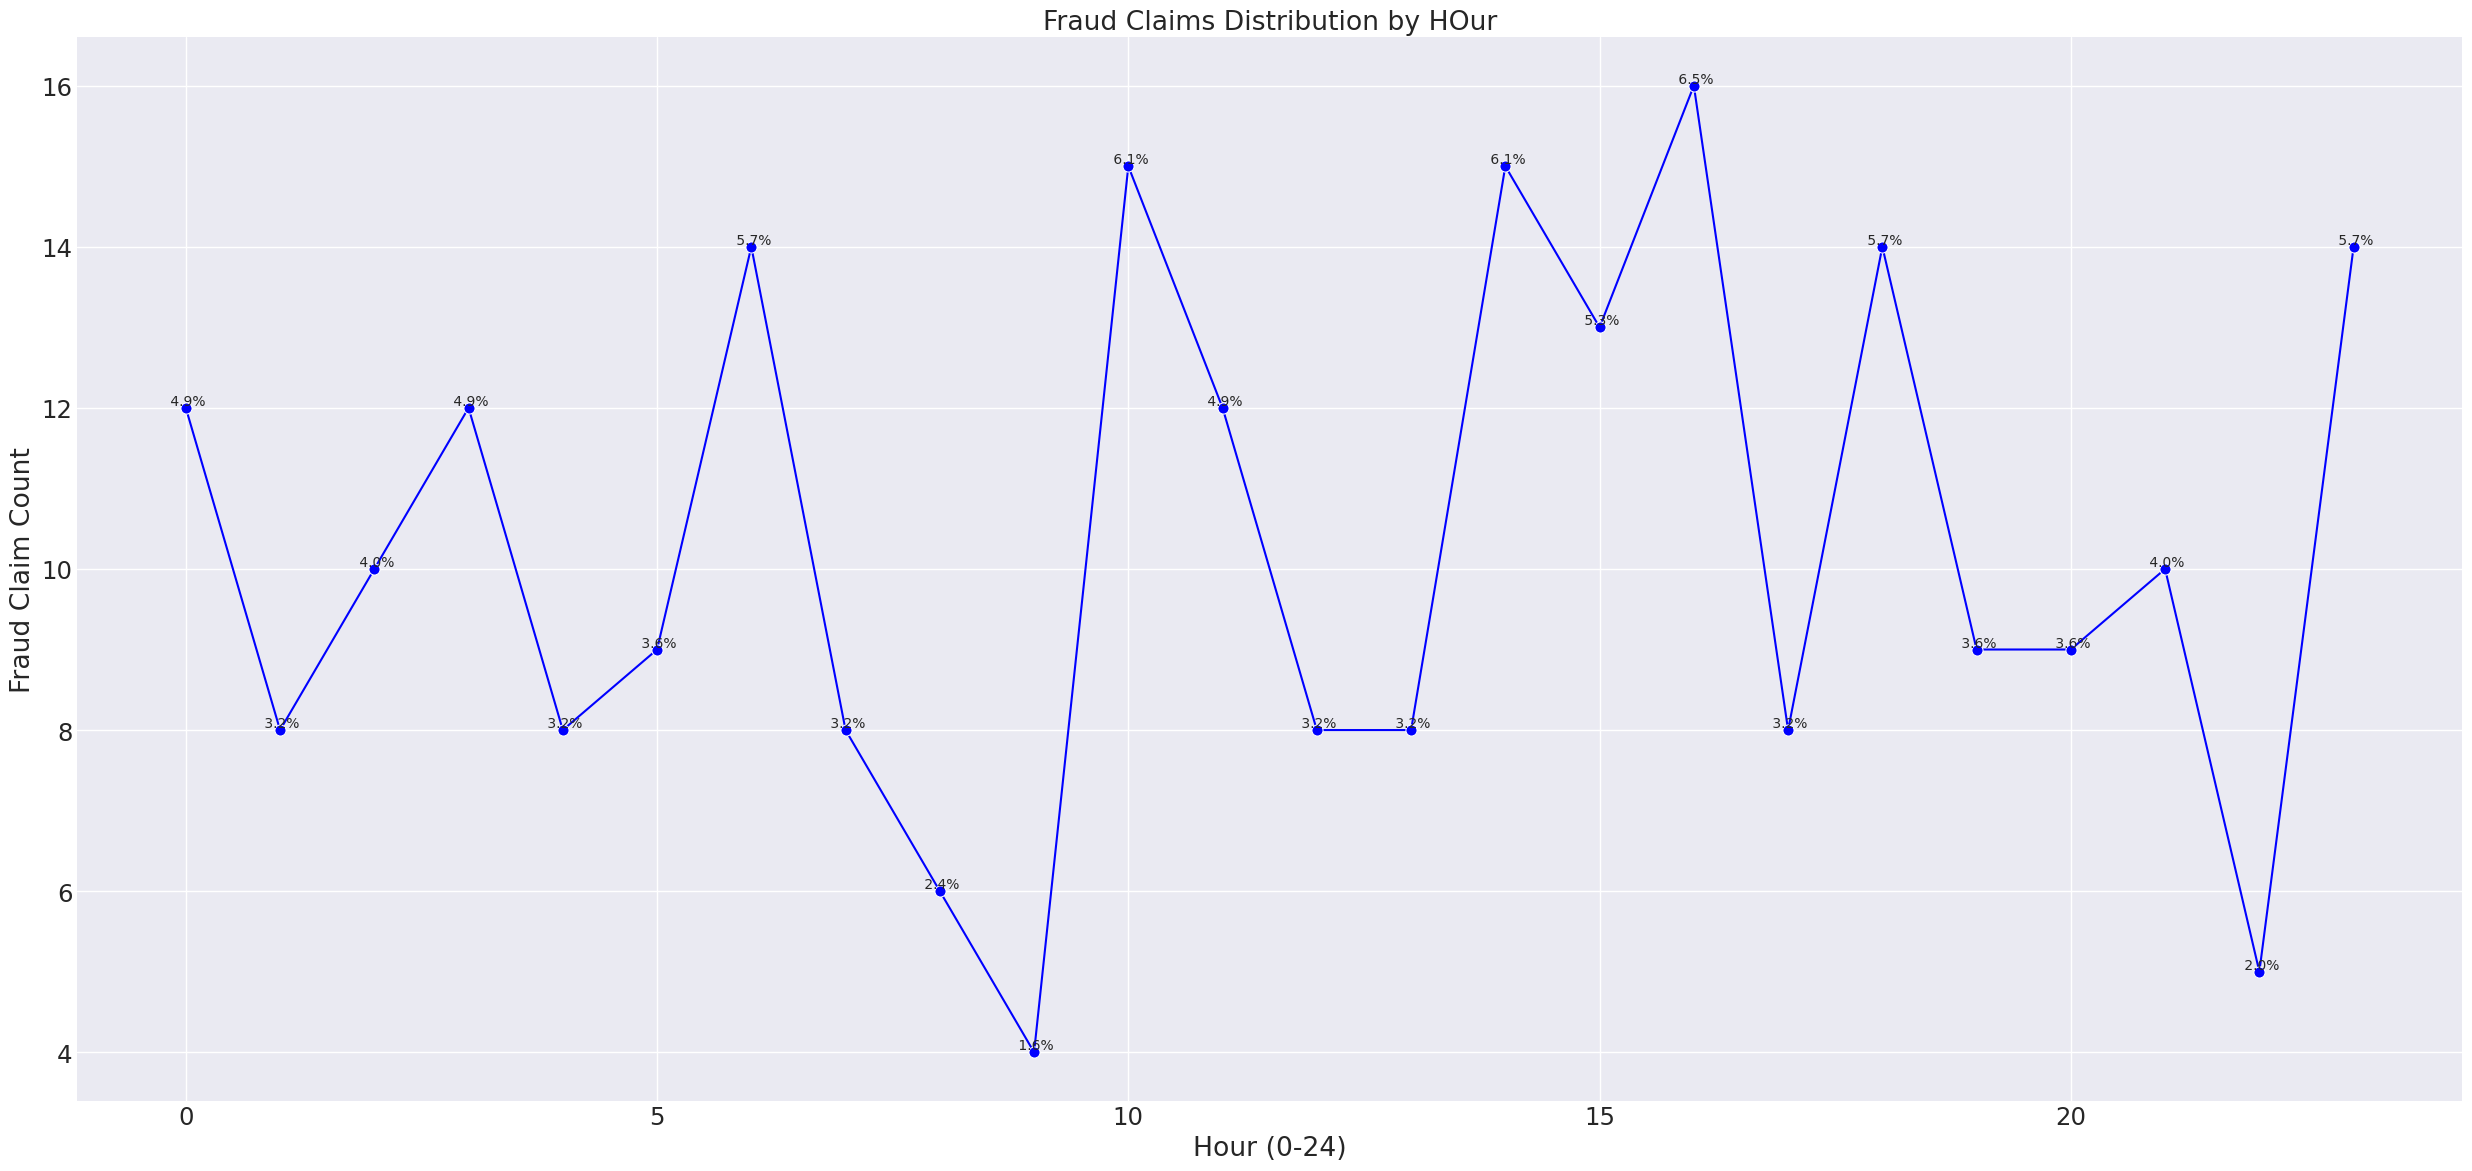

In [42]:
#Filter data
fraud_data_reported = df4[df4['fraud_reported'] == 'yes'].copy()

# Menghitung fraud berdasar jam insiden
fraud_per_hour = fraud_data_reported.groupby('incident_hour_of_the_day').size().reset_index(name='fraud_count')

# Menghitung total fraud klaim
total_fraud_claims = fraud_per_hour['fraud_count'].sum()

# Membuat lineplot
ax = sns.lineplot(data=fraud_per_hour, x='incident_hour_of_the_day', y='fraud_count', color='blue', marker='o', markersize=8)

# Menambah label persentase
for i in range(fraud_per_hour.shape[0]):
    x = fraud_per_hour['incident_hour_of_the_day'].iloc[i]
    y = fraud_per_hour['fraud_count'].iloc[i]
    percentage = ' {:.1f}%'.format(100 * y / total_fraud_claims)
    ax.text(x, y, percentage, ha='center', va='bottom', fontsize=10)

# Mengatur label dan judul plot
ax.set_title("Fraud Claims Distribution by HOur")
ax.set_xlabel("Hour (0-24)")
ax.set_ylabel("Fraud Claim Count")

# Menampilkan plot
plt.tight_layout()
plt.show()

#### H6. Kendaraan seperti chevrolet memiliki klaim fraud lebih banyak dibandingkan kendaraan honda

##### <span style="color: blue; font-weight: bold;">TRUE</span>

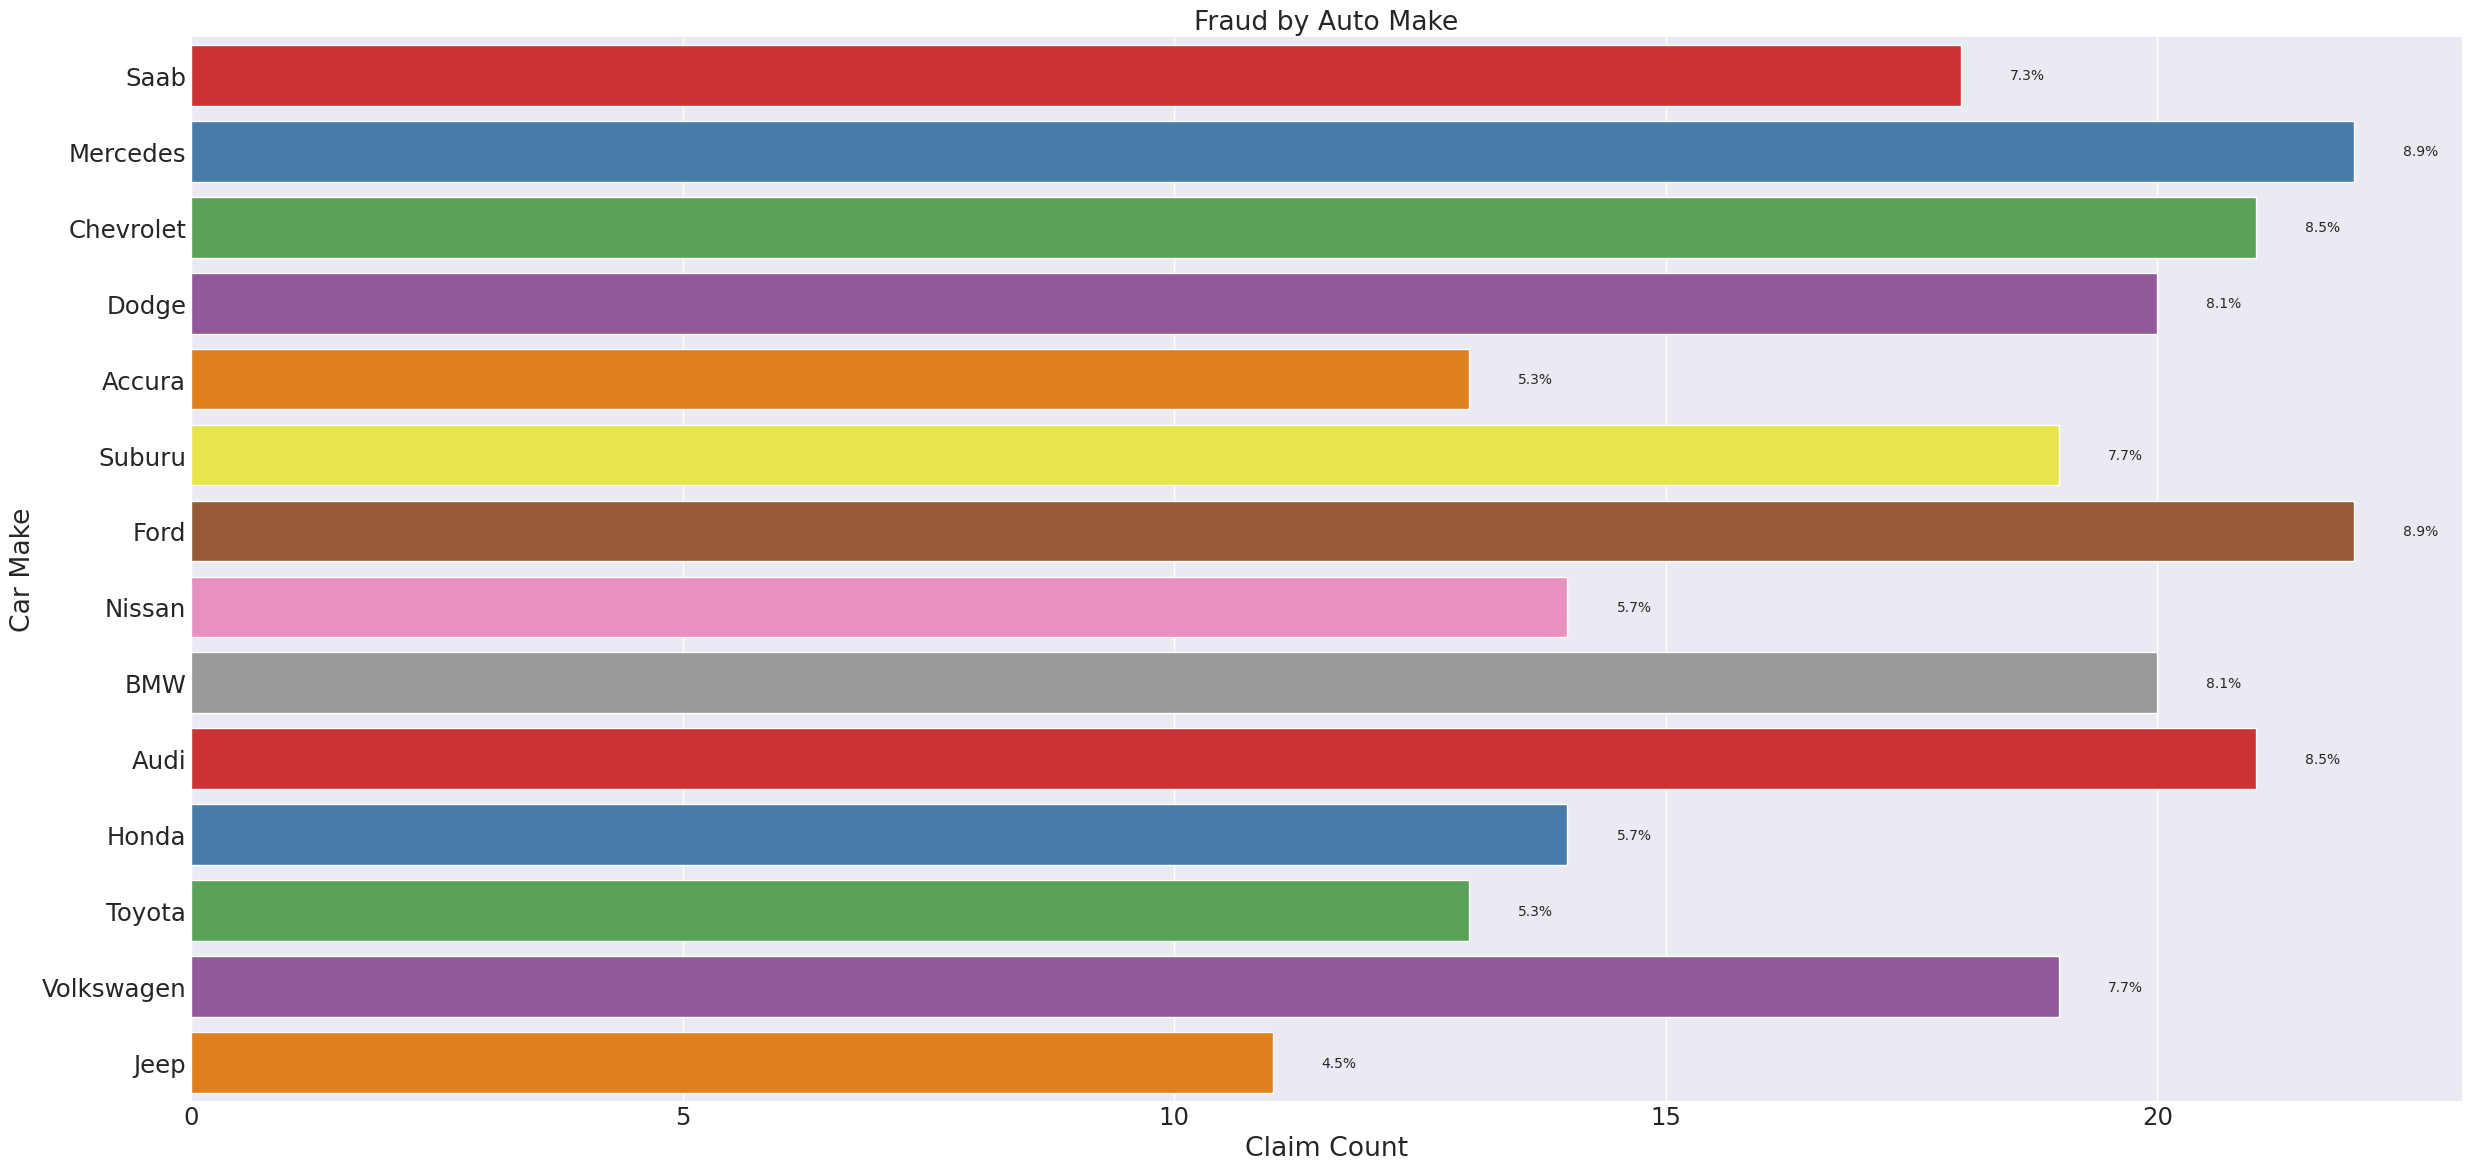

In [43]:
# Filter data
df4_fraud = df4[df4['fraud_reported'] == 'yes']

# Menghitung klaim total
total_claims = df4_fraud['auto_make'].value_counts()

# Membuat countplot
ax = sns.countplot(data=df4_fraud, y='auto_make', palette='Set1')

# Menambah label persentase
for p in ax.patches:
    width = p.get_width()
    percentage = round((width / total_claims.sum()) * 100, 1)
    ax.annotate(f'{percentage}%', (width + 0.5, p.get_y() + p.get_height() / 2),
               ha='left', va='center', fontsize = 10)

# Mengatur label dan judul plot
ax.set_title("Fraud by Auto Make")
ax.set_xlabel("Claim Count")
ax.set_ylabel("Car Make")

# Menampilkan plot
plt.tight_layout()
plt.show()

#### H7. Klaim tanpa laporan polisi lebih sering fraud sekitar 40%

##### <span style="color: red; font-weight: bold;">FALSE</span>

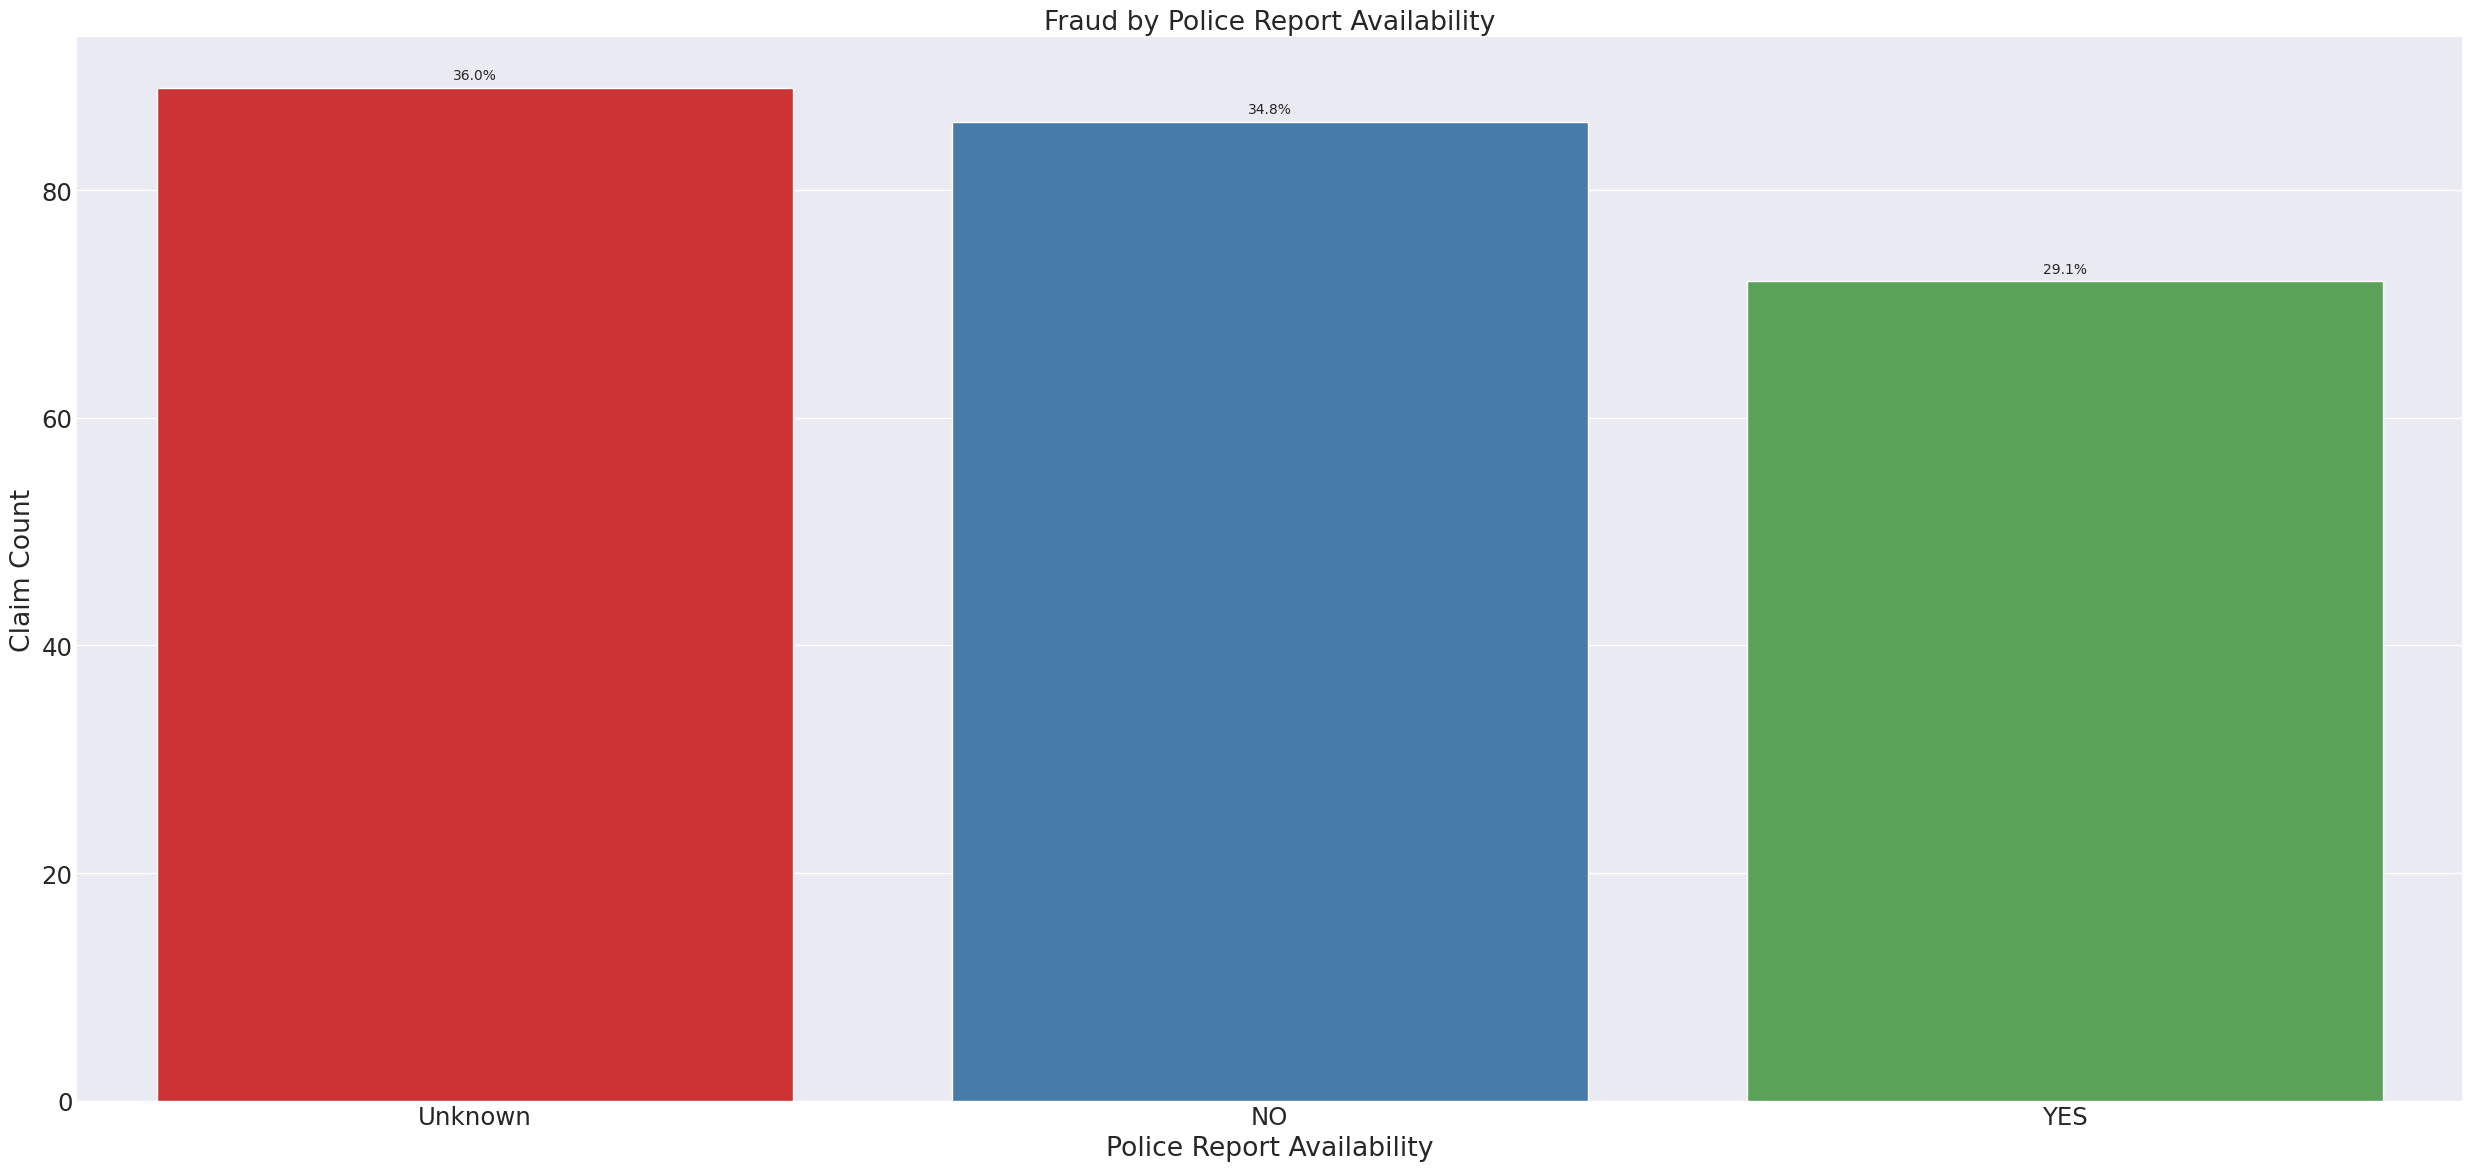

In [44]:
# Filter data
df4_data = df4[df4['fraud_reported'] == 'yes']

# Menghitung total klaim
total_claims = df4_fraud['police_report_available'].value_counts()

# Membuat countplot
ax = sns.countplot(data=df4_fraud, x='police_report_available', palette='Set1', order=total_claims.index)

# Menambahkan persentase
for p in ax.patches:
    height = p.get_height()
    percentage = round((height / total_claims.sum()) * 100, 1)
    ax.annotate(f'{percentage}%',
               (p.get_x() + p.get_width() / 2, height + 0.5),
               ha='center', va='bottom', fontsize=10)

# Mengatur label dan judul plot
ax.set_title("Fraud by Police Report Availability")
ax.set_xlabel("Police Report Availability")
ax.set_ylabel("Claim Count")

# Menampilkan plot
plt.tight_layout()
plt.show()

## 4.3 Multivariaty Analysis

### 4.3.1 Numerical Analysis

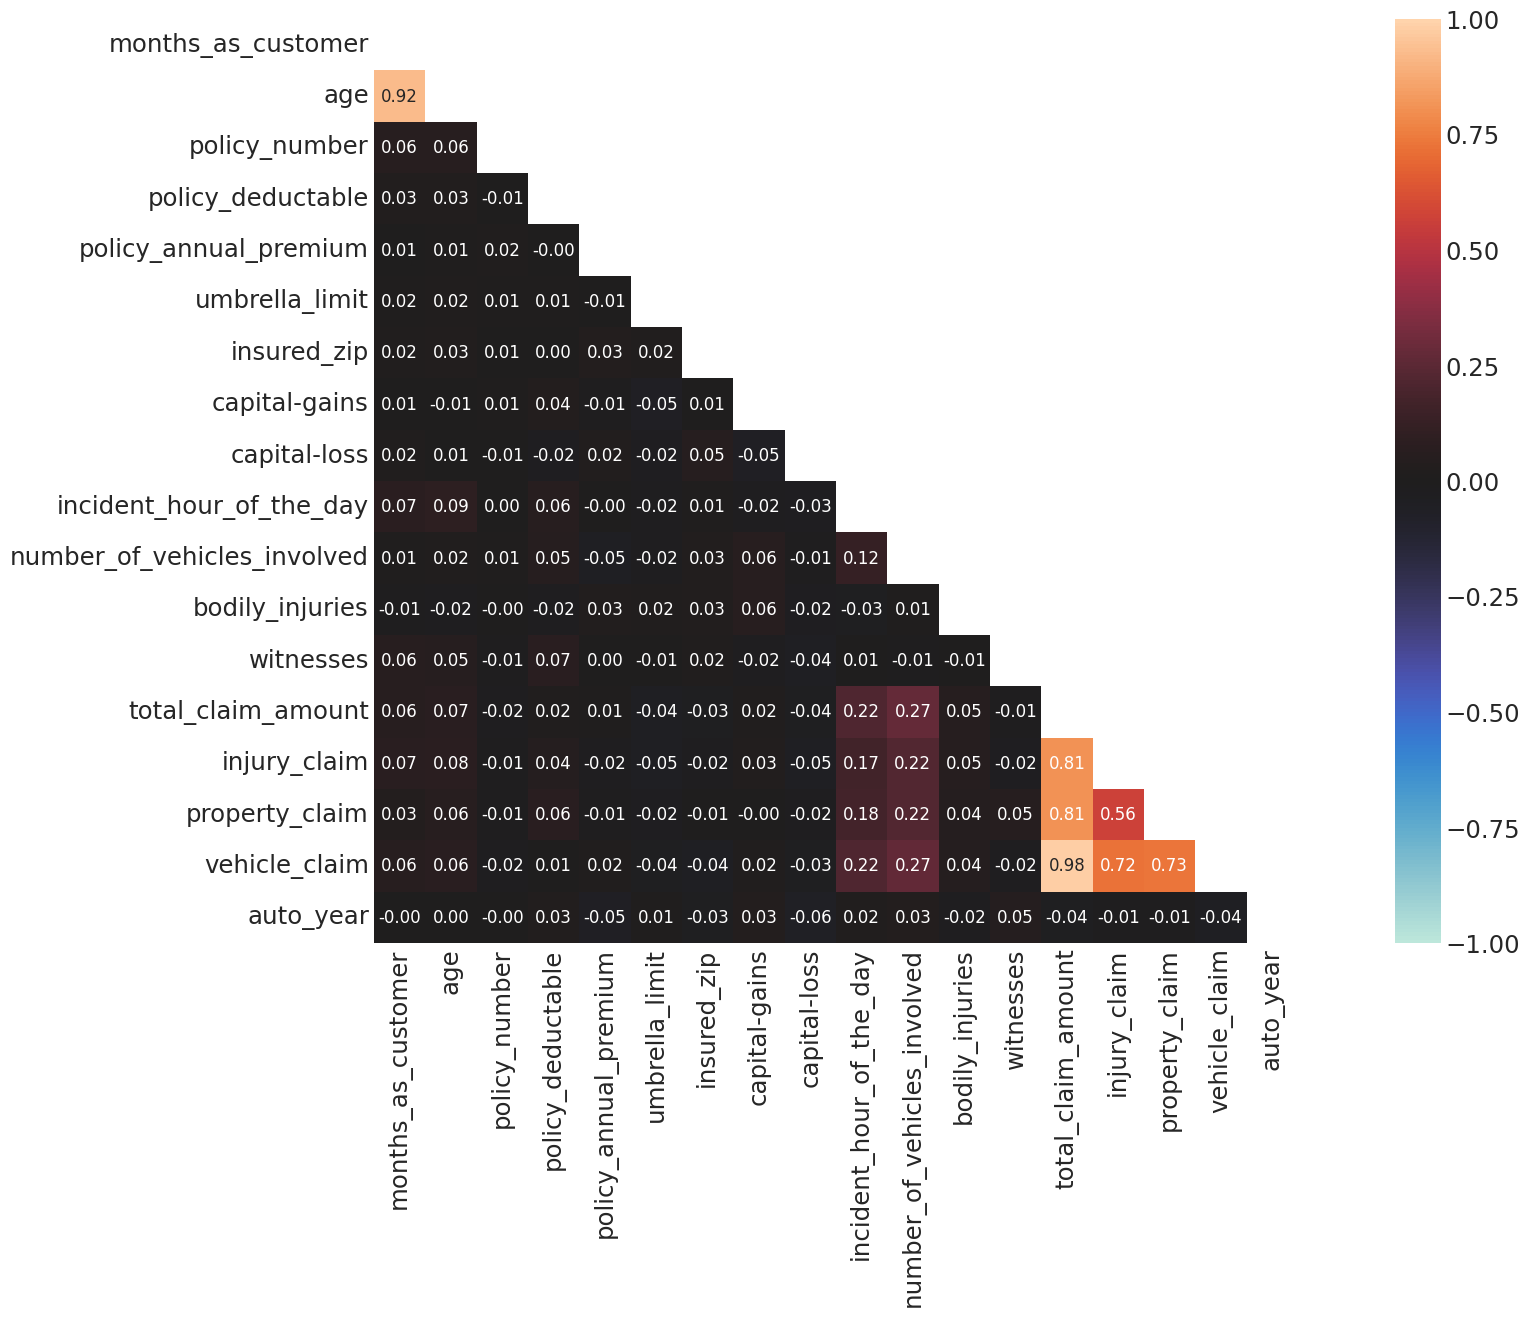

In [45]:
# Mendefinisikan numeric 
num_attributes = df4.select_dtypes(include=['number'])

# Menghitung nilai korelasi
corr = num_attributes.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Membuat heatmap
with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True, fmt='.2f', annot_kws={'size': 12})

### 4.3.2 Categorical Variables

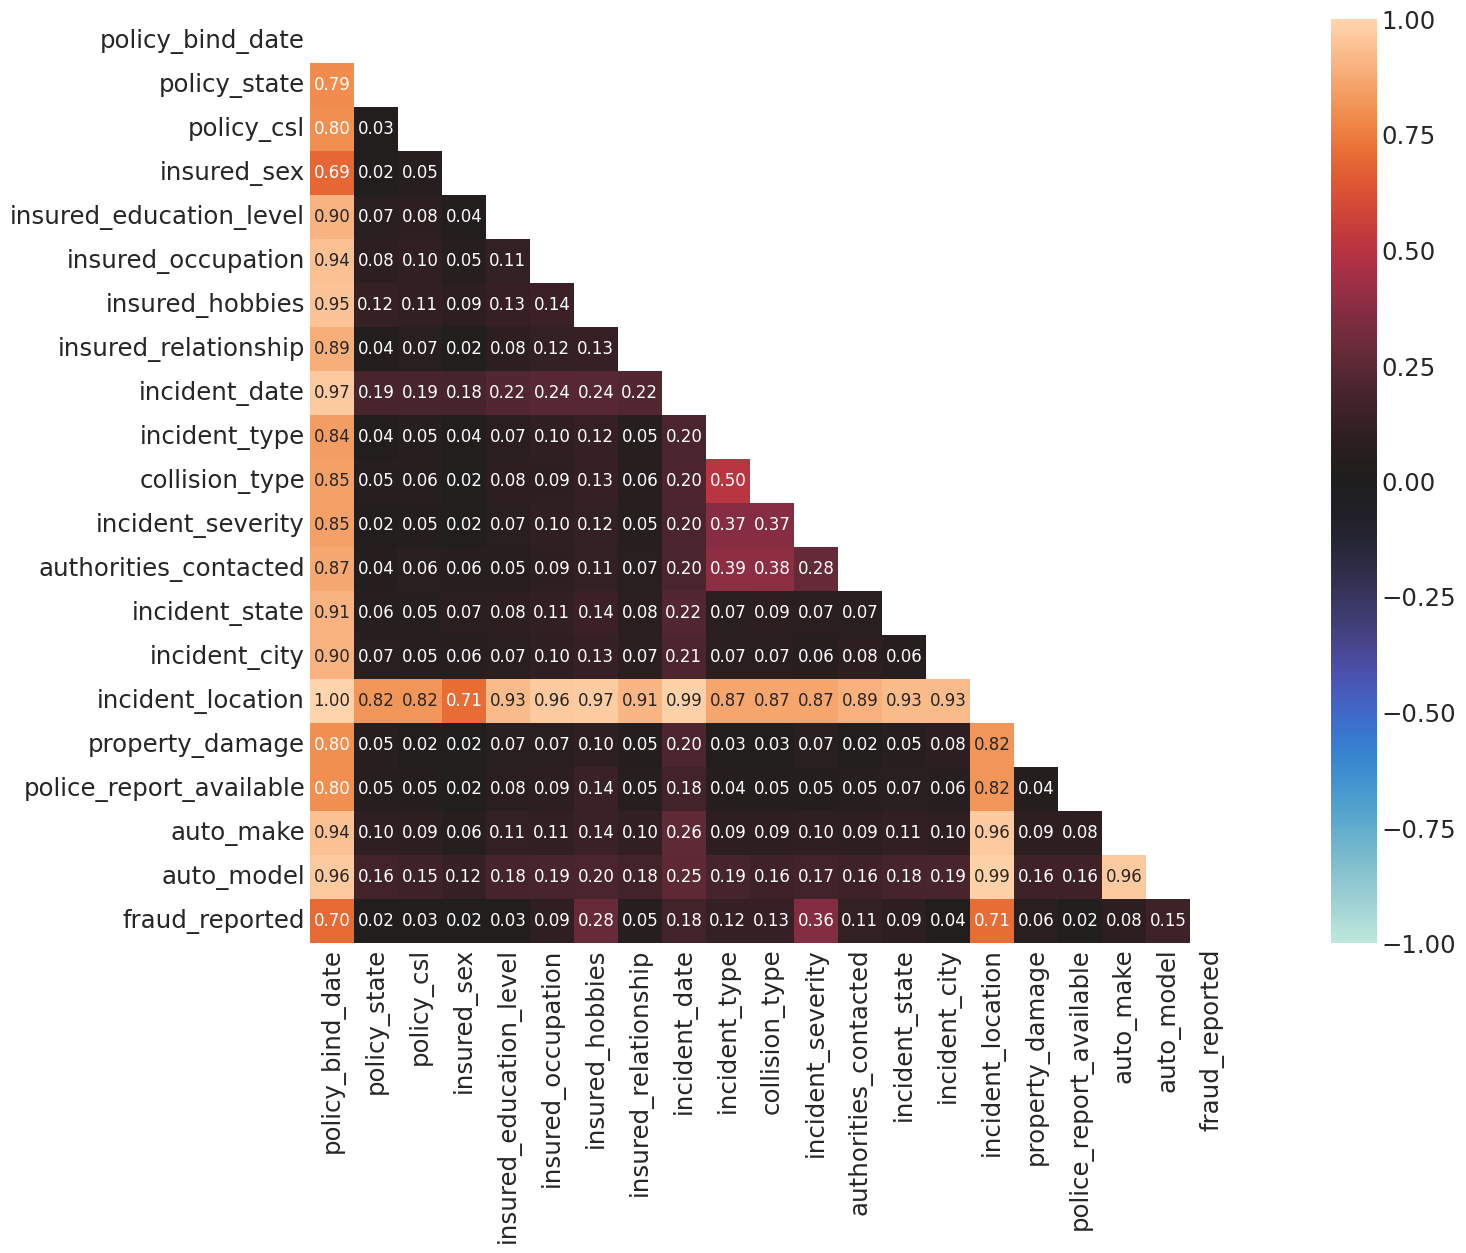

In [46]:
# Mendefinisikan cramers matrix
cramers_v_result = cramers_v_matrix(df4)

# Membuat mask
mask = np.zeros_like(cramers_v_result)
mask[np.triu_indices_from(mask)] = True

# Membuat heatmap
with sns.axes_style("white"):
    ax = sns.heatmap(cramers_v_result, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True, fmt='.2f', annot_kws={'size': 12})

# 5.0 Data Preparation

---

In [47]:
# Menyalin data
df5 = df4.copy()

## 5.1 Splitting into Train, Valid and Test

In [48]:
# Hapus beberapa kolom yang tidak diperlukan
X = df5.drop(columns=[
    'policy_csl', 'policy_bind_date', 'policy_number', 'umbrella_limit',
    'insured_zip', 'incident_date', 'insured_hobbies', 'insured_relationship',
    'capital-gains', 'capital-loss', 'incident_state', 'incident_location',
    'incident_hour_of_the_day', 'witnesses', 'injury_claim', 'property_claim',
    'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported'
], axis=1)

# Membuat target vektor, mengubah 'yes' menjadi '1' dan 'no' menjadi '0'
y = df5['fraud_reported'].map({'yes': 1, 'no': 0})

In [49]:
# Membuat training dan testing subset (training 80% testing 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [50]:
# Split training data menjadi 80% training dan 20% validasi
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

## 5.2 One Hot Encoder

In [51]:
# Inisialisasi OneHotEncoder untuk kolom-kolom kategorikal tertentu
ohe = ce.OneHotEncoder(cols=['insured_sex', 'police_report_available', 'property_damage', 'policy_state', 
    'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 
    'insured_education_level', 'insured_occupation', 'incident_city'], use_cat_names=True)

# Terapkan OneHotEncoder pada data pelatihan (X_train) dan simpan hasilnya
X_train = ohe.fit_transform(X_train)

# Terapkan OneHotEncoder pada data validasi (X_valid) tanpa fitting ulang
X_valid = ohe.transform(X_valid)

# Terapkan OneHotEncoder pada data sementara (X_temp) dan simpan hasilnya
X_temp = ohe.fit_transform(X_temp)

# Terapkan OneHotEncoder pada data uji (X_test) tanpa fitting ulang
X_test = ohe.transform(X_test)

## 5.3 Rescalling

In [52]:
# Tentukan kolom numerik yang akan diskalakan
num_columns = ['months_as_customer', 'age', 'policy_annual_premium', 'total_claim_amount', 'policy_deductable']

# Buat objek Min-Max scaler untuk melakukan normalisasi
scaler = MinMaxScaler()

# Salin data sementara untuk proses skala
X_params = X_temp.copy()

# Latih scaler pada data pelatihan dan skalakan kolom numerik
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

# Skalakan kolom numerik di data validasi menggunakan scaler yang telah dilatih pada data pelatihan
X_valid[num_columns] = scaler.transform(X_valid[num_columns])

# Skalakan kolom numerik di data sementara
X_params[num_columns] = scaler.fit_transform(X_temp[num_columns])

# Skalakan kolom numerik di data uji menggunakan scaler yang diterapkan pada data sementara
X_test[num_columns] = scaler.transform(X_test[num_columns])


# 6.0 Feature Selection

---

## 6.1 Boruta

In [53]:
 X_boruta = X_params.values
 y_boruta = y_temp.values.ravel()

In [54]:
 boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
 boruta.fit(X_boruta, y_boruta)

BorutaPy(estimator=RandomForestClassifier(n_estimators=20,
                                          random_state=RandomState(MT19937) at 0x7F3709D95F40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F3709D95F40)

### 6.1.1 Best Features

In [55]:
 cols_selected_boruta = boruta.support_.tolist()

In [56]:
 columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [57]:
 columns_selected

['incident_severity_Major Damage']

In [58]:
# Memeriksa ranking fitur
ranking = boruta.ranking_
ranking_df = pd.DataFrame({
    'Feature': X_params.columns,
    'Ranking': ranking
})
ranking_df = ranking_df.sort_values(by='Ranking')
print(ranking_df)

                                   Feature  Ranking
40          incident_severity_Major Damage        1
62                      total_claim_amount        2
6                    policy_annual_premium        3
0                       months_as_customer        4
38          incident_severity_Minor Damage        5
1                                      age        6
39            incident_severity_Total Loss        7
5                        policy_deductable        8
58                         bodily_injuries        8
54             number_of_vehicles_involved       10
34                  collision_type_Unknown       11
55                      property_damage_NO       12
36           collision_type_Rear Collision       13
32  incident_type_Single Vehicle Collision       14
57                 property_damage_Unknown       15
59              police_report_available_NO       16
47                 incident_city_Arlington       17
43         authorities_contacted_Ambulance       18
19      insu

In [59]:
# [
#     'months_as_customer', 'age', 'policy_state_IL', 'policy_state_IN', 'policy_state_OH',
#     'policy_deductable', 'policy_annual_premium', 'insured_sex_FEMALE', 'insured_sex_MALE',
#     'insured_education_level_College', 'insured_education_level_High School', 'insured_education_level_JD',
#     'insured_education_level_Masters', 'insured_education_level_MD', 'insured_education_level_PhD', 'insured_education_level_Associate',
#     'insured_occupation_adm-clerical', 'insured_occupation_armed-forces', 'insured_occupation_craft-repair', 'insured_occupation_exec-managerial', 
#     'insured_occupation_farming-fishing', 'insured_occupation_handlers-cleaners', 'insured_occupation_machine-op-inspct', 'insured_occupation_other-service', 
#     'insured_occupation_priv-house-serv', 'insured_occupation_prof-specialty', 'insured_occupation_protective-serv', 'insured_occupation_sales', 
#     'insured_occupation_tech-support', 'insured_occupation_transport-moving', 'incident_type_Multi-vehicle Collision', 'incident_type_Parked Car', 
#     'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'collision_type_Front Collision', 'collision_type_Rear Collision', 
#     'collision_type_Side Collision', 'collision_type_Unknown', 'incident_severity_Major Damage', 'incident_severity_Minor Damage', 
#     'incident_severity_Total Loss', 'incident_severity_Trivial Damage', 'authorities_contacted_Ambulance', 'authorities_contacted_Fire', 
#     'authorities_contacted_0', 'authorities_contacted_Other', 'authorities_contacted_Police', 'incident_city_Arlington', 
#     'incident_city_Columbus', 'incident_city_Hillsdale', 'incident_city_Northbend', 'incident_city_Northbrook', 
#     'incident_city_Riverwood', 'incident_city_Springfield', 'number_of_vehicles_involved', 'property_damage_NO', 
#     'property_damage_Unknown', 'property_damage_YES', 'bodily_injuries', 'police_report_available_NO', 
#     'police_report_available_Unknown', 'police_report_available_YES', 'total_claim_amount'     
# ]

In [60]:
# final_columns_selected = [
#     'months_as_customer', 'age', 'policy_state_IL', 'policy_state_IN', 'policy_state_OH',
#     'policy_deductable', 'policy_annual_premium', 'insured_sex_FEMALE', 'insured_sex_MALE',
#     'insured_education_level_College', 'insured_education_level_High School', 'insured_education_level_JD',
#     'insured_education_level_Masters', 'insured_education_level_MD', 'insured_education_level_PhD', 'insured_education_level_Associate',
#     'insured_occupation_adm-clerical', 'insured_occupation_armed-forces', 'insured_occupation_craft-repair', 'insured_occupation_exec-managerial', 
#     'insured_occupation_farming-fishing', 'insured_occupation_handlers-cleaners', 'insured_occupation_machine-op-inspct', 'insured_occupation_other-service', 
#     'insured_occupation_priv-house-serv', 'insured_occupation_prof-specialty', 'insured_occupation_protective-serv', 'insured_occupation_sales', 
#     'insured_occupation_tech-support', 'insured_occupation_transport-moving', 'incident_type_Multi-vehicle Collision', 'incident_type_Parked Car', 
#     'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'collision_type_Front Collision', 'collision_type_Rear Collision', 
#     'collision_type_Side Collision', 'collision_type_Unknown', 'incident_severity_Major Damage', 'incident_severity_Minor Damage', 
#     'incident_severity_Total Loss', 'incident_severity_Trivial Damage', 'authorities_contacted_Ambulance', 'authorities_contacted_Fire', 
#     'authorities_contacted_0', 'authorities_contacted_Other', 'authorities_contacted_Police', 'incident_city_Arlington', 
#     'incident_city_Columbus', 'incident_city_Hillsdale', 'incident_city_Northbend', 'incident_city_Northbrook', 
#     'incident_city_Riverwood', 'incident_city_Springfield', 'number_of_vehicles_involved', 'property_damage_NO', 
#     'property_damage_Unknown', 'property_damage_YES', 'bodily_injuries', 'police_report_available_NO', 
#     'police_report_available_Unknown', 'police_report_available_YES', 'total_claim_amount'     
# ]


In [61]:
 final_columns_selected = [
     'months_as_customer', 'age', 'policy_state_IL', 'policy_state_IN', 'policy_state_OH',
     'policy_deductable', 'policy_annual_premium', 'insured_sex_FEMALE', 'insured_sex_MALE',
     'insured_education_level_College', 'insured_education_level_High School', 'insured_education_level_JD',
     'insured_education_level_Masters', 'insured_education_level_MD', 'insured_education_level_PhD', 'insured_education_level_Associate',
     'collision_type_Front Collision', 'collision_type_Rear Collision', 
     'collision_type_Side Collision', 'collision_type_Unknown', 'incident_severity_Major Damage', 'incident_severity_Minor Damage', 
     'incident_severity_Total Loss', 'incident_severity_Trivial Damage', 'authorities_contacted_Ambulance', 'authorities_contacted_Fire', 
     'authorities_contacted_0', 'authorities_contacted_Other', 'authorities_contacted_Police', 
     'number_of_vehicles_involved', 'property_damage_NO', 
     'property_damage_Unknown', 'property_damage_YES', 'bodily_injuries', 'police_report_available_NO', 
     'police_report_available_Unknown', 'police_report_available_YES', 'total_claim_amount'     
 ]


# 7.0 Machine Learning Modeling

---

In [62]:
# Memilih kolom yang dipilih dari dataframe
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

## 7.1 Baseline

In [63]:
# Inisialisasi DummyClassifier dengan strategi 'stratified' (membuat prediksi acak berdasarkan distribusi kelas)
dummy = DummyClassifier(strategy='stratified')

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_cs, y_train)

# Latih model DummyClassifier menggunakan data pelatihan
dummy.fit(X_train_res, y_train_res)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model DummyClassifier
y_pred_dummy = dummy.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_dummy = dummy.predict_proba(X_valid_cs)[:, 1]

In [64]:
# Menghitung skor evaluasi model DummyClassifier menggunakan fungsi ml_scores
dummy_results = ml_scores('dummy', 'Imbalanced_Classification', y_valid, y_pred_dummy, y_pred_prob_dummy)

# Menampilkan hasil evaluasi model DummyClassifier
dummy_results

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
dummy              0.533      0.271    0.65          0.382   0.465  0.045  0.059

### 7.1.1 Classification Report

In [65]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_dummy))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.78      0.42      0.65      0.54      0.52      0.26       120
          1       0.27      0.65      0.42      0.38      0.52      0.28        40

avg / total       0.65      0.47      0.59      0.50      0.52      0.27       160



### 7.1.2 Cross Validation

In [66]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
dummy_cv = ml_cv_results('dummy', 'Imbalanced_Classification', dummy, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


Balanced Accuracy        Precision           Recall    F1 Minorities          AUC-PR            Kappa              MCC
dummy   0.512 +/- 0.029  0.262 +/- 0.044  0.287 +/- 0.071  0.273 +/- 0.052  0.32 +/- 0.055  0.022 +/- 0.058  0.022 +/- 0.058

### 7.1.3 Precision-Recall Curve

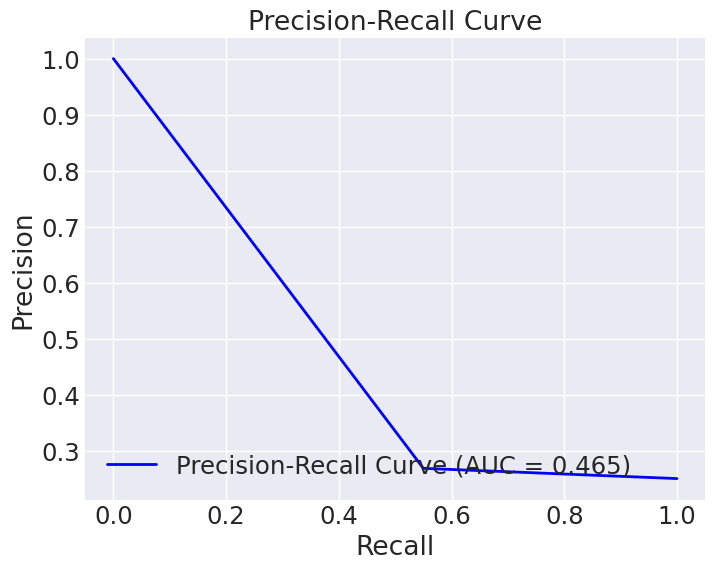

In [67]:
# Membuat plot precision-recall dengan plot_ml
dummy_plot = plot_ml(X_valid_cs, y_valid, y_pred_dummy, y_pred_prob_dummy, 'Imbalanced_Classification', 'Precision-Recall', dummy)

# Menampilkan hasil plot
dummy_plot

## 7.2 Logistic Regression

In [68]:
# Inisialisasi Logistic Regression 
lg = LogisticRegression(class_weight='balanced')

# Latih model Logistic Regression menggunakan data pelatihan
lg.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model Logistic Regression
y_pred_lg = lg.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_lg = lg.predict_proba(X_valid_cs)[:, 1]

In [69]:
# Menghitung skor evaluasi model Logistic Regression menggunakan fungsi ml_scores
lg_results = ml_scores('Logistic Regression', 'Imbalanced_Classification', y_valid, y_pred_lg, y_pred_prob_lg)

# Menampilkan hasil evaluasi model Logistic Regression
lg_results

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
Logistic Regression              0.721      0.558     0.6          0.578   0.526  0.431  0.431

### 7.2.1 Classification Report

In [70]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_lg))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.84      0.60      0.85      0.71      0.52       120
          1       0.56      0.60      0.84      0.58      0.71      0.49        40

avg / total       0.79      0.78      0.66      0.78      0.71      0.51       160



### 7.2.2 Cross Validation

In [71]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
lg_cv = ml_cv_results('Logistic Regression', 'Imbalanced_Classification', lg, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


Balanced Accuracy        Precision          Recall    F1 Minorities           AUC-PR            Kappa              MCC
Logistic Regression   0.745 +/- 0.031  0.564 +/- 0.077  0.667 +/- 0.05  0.608 +/- 0.048  0.529 +/- 0.087  0.462 +/- 0.074  0.468 +/- 0.071

### 7.2.3 Precision-Recall Curve

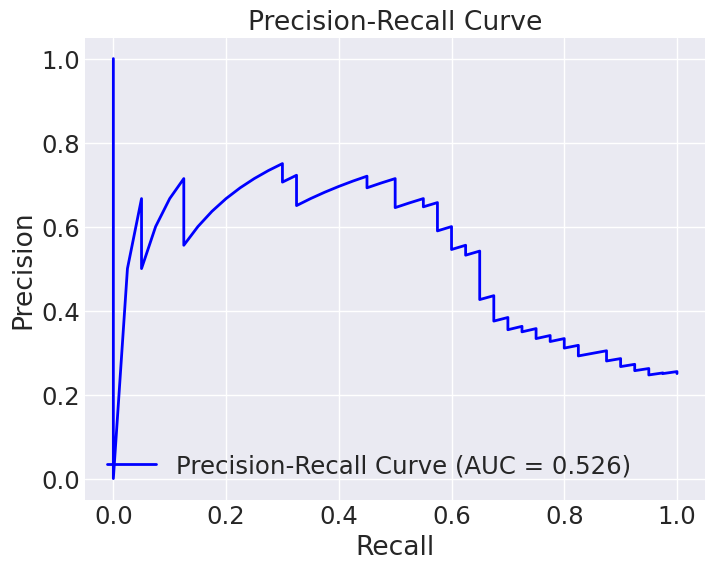

In [72]:
# Membuat plot precision-recall dengan plot_ml
lg_plot = plot_ml(X_valid_cs, y_valid, y_pred_lg, y_pred_prob_lg, 'Imbalanced_Classification', 'Precision-Recall', lg)

# Menampilkan hasil plot
lg_plot

## 7.3 K Nearest Neighbors

In [73]:
# Inisialisasi K Nearest Neighbors 
knn = KNeighborsClassifier()

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_cs, y_train)

# Latih model K Nearest Neighbors menggunakan data pelatihan
knn.fit(X_train_res, y_train_res)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model K Nearest Neighbors
y_pred_knn = knn.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_knn = knn.predict_proba(X_valid_cs)[:, 1]

In [74]:
# Menghitung skor evaluasi model K Nearest Neighbors menggunakan fungsi ml_scores
knn_results = ml_scores('K Nearest Neighbors', 'Imbalanced_Classification', y_valid, y_pred_knn, y_pred_prob_knn)

# Menampilkan hasil evaluasi model Logistic Regression
knn_results

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
K Nearest Neighbors              0.633      0.368   0.625          0.463   0.405  0.216  0.234

### 7.3.1 Classification Report

In [75]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_knn))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.64      0.62      0.73      0.63      0.40       120
          1       0.37      0.62      0.64      0.46      0.63      0.40        40

avg / total       0.72      0.64      0.63      0.66      0.63      0.40       160



### 7.3.2 Cross Validation

In [76]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
knn_cv = ml_cv_results('K Nearest Neighbors', 'Imbalanced_Classification', knn, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


Balanced Accuracy       Precision           Recall    F1 Minorities           AUC-PR           Kappa              MCC
K Nearest Neighbors   0.648 +/- 0.037  0.62 +/- 0.102  0.374 +/- 0.068  0.463 +/- 0.071  0.493 +/- 0.111  0.34 +/- 0.084  0.359 +/- 0.088

### 7.3.3 Precision-Recall Curve

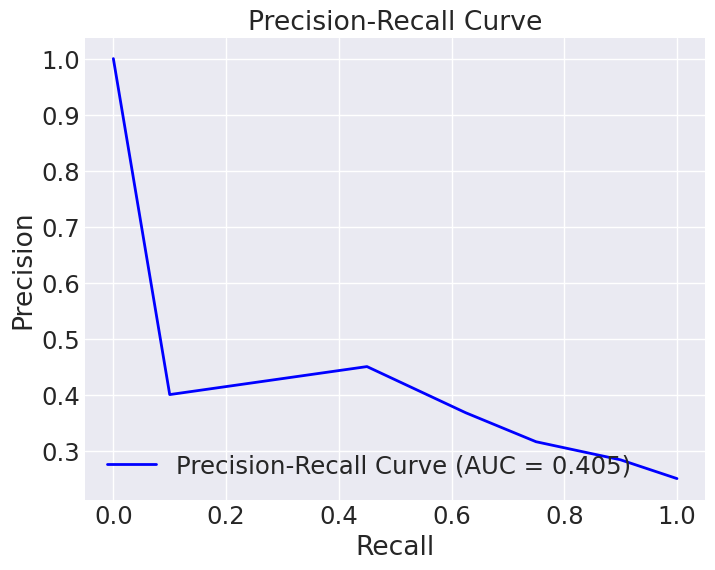

In [77]:
# Membuat plot precision-recall dengan plot_ml
knn_plot = plot_ml(X_valid_cs, y_valid, y_pred_knn, y_pred_prob_knn, 'Imbalanced_Classification', 'Precision-Recall', knn)

# Menampilkan hasil plot
knn_plot

## 7.4 Support Vector Machine

In [78]:
# Inisialisasi Support Vector Machine 
svm = SVC(class_weight='balanced', probability=True)

# Latih model Support Vector Machine menggunakan data pelatihan
svm.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model Support Vector Machine
y_pred_svm = svm.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_svm = svm.predict_proba(X_valid_cs)[:, 1]

In [79]:
# Menghitung skor evaluasi model Support Vector Machine menggunakan fungsi ml_scores
svm_results = ml_scores('SVM', 'Imbalanced_Classification', y_valid, y_pred_svm, y_pred_prob_svm)

# Menampilkan hasil evaluasi model Support Vector Machine
svm_results

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
SVM              0.758      0.658   0.625          0.641   0.499  0.525  0.526

### 7.4.1 Classification Report

In [80]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_svm))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.89      0.62      0.88      0.75      0.57       120
          1       0.66      0.62      0.89      0.64      0.75      0.54        40

avg / total       0.82      0.82      0.69      0.82      0.75      0.56       160



### 7.4.2 Cross Validation

In [81]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
svm_cv = ml_cv_results('SVM', 'Imbalanced_Classification', svm, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


Balanced Accuracy        Precision           Recall    F1 Minorities           AUC-PR            Kappa              MCC
SVM    0.758 +/- 0.03  0.602 +/- 0.058  0.662 +/- 0.051  0.629 +/- 0.043  0.506 +/- 0.057  0.499 +/- 0.061  0.501 +/- 0.061

### 7.4.3 Precision-Recall Curve

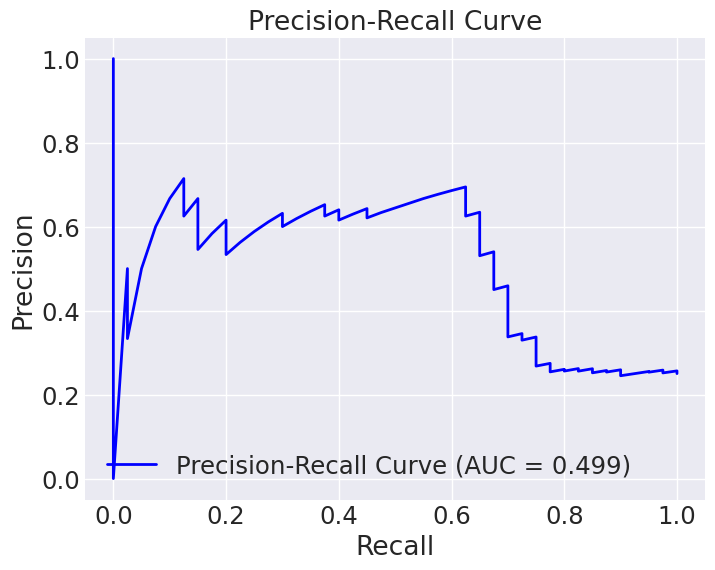

In [82]:
# Membuat plot precision-recall dengan plot_ml
svm_plot = plot_ml(X_valid_cs, y_valid, y_pred_svm, y_pred_prob_svm, 'Imbalanced_Classification', 'Precision-Recall', svm)

# Menampilkan hasil plot
svm_plot

## 7.5 Random Forest

In [83]:
# Inisialisasi Random Forest 
rf = RandomForestClassifier(class_weight='balanced')

# Latih model Random Forest menggunakan data pelatihan
rf.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model Random Forest
y_pred_rf = rf.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_rf = rf.predict_proba(X_valid_cs)[:, 1]

In [84]:
# Menghitung skor evaluasi model Random Forest menggunakan fungsi ml_scores
rf_results = ml_scores('Random Forest', 'Imbalanced_Classification', y_valid, y_pred_rf, y_pred_prob_rf)

# Menampilkan hasil evaluasi model Support Vector Machine
rf_results

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
Random Forest               0.65      0.625   0.375          0.469   0.535  0.346  0.364

### 7.5.1 Classification Report

In [85]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.93      0.38      0.87      0.59      0.37       120
          1       0.62      0.38      0.93      0.47      0.59      0.33        40

avg / total       0.77      0.79      0.51      0.77      0.59      0.36       160



### 7.5.2 Cross Validation

In [86]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
rf_cv = ml_cv_results('Random Forest', 'Imbalanced_Classification', rf, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


Balanced Accuracy      Precision           Recall    F1 Minorities           AUC-PR            Kappa             MCC
Random Forest   0.617 +/- 0.019  0.561 +/- 0.1  0.323 +/- 0.032  0.406 +/- 0.033  0.475 +/- 0.081  0.272 +/- 0.051  0.29 +/- 0.063

### 7.5.3 Precision-Recall Curve

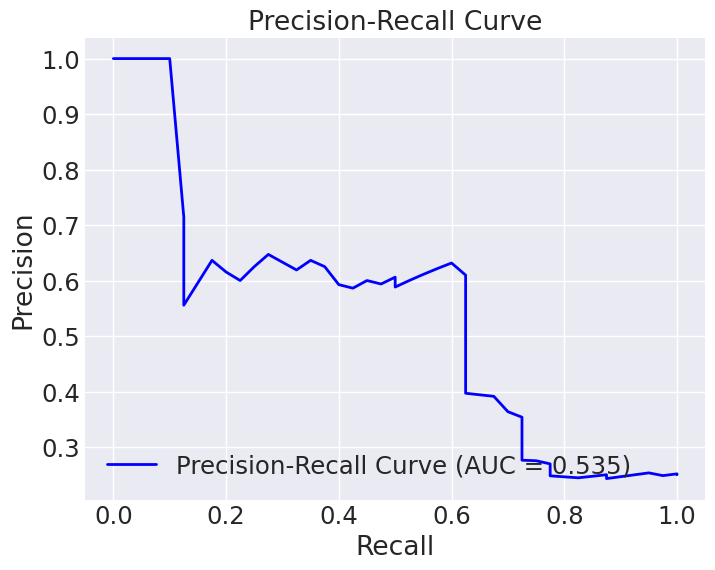

In [87]:
# Membuat plot precision-recall dengan plot_ml
rf_plot = plot_ml(X_valid_cs, y_valid, y_pred_rf, y_pred_prob_rf, 'Imbalanced_Classification', 'Precision-Recall', rf)

# Menampilkan hasil plot
rf_plot

## 7.6 XGBoost

In [88]:
# Inisialisasi XGBoost 
xgb = XGBClassifier(class_weight='balanced')

# Latih model XGBoost menggunakan data pelatihan
xgb.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model XGBoost
y_pred_xgb = xgb.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_xgb = xgb.predict_proba(X_valid_cs)[:, 1]

In [89]:
# Menghitung skor evaluasi model XGBoost menggunakan fungsi ml_scores
xgb_results = ml_scores('XGBoost', 'Imbalanced_Classification', y_valid, y_pred_xgb, y_pred_prob_xgb)

# Menampilkan hasil evaluasi model Support Vector Machine
xgb_results

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
XGBoost              0.621      0.519    0.35          0.418   0.396  0.271  0.279

### 7.6.1 Classification Report

In [90]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_xgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.89      0.35      0.85      0.56      0.33       120
          1       0.52      0.35      0.89      0.42      0.56      0.30        40

avg / total       0.73      0.76      0.49      0.74      0.56      0.32       160



### 7.6.2 Cross Validation

In [91]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
xgb_cv = ml_cv_results('XGBoost', 'Imbalanced_Classification', xgb, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


Balanced Accuracy       Precision           Recall    F1 Minorities           AUC-PR            Kappa              MCC
XGBoost   0.641 +/- 0.051  0.542 +/- 0.11  0.394 +/- 0.072  0.456 +/- 0.086  0.471 +/- 0.062  0.312 +/- 0.113  0.318 +/- 0.116

### 7.6.3 Precision-Recall Curve

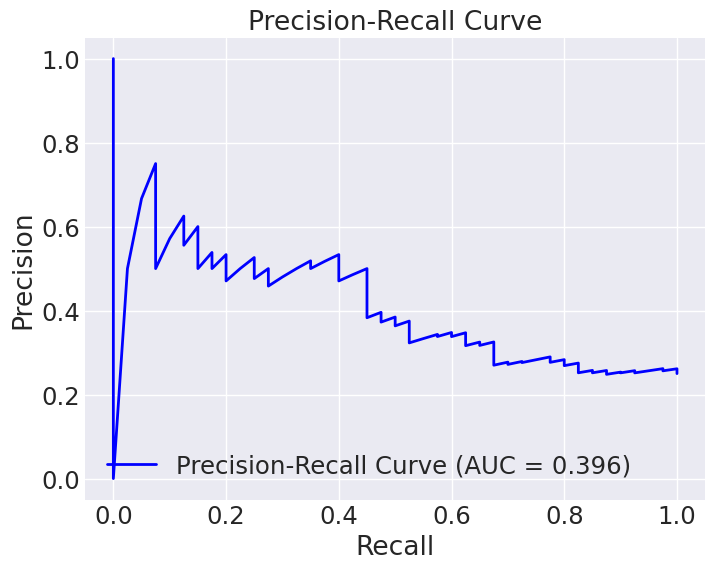

In [92]:
# Membuat plot precision-recall dengan plot_ml
xgb_plot = plot_ml(X_valid_cs, y_valid, y_pred_xgb, y_pred_prob_xgb, 'Imbalanced_Classification', 'Precision-Recall', xgb)

# Menampilkan hasil plot
xgb_plot

## 7.7 LightGBM

In [93]:
# Inisialisasi LightGBM 
lgb = LGBMClassifier(class_weight='balanced')

# Latih model LightGBM menggunakan data pelatihan
lgb.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model LightGBM
y_pred_lgb = lgb.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_lgb = lgb.predict_proba(X_valid_cs)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158, number of negative: 482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [94]:
# Menghitung skor evaluasi model LightGBM menggunakan fungsi ml_scores
lgb_results = ml_scores('LightGBM', 'Imbalanced_Classification', y_valid, y_pred_lgb, y_pred_prob_lgb)

# Menampilkan hasil evaluasi model Support Vector Machine
lgb_results

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
LightGBM              0.654      0.514    0.45           0.48   0.462  0.322  0.323

### 7.7.1 Classification Report

In [95]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_lgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.86      0.45      0.84      0.62      0.40       120
          1       0.51      0.45      0.86      0.48      0.62      0.37        40

avg / total       0.75      0.76      0.55      0.75      0.62      0.39       160



### 7.7.2 Cross Validation

In [96]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
lgb_cv = ml_cv_results('LightGBM', 'Imbalanced_Classification', lgb, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
lgb_cv

Fold K=1
[LightGBM] [Info] Number of positive: 159, number of negative: 481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Balanced Accuracy        Precision           Recall    F1 Minorities           AUC-PR            Kappa              MCC
LightGBM   0.682 +/- 0.044  0.554 +/- 0.065  0.495 +/- 0.077  0.522 +/- 0.067  0.494 +/- 0.077  0.377 +/- 0.086  0.378 +/- 0.086

### 7.7.3 Precision-Recall Curve

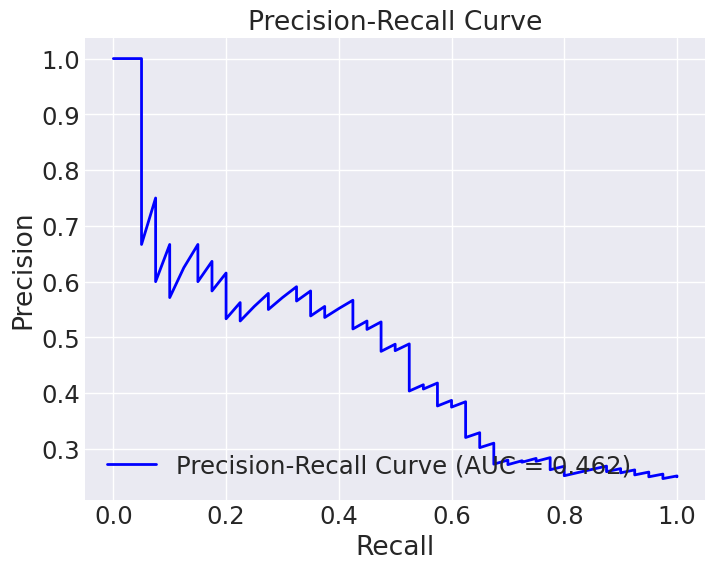

In [97]:
# Membuat plot precision-recall dengan plot_ml
lgb_plot = plot_ml(X_valid_cs, y_valid, y_pred_lgb, y_pred_prob_lgb, 'Imbalanced_Classification', 'Precision-Recall', lgb)

# Menampilkan hasil plot
lgb_plot

## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [98]:
# Penggabungan skor evaluasi
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lgb_results,
                                 svm_results])

# Mengurutkan model berdasarkan "Balanced Accuracy"
modeling_performance.sort_values(by="Balanced Accuracy", ascending=True)

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
dummy                            0.533      0.271   0.650          0.382   0.465  0.045  0.059
XGBoost                          0.621      0.519   0.350          0.418   0.396  0.271  0.279
K Nearest Neighbors              0.633      0.368   0.625          0.463   0.405  0.216  0.234
Random Forest                    0.650      0.625   0.375          0.469   0.535  0.346  0.364
LightGBM                         0.654      0.514   0.450          0.480   0.462  0.322  0.323
Logistic Regression              0.721      0.558   0.600          0.578   0.526  0.431  0.431
SVM                              0.758      0.658   0.625          0.641   0.499  0.525  0.526

### 7.8.2 Cross Validation Performance

In [99]:
# Penggabungan skor evaluasi Cross Validation
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lgb_cv, svm_cv])

# Mengurutkan model berdasarkan "Balanced Accuracy"
modeling_performance_cv.sort_values(by="Balanced Accuracy", ascending=True)

Balanced Accuracy        Precision           Recall    F1 Minorities           AUC-PR            Kappa              MCC
dummy                 0.512 +/- 0.029  0.262 +/- 0.044  0.287 +/- 0.071  0.273 +/- 0.052   0.32 +/- 0.055  0.022 +/- 0.058  0.022 +/- 0.058
Random Forest         0.617 +/- 0.019    0.561 +/- 0.1  0.323 +/- 0.032  0.406 +/- 0.033  0.475 +/- 0.081  0.272 +/- 0.051   0.29 +/- 0.063
XGBoost               0.641 +/- 0.051   0.542 +/- 0.11  0.394 +/- 0.072  0.456 +/- 0.086  0.471 +/- 0.062  0.312 +/- 0.113  0.318 +/- 0.116
K Nearest Neighbors   0.648 +/- 0.037   0.62 +/- 0.102  0.374 +/- 0.068  0.463 +/- 0.071  0.493 +/- 0.111   0.34 +/- 0.084  0.359 +/- 0.088
LightGBM              0.682 +/- 0.044  0.554 +/- 0.065  0.495 +/- 0.077  0.522 +/- 0.067  0.494 +/- 0.077  0.377 +/- 0.086  0.378 +/- 0.086
Logistic Regression   0.745 +/- 0.031  0.564 +/- 0.077   0.667 +/- 0.05  0.608 +/- 0.048  0.529 +/- 0.087  0.462 +/- 0.074  0.468 +/- 0.071
SVM                    0.758 +/- 0.03  0.602 +/- 0.058  0.662 +/- 0.051  0.629 +/- 0.043  0.506 +/- 0.057  0.499 +/- 0.061  0.501 +/- 0.061

# 8.0 Hyperparameter Tuning

---

In [100]:
# Menginisialisasi f1. Untuk Hyperparameter Tuning akan menggunakan f1 score
f1 = make_scorer(f1_score)

In [101]:
# Mendefinisikan dictionary 'params' yang berisi kombinasi hyperparameter untuk pencarian grid search
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

In [102]:
# Membuat objek GridSearchCV untuk melakukan pencarian hyperparameter dengan cross-validation
gs = GridSearchCV(SVC(), 
                  param_grid=params, 
                  scoring=f1, 
                  cv=StratifiedKFold(n_splits=5))

# Melakukan pencarian grid search pada data pelatihan X_params_cs dan y_temp
gs.fit(X_params_cs, y_temp)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [103]:
# Mengambil parameter terbaik yang ditemukan selama proses grid search
best_params = gs.best_params_

# Menampilkan parameter terbaik yang ditemukan
best_params

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [104]:
# Menetapkan kombinasi parameter terbaik yang ditemukan selama pencarian grid search
best_params = {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

In [105]:
# Mengambil skor terbaik yang diperoleh selama proses grid search berdasarkan metrik evaluasi f1
print(gs.best_score_)

0.6283541328016604


## 8.1 Results

In [106]:
# Membuat objek SVC (Support Vector Classifier) dengan parameter terbaik yang ditemukan selama grid search
svm_gs = SVC(
    probability=True,
    kernel=best_params['kernel'],
    C=best_params['C'],
    gamma=best_params['gamma'],
    class_weight='balanced'  # untuk kasus data tidak seimbang
)

In [107]:
# Melatih (fit) model SVM yang sudah disesuaikan dengan parameter terbaik menggunakan data pelatihan
svm_gs.fit(X_train_cs, y_train)

SVC(C=1, class_weight='balanced', kernel='linear', probability=True)

In [108]:
# Menggunakan model SVM yang telah dilatih untuk memprediksi label kelas pada data validasi
y_pred_hp = svm_gs.predict(X_valid_cs)  

# Menggunakan model yang sama untuk memprediksi probabilitas kelas pada data validasi
y_pred_prob_hp = svm_gs.predict_proba(X_valid_cs)[:, 1]  

### 8.1.2 Single Results

In [109]:
# Menghitung skor metriks evaluasi
svm_gs_results = ml_scores('SVM GS', 'Imbalanced_Classification', y_valid, y_pred_hp, y_pred_prob_hp)

# Menampilkan skor evaluasi
svm_gs_results

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
SVM GS              0.758      0.658   0.625          0.641   0.592  0.525  0.526

### 8.1.3 Cross Validation

In [110]:
# Menghitung skor metriks evaluasi cross validation
svm_gs_cv = ml_cv_results('SVM GS', 'Imbalanced_Classification', svm_gs, X_temp_cs, y_temp)

# Menampilkan skor evaluasi
svm_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


Balanced Accuracy        Precision           Recall    F1 Minorities           AUC-PR            Kappa              MCC
SVM GS    0.758 +/- 0.03  0.602 +/- 0.058  0.662 +/- 0.051  0.629 +/- 0.043  0.519 +/- 0.053  0.499 +/- 0.061  0.501 +/- 0.061

# 9.0 Conclusions

---

## 9.1 Final Model

In [111]:
# Membuat objek SVC (Support Vector Classifier) dengan parameter terbaik yang telah ditemukan sebelumnya
final_model = SVC(
    probability=True,  
    kernel=best_params['kernel'],
    C=best_params['C'], 
    gamma=best_params['gamma'],
    class_weight='balanced'  # Menyesuaikan bobot kelas untuk menangani ketidakseimbangan kelas dalam dataset
)

# Melatih (fit) model dengan data pelatihan X_params_cs dan label y_temp
final_model.fit(X_params_cs, y_temp)

SVC(C=1, class_weight='balanced', kernel='linear', probability=True)

### 9.1.1 Unseen Data Score

In [112]:
# Menggunakan model SVC yang telah dilatih untuk memprediksi label kelas pada data uji
y_pred_unseen = final_model.predict(X_test_cs)

# Menggunakan model yang sama untuk memprediksi probabilitas kelas pada data uji
y_pred_prob_unseen = final_model.predict_proba(X_test_cs)[:, 1]

In [113]:
# Menghitung skor metriks evaluasi
unseen_scores = ml_scores('unseen', 'Imbalanced_Classification', y_test, y_pred_unseen, y_pred_prob_unseen)

# Menampilkan skor evaluasi
unseen_scores

Balanced Accuracy  Precision  Recall  F1 Minorities  AUC-PR  Kappa    MCC
unseen              0.798      0.632   0.735          0.679   0.527  0.564  0.567

## 9.2 Blocker Fraud Company Expasion

### 9.2.1 Perusahaan menerima 15%-30% dari nilai klaim untuk setiap klaim yang terdeteksi sebagai penipuan dan benar-benar merupakan penipuan (True Positive).

In [114]:
# Membuat dataframe baru 'df_test' yang berisi data uji (test data) berdasarkan indeks dari X_test
df_test = df5.loc[X_test.index, :]

# Menambahkan kolom 'predictions' ke dalam 'df_test' yang berisi hasil prediksi model pada data uji
df_test['predictions'] = y_pred_unseen

In [115]:
# Membuat dataframe 'aux1' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'yes'
# dan kolom 'predictions' bernilai 1 (model memprediksi kasus tersebut sebagai fraud)
aux1 = df_test[(df_test['fraud_reported'] == 'yes') & (df_test['predictions'] == 1)]  

# Menghitung persentase acak antara 0.15 dan 0.30
random_percentage_1 = random.uniform(0.15, 0.30)

# Menghitung jumlah klaim berdasarkan persentase acak yang dihasilkan
receives1 = aux1['total_claim_amount'].sum() * random_percentage_1

In [116]:
print('Perusahaan dapat menerima %.2f dari transaksi penipuan yang terdeteksi dengan persentase %.2f%%.' % (receives1, random_percentage_1 * 100))

Perusahaan dapat menerima 658486.41 dari transaksi penipuan yang terdeteksi dengan persentase 29.39%.


### 9.2.2 Perusahaan menerima 2%-5% dari nilai klaim untuk setiap klaim yang terdeteksi sebagai penipuan, tetapi sebenarnya merupakan klaim yang sah.

In [117]:
# Membuat dataframe 'aux2' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'no'
# dan kolom 'predictions' bernilai 1 (model memprediksi kasus tersebut sebagai fraud)
aux2 = df_test[(df_test['fraud_reported'] == 'no') & (df_test['predictions'] == 1)]

# Menghitung persentase acak antara 0.02 dan 0.05
random_percentage_2 = random.uniform(0.02, 0.05)

# Menghitung jumlah klaim berdasarkan persentase acak yang dihasilkan
receives2 = aux2['total_claim_amount'].sum() * random_percentage_2

In [118]:
print('Untuk False Positive, perusahaan dapat menerima %.2f dari transaksi penipuan yang terdeteksi dengan persentase %.2f%%.' % (receives2, random_percentage_2 * 100))

Untuk False Positive, perusahaan dapat menerima 54370.50 dari transaksi penipuan yang terdeteksi dengan persentase 4.07%.


### 9.2.3 Perusahaan mengembalikan 100% dari nilai klaim kepada pelanggan, karena klaim tersebut sah fraud.

In [119]:
# Membuat dataframe 'aux2' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'no'
# dan kolom 'predictions' bernilai 0 
aux3 = df_test[(df_test['fraud_reported'] == 'yes') & (df_test['predictions'] == 0)]

# Menghitung jumlah klaim berdasarkan persentase acak yang dihasilkan
receives3 = aux3['total_claim_amount'].sum()

In [120]:
print('Perusahaan harus mengembalikan sejumlah of %.2f.' % (receives3))

Perusahaan harus mengembalikan sejumlah of 757650.00.


## 9.3 Model's Performance

#### 1. Berapa nilai Precision dan Accuracy dari model yang digunakan?

In [121]:
print('Untuk unseen data, nilai balanced accuracy adalah %.2f and precision adalah %.2f.' % (unseen_scores['Balanced Accuracy'], unseen_scores['Precision']))

Untuk unseen data, nilai balanced accuracy adalah 0.80 and precision adalah 0.63.


#### 2.Seberapa konsisten model dalam mengklasifikasikan klaim sebagai fraudulent atau legitimate?

In [122]:
print('Model dapat mendeteksi %.2f +/ %.2f fraud. Namun terdeteksi %.2f fraud dari unseen data.' % (float(svm_gs_cv['F1 Minorities'].apply(lambda x: float(x.split(' ')[0]))), float(svm_gs_cv['F1 Minorities'].apply(lambda x: float(x.split(' ')[2]))), unseen_scores['F1 Minorities']))

Model dapat mendeteksi 0.63 +/ 0.04 fraud. Namun terdeteksi 0.68 fraud dari unseen data.


#### 3.a. Berapa pendapatan yang diharapkan perusahaan?

In [123]:
aux1 = df_test[(df_test['fraud_reported'] == 'yes') & (df_test['predictions'] == 1)]
receives_1 = aux1['total_claim_amount'].sum() * random_percentage_1

aux2 = df_test[(df_test['fraud_reported'] == 'no') & (df_test['predictions'] == 1)]
receives_2 = aux2['total_claim_amount'].sum() * random_percentage_2

print('Dengan menggunakan model, perusahaan mendapatkan %.2f.' % (receives_1 + receives_2))

Dengan menggunakan model, perusahaan mendapatkan 712856.91.


In [124]:
aux3 = df_test[(df_test['fraud_reported'] == 'yes')]
curr_receives1 = aux3['total_claim_amount'].sum() * random_percentage_1

aux4 = df_test[(df_test['fraud_reported'] == 'no')]
curr_receives2 = aux4['total_claim_amount'].sum() * random_percentage_2

print('Dengan metode ini perusahaan mendapatkan %.2f.' % (curr_receives1 + curr_receives2))

Dengan metode ini perusahaan mendapatkan 1207998.58.


#### 3.b. Berapa kerugian yang mungkin dialami perusahaan?

In [125]:
aux1 = df_test[(df_test['fraud_reported'] == 'yes') & (df_test['predictions'] == 0)]
loss = aux1['total_claim_amount'].sum()

print('Untuk kesalahan dalam klasifikasi perusahaan harus mengembalikan sekitar %.2f.' % (loss))

Untuk kesalahan dalam klasifikasi perusahaan harus mengembalikan sekitar 757650.00.


In [126]:
aux1 = df_test[(df_test['fraud_reported'] == 'yes')]
curr_loss = aux1['total_claim_amount'].sum()

print('Untuk kesalahan dalam klasifikasi pada metode ini, perusahaan harus mengembalikan sekitar of %.2f.' % (curr_loss))

Untuk kesalahan dalam klasifikasi pada metode ini, perusahaan harus mengembalikan sekitar of 2998470.00.


#### 3.c. Berapa keuntungan bersih perusahaan?

In [127]:
print('Perusahaan mendapatkan keuntungan sekitar %.2f.' % (receives_1 + receives_2 - loss))

Perusahaan mendapatkan keuntungan sekitar -44793.09.


In [128]:
print('Dengan menggunakan metode ini, keuntungan nya sekitar %.2f.' % (curr_receives1 + curr_receives2 - curr_loss))

Dengan menggunakan metode ini, keuntungan nya sekitar -1790471.42.


#### 4.a. Bagaimana optimalisasi model dapat meningkatkan keuntungan perusahaan dan mengurangi risiko kerugian?

In [129]:
print('Optimalisasi model dalam insurance fraud detection dapat meningkatkan keuntungan perusahaan dengan mengurangi jumlah klaim palsu yang disetujui. ')

Optimalisasi model dalam insurance fraud detection dapat meningkatkan keuntungan perusahaan dengan mengurangi jumlah klaim palsu yang disetujui. 


#### 4.b. Apakah diperlukan kebijakan tambahan untuk meningkatkan tingkat deteksi yang lebih baik?

In [130]:
print('Ya, kebijakan tambahan mungkin diperlukan untuk meningkatkan tingkat deteksi yang lebih baik dalam insurance fraud detection. Kebijakan seperti penerapan auditor independen untuk memverifikasi klaim mencurigakan, atau pembaruan regulasi yang lebih ketat terkait pengajuan klaim, dapat memperkuat hasil deteksi model.')

Ya, kebijakan tambahan mungkin diperlukan untuk meningkatkan tingkat deteksi yang lebih baik dalam insurance fraud detection. Kebijakan seperti penerapan auditor independen untuk memverifikasi klaim mencurigakan, atau pembaruan regulasi yang lebih ketat terkait pengajuan klaim, dapat memperkuat hasil deteksi model.
